# Machine Learning for finance

## Professeurs : M. Fermanian et M. Pham 

### Sujet : A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem

- Etudiants : 
    - Romain Wisniewski
    - Donovan Landry 
    - Steven Worick 

Article : 

- A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem: https://arxiv.org/abs/1706.10059


Après la lecture de cet article, nous étions curieux de connaître si nous pouvions implémenter ce travail de recherche. Pour ce faire nous avons décidé de constituer une base de données à partir des données journalières de neufs actions américaines disponibles sur Yahoo Finance.  Les actions choisies proviennent toutes d'un secteur économique différent, le but est de minimiser la corrélation entre les actifs. Alors que dans l'article de recherches les auteurs ont démontré leurs recherches sur des cryptomonnaies, nous souhaitons utiliser un actif plus classique pour deux raisons.
La première est le fait que des données sur les cryptomonnaies sont rares et la deuxième raison s'explique par la forte corrélation des actifs crypto entre-eux. Des phénomènes extérieurs peuvent venir perturber les cours des actifs digitaux, notamment comme le milliardaire Elon Musk. Ce dernier affole à chaque tweet les cours du Bitcoin, du Dogecoin et autre. Et étant donné la forte corrélation entre les cryptomonnaies, nous pensons que notre implémentation pourrait être biaisée par des forts mouvements communs à toutes les cryptomonnaies. De plus, nous avons décidé d'implémenter uniquement le réseaux de neurones CNN EIIE, dans l'optique de comparer les résultats obtenus aux autres méthodes de gestion de portefeuilles évoquées dans l'introduction. 

Notre base de données débute en le 03 janvier 2012 et se termine le 18 avril 2022.

Nos actions : 
- JP Morgan 
- Walmart
- Apple
- Coca Cola
- Exxon Mobile
- Pfizer
- Mcdonald 
- Procter & Gamble
- Wells Fargo & Company

### Import des packages

In [1]:
!pip install tflearn==0.5.0

     |████████████████████████████████| 107 kB 5.4 MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-py3-none-any.whl size=127299 sha256=f8ccedbd8f828e9af51ba92d2251012eecffab9916679f4661c0085e54923c90
  Stored in directory: /root/.cache/pip/wheels/5f/14/2e/1d8e28cc47a5a931a2fb82438c9e37ef9246cc6a3774520271
Successfully built tflearn


In [2]:
import numpy as np
import pandas as pd
import datetime
from math import log
import time
import random
import tensorflow.compat.v1 as tf
import tflearn
import math
from decimal import Decimal


import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_context('paper', rc={'lines.linewidth': 1.5})
sns.set(rc={'figure.figsize':(20,15)})
sns.set(rc={'figure.figsize':(10, 7.5)})

Instructions for updating:
non-resource variables are not supported in the long term


# 1 - Import des données

In [3]:
files = os.listdir('../content/stock') #Changer le chemin 
stocks = [file[:-4] for file in files]
stocks

['AAPL', 'PFE', 'PG', 'KO', 'WMT', 'XOM', 'MCD', 'WFC', 'JPM']

In [4]:
df_all = list()
for stock in stocks:
    file_path = f'../content/stock/{stock}.csv' #Changer le chemin
    df = pd.read_csv(file_path, index_col=None, header=0)
    df['code'] =  pd.Series([str(stock)]*len(df), index=df.index)
    print(f'added stock={stock}, len={len(df)}')
    df_all.append(df)
    
df_all = pd.concat(df_all, ignore_index=True)

df_all = df_all.rename(columns={'Date': 'date',
                                'Open': 'open',
                                'High': 'high',
                                'Low' : 'low',
                                'Close': 'close',
                                'Volume': 'volume',
                               })

df_all['date'] = pd.to_datetime(df_all['date'], format='%Y-%m-%d')
df_all = df_all.set_index('date')
df_all=df_all.drop(["Adj Close"], axis=1)
df_all = df_all.sort_index()
df_all

added stock=AAPL, len=2590
added stock=PFE, len=2590
added stock=PG, len=2590
added stock=KO, len=2590
added stock=WMT, len=2590
added stock=XOM, len=2590
added stock=MCD, len=2590
added stock=WFC, len=2590
added stock=JPM, len=2590


open        high         low       close     volume  code
date                                                                       
2012-01-03   14.621429   14.732143   14.607143   14.686786  302220800  AAPL
2012-01-03   20.740038   20.872866   20.721064   20.844402   53124340   PFE
2012-01-03  101.330002  101.589996   98.750000   98.839996    8895900   MCD
2012-01-03   35.075001   35.355000   35.049999   35.070000   15639600    KO
2012-01-03   66.300003   67.000000   66.269997   66.830002   11565900    PG
...                ...         ...         ...         ...        ...   ...
2022-04-18   64.769997   65.180000   64.180000   64.440002   11679400    KO
2022-04-18  249.630005  252.490005  249.130005  251.059998    1426600   MCD
2022-04-18  163.919998  166.600006  163.570007  165.070007   69023900  AAPL
2022-04-18   52.830002   53.110001   51.630001   51.840000   17065000   PFE
2022-04-18  125.669998  129.240005  125.540001  128.460007   11834400   JPM

[23310 rows x 6 columns]

In [5]:
df= df_all.loc[~df_all.index.duplicated(), :]

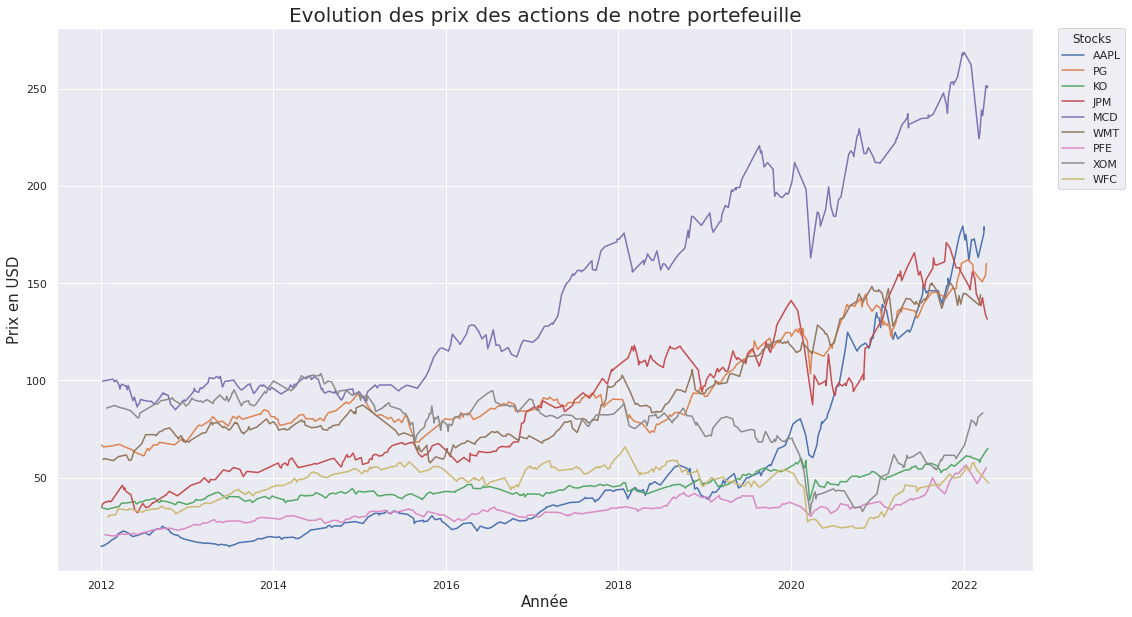

In [6]:
fig, ax = plt.subplots(figsize=(17.5, 10))
sns.lineplot(data=df, x='date', y='close', hue='code')
plt.title('Evolution des prix des actions de notre portefeuille', size=20)
plt.xlabel('Année', size=15)
plt.ylabel('Prix en USD', size=15)
plt.legend(bbox_to_anchor=(1.1, 1.01), loc='upper right')
ax.legend_.set_title('Stocks')

# 2 - Définition des caractéristiques de notre réseaux de neurones

In [7]:
import datetime
runtime_version = datetime.datetime.now().isoformat()
print(runtime_version)

2022-05-01T10:53:34.226583


In [8]:
config = {
    "market_types":"Stocks",
    "start_date": "2012-01-03",
    "end_date": "2022-04-18",
    "asset_length": 9,  # total assets 
    "features":["close","high"],
    "agents": {
        "window_length": 10
    },
    "epochs": 200,
    "noise_flag": True,
    "record_flag": True,
    "plot_flag": True,
    "reload_flag": False,
    "trainable": True,
    "method": "model_free"
}

In [9]:

"""
Configuration and initialisation of parameters
"""

def parse_config(config, mode):
    asset_length = config["asset_length"]
    start_date = config["start_date"]
    end_date = config["end_date"]
    features = config["features"]
    market = config["market_types"]
    noise_flag, record_flag, plot_flag=config["noise_flag"],config["record_flag"],config["plot_flag"]
    agent_config = config['agents']
    window_length = agent_config['window_length']
    reload_flag, trainable = config['reload_flag'],config['trainable']
    method = config['method']

    epochs = int(config["epochs"])

    if mode == 'test':
        record_flag=True
        noise_flag=False
        plot_flag=True
        reload_flag=True
        trainable=False
        method='model_free'

    print("*--------------------Training Status-------------------*")
    print("Date from",start_date,' to ',end_date)
    print('Features:',features)
    print("Agent: Noise(",noise_flag,')---Record(',record_flag,')---Plot(',plot_flag,')')
    print("Market Type:",market)
    print("Window_length:",window_length)
    print("Epochs:",epochs)
    print("Trainable:",trainable)
    print("Reloaded Model:",reload_flag)
    print("Method",method)
    print("Noise_flag",noise_flag)
    print("Record_flag",record_flag)
    print("Plot_flag",plot_flag)


    return asset_length,start_date,end_date,features,market, window_length,noise_flag, record_flag, plot_flag,reload_flag,trainable,method, epochs


In [10]:
asset_length, start_date, end_date, features, market, window_length, noise_flag, record_flag, plot_flag, reload_flag, trainable, method, epochs = parse_config(config, 'train')

*--------------------Training Status-------------------*
Date from 2012-01-03  to  2022-04-18
Features: ['close', 'high']
Agent: Noise( True )---Record( True )---Plot( True )
Market Type: Stocks
Window_length: 10
Epochs: 200
Trainable: True
Reloaded Model: False
Method model_free
Noise_flag True
Record_flag True
Plot_flag True


In [11]:
M = asset_length + 1
M

10

## Input de notre dataset

In [12]:
data_df = df_all

# 3 - Création de notre environment

In [13]:

eps = 10e-8


"""
An environment for financial portfolio management.
Financial portfolio management is the process of constant redistribution of a fund into different
financial products.
Based on [Jiang 2017](https://arxiv.org/abs/1706.10059)
"""
    
    
def fill_zeros(x):
    return '0'*(6-len(x))+x



    
"""
An environment for financial portfolio management.
Params:
    data_df - csv for data frame index of timestamps
         and multi-index columns levels=[['stock1'],...],['open','low','high','close']]
    steps - steps in episode
    window_length - how many past observations["history"] to return
    cost - cost of trade as a fraction,  e.g. 0.0025 corresponding to max rate of 0.25% at Poloniex (2017)
    time_cost - cost of holding as a fraction
    augment - fraction to randomly shift data by
    log_dir: directory to save plots to

"""
class Environment:
    def __init__(self):
        self.cost=0.0025

    def get_repo(self, data_df, start_date, end_date, codes_num, market):
        #Preprocessing des paramètres

        #Lecture de toutes les datas
        self.data=data_df
        self.data["code"]=self.data["code"].astype(str)
        

        sample_flag=True
        while sample_flag:
            codes=random.sample(set(self.data["code"]), codes_num)
            data2=self.data.loc[self.data["code"].isin(codes)]

            date_set=set(data2.loc[data2['code']==codes[0]].index)
            for code in codes:
                date_set=date_set.intersection((set(data2.loc[data2['code']==code].index)))
            if len(date_set)>1200:
                sample_flag=False

        date_set=date_set.intersection(set(pd.date_range(start_date,end_date)))
        self.date_set = list(date_set)
        self.date_set.sort()

        train_start_time = self.date_set[0]
        train_end_time = self.date_set[int(len(self.date_set) / 6) * 5 - 1]
        test_start_time = self.date_set[int(len(self.date_set) / 6) * 5]
        test_end_time = self.date_set[-1]

        return train_start_time,train_end_time,test_start_time,test_end_time,codes

    def get_data(self, data_df, start_time,end_time,features,window_length,market,codes):
        self.codes=codes

        self.data = data_df
        self.data["code"] = self.data["code"].astype(str)


        self.data[features]=self.data[features].astype(float)
        self.data=self.data[start_time.strftime("%Y-%m-%d"):end_time.strftime("%Y-%m-%d")]
        data=self.data
        
        #Initialisation des paramètres
        self.M=len(codes)+1
        self.N=len(features)
        self.L=int(window_length)
        self.date_set=pd.date_range(start_time,end_time)
        
        #mise en forme pandas du dataset
        asset_dict=dict() # asset data
        for asset in codes:
            asset_data=data[data["code"]==asset].reindex(self.date_set).sort_index()
            
     
            asset_data = asset_data.resample('D').mean()
            
            
            asset_data['close']=asset_data['close'].fillna(method='pad')
            # base_price = asset_data.ix[-1, 'close']
            base_price = asset_data['close'][-1]
            asset_dict[str(asset)]= asset_data
            asset_dict[str(asset)]['close'] = asset_dict[str(asset)]['close'] / base_price

            if 'high' in features:
                asset_dict[str(asset)]['high'] = asset_dict[str(asset)]['high'] / base_price

            if 'low' in features:
                asset_dict[str(asset)]['low']=asset_dict[str(asset)]['low'] / base_price

            if 'open' in features:
                asset_dict[str(asset)]['open']=asset_dict[str(asset)]['open'] / base_price

            asset_data=asset_data.fillna(method='bfill',axis=1)
            asset_data=asset_data.fillna(method='ffill',axis=1)
            
            #***********************open as preclose*******************#
            
            #asset_data=asset_data.dropna(axis=0,how='any')
            asset_dict[str(asset)]=asset_data

        ## Mise en forme de tensor
        self.states=[]
        self.price_history=[]
        self.real_close_prices=[]
        t =self.L+1
        length=len(self.date_set)
        while t<length-1:
            V_close = np.ones(self.L)
            if 'high' in features:
                V_high=np.ones(self.L)
            if 'open' in features:
                V_open=np.ones(self.L)
            if 'low' in features:
                V_low=np.ones(self.L)


            y=np.ones(1)
            state=[]
            for asset in codes:
                asset_data=asset_dict[str(asset)]

                
            ######################################################     
            #                                                    #
            #   Portfolio-Vector Memory according to the paper   #
            #                                                    #
            ######################################################


                # [t - self.L - 1:t - 1]
                V_close = np.vstack((V_close, asset_data['close'].iloc[t - self.L - 1:t - 1]))
                if 'high' in features:
                    V_high=np.vstack((V_high,asset_data['high'].iloc[t-self.L-1:t-1]))
                if 'low' in features:
                    V_low=np.vstack((V_low,asset_data['low'].iloc[t-self.L-1:t-1]))
                if 'open' in features:
                    V_open=np.vstack((V_open,asset_data['open'].iloc[t-self.L-1:t-1]))
                y=np.vstack((y,asset_data['close'].iloc[t]/asset_data['close'].iloc[t-1]))
            state.append(V_close)
            if 'high' in features:
                state.append(V_high)
            if 'low' in features:
                state.append(V_low)
            if 'open' in features:
                state = np.stack((state,V_open), axis=2)

            state=np.stack(state,axis=1)
            state = state.reshape(1, self.M, self.L, self.N)
            self.states.append(state)
            self.price_history.append(y)
            self.real_close_prices.append(V_close)
            t=t+1
        self.reset()


    def step(self, w1, w2, noise, step_unit = 1):
        
        """
        Step.
        w1 - new action of portfolio weights - e.g. [0.1,0.9, 0.0]
        w2 - price relative vector also called return
            e.g. [1.0, 0.9, 1.1]
        Numbered equations are from https://arxiv.org/abs/1706.10059
        """
            
        """
        Step the env.
        Actions should be portfolio [w0...]
        - Where wn is a portfolio weight between 0 and 1. The first (w0) is cash_bias
        - price is the portfolio conversion weights see 
        """
        if self.FLAG:
            not_terminal = 1
            
            price = self.price_history[self.t]
            close = self.real_close_prices[self.t]
            
            # noise
            if noise:
                price = price + np.stack(np.random.normal(0, 0.002, (1,len(price))), axis=1)
            
            mu = self.cost * (np.abs(w2[0][1:] - w1[0][1:])).sum()

            # std = self.states[self.t - 1][0].std(axis=0, ddof=0)
            # w2_std = (w2[0]* std).sum()

            # #adding risk
            # gamma=0.00
            # risk=gamma*w2_std

            risk=0
            r = (np.dot(w2, price)[0] - mu)[0]


            reward = np.log(r + eps)

            w2 = w2 / (np.dot(w2, price) + eps)
            self.t += step_unit
            if self.t >= len(self.states):
                not_terminal = 0
                self.reset()

            price = np.squeeze(price)
            info = {'reward': reward, 'continue': not_terminal, 'next state': self.states[self.t],
                    'weight vector': w2, 'price': price, 'risk':risk, 'close': close}
            return info
        else:
            info = {'reward': 0, 'continue': 1, 'next state': self.states[self.t],
                        'weight vector': np.array([[1] + [0 for i in range(self.M-1)]]),
                        'price': self.price_history[self.t],'risk':0, 'close':self.real_close_prices[self.t]}

            self.FLAG=True
            return info

    def reset(self):
        self.t=self.L+1
        self.FLAG = False

    def get_codes(self):
        return self.codes

In [14]:
env = Environment()

In [15]:
train_start_date, train_end_date, test_start_date, test_end_date, codes = env.get_repo(data_df, start_date, end_date, asset_length, market)

In [16]:
print("Codes:", codes)
print('Training Time Period:', train_start_date, '~', train_end_date)
print('Testing Time Period:', test_start_date, '~', test_end_date)

Codes: ['KO', 'JPM', 'AAPL', 'WMT', 'PG', 'WFC', 'MCD', 'PFE', 'XOM']
Training Time Period: 2012-01-03 00:00:00 ~ 2020-07-27 00:00:00
Testing Time Period: 2020-07-28 00:00:00 ~ 2022-04-18 00:00:00


In [17]:
env.get_data(data_df, train_start_date, train_end_date, features, window_length, market, codes)

# 4 - Agent

#### À chaque étape du training, l’agent échantillonne un lot qui est continu dans le temps et s’y entraîne, puis produit de nouveaux poids pour mettre à jour les anciens poids dans la mémoire vectorielle du portefeuille (PVM).

![](https://github.com/iffiX/PGPortfolio-pytorch/raw/master/images/agent.png)

In [18]:
output_dir = '/content/result' #Changer le chemin 

In [19]:
tf.disable_v2_behavior()

class PG:
    def __init__(self,M,L,N,name,load_weights,trainable,noise_flag,runtime_version):
        
        # Initial buffer
        self.buffer = list()
        self.name = name
        self.learning_rate=10e-3
        self.runtime_version=str(runtime_version)
        self.noise_flag=noise_flag
        
        # Build up models
        tf.reset_default_graph()
        self.sesson = tf.Session()

        # Initial input shape
        self.M = M
        self.L = L
        self.N = N
        self.global_step = tf.Variable(0, trainable = False)

        self.state, self.w_previous, self.out = self.build_net()
        self.future_price = tf.placeholder(tf.float32,[None] + [self.M])
        self.pv_vector = tf.reduce_sum(self.out * self.future_price, reduction_indices=[1]) * self.pc()
        self.profit = tf.reduce_prod(self.pv_vector)
        self.loss = -tf.reduce_mean(tf.log(self.pv_vector))
        self.optimize=tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss,global_step=self.global_step)

        # Initial saver
        self.saver = tf.train.Saver(max_to_keep=10)

        if load_weights:
            print("Loading Model")
            try:
                checkpoint_dir = f'{output_dir}/{self.runtime_version}/PG/saved_network/'+str(noise_flag)+'/'
                print(f'checkpoint dir: {checkpoint_dir}')
                checkpoint = tf.train.get_checkpoint_state(checkpoint_dir)
                if checkpoint and checkpoint.model_checkpoint_path:
                    print("start restore")
                    self.saver.restore(self.sesson, checkpoint.model_checkpoint_path)
                    print("Successfully loaded:", checkpoint.model_checkpoint_path)
                else:
                    raise Exception("Could not find old network weights")
                    # self.sesson.run(tf.global_variables_initializer())

            except:
                raise Exception("Could not find old network weights")
                # self.sesson.run(tf.global_variables_initializer())
        else:
            self.sesson.run(tf.global_variables_initializer())

        if trainable:
            
            # Initial summary
            self.summary_writer = tf.summary.FileWriter(f'{output_dir}/{self.runtime_version}/PG/summary/'+str(noise_flag)+'/', self.sesson.graph)
            self.summary_ops, self.summary_vars = self.build_summaries()


    # setup policy gradient neural network 
    def build_net(self):
        state=tf.placeholder(tf.float32,shape=[None]+[self.M]+[self.L]+[self.N],name='market_situation')
        network = tflearn.layers.conv_2d(state, 2,
                                         [1, 2],
                                         [1, 1, 1, 1],
                                         'valid',
                                         'relu')
        width = network.get_shape()[2]
        network = tflearn.layers.conv_2d(network, 48,
                                         [1, width],
                                         [1, 1],
                                         "valid",
                                         'relu',
                                         regularizer="L2",
                                         weight_decay=5e-9)
        w_previous=tf.placeholder(tf.float32,shape=[None,self.M])
        network=tf.concat([network,tf.reshape(w_previous, [-1, self.M, 1, 1])],axis=3)
        network = tflearn.layers.conv_2d(network, 1,
                                         [1, network.get_shape()[2]],
                                         [1, 1],
                                         "valid",
                                         'relu',
                                         regularizer="L2",
                                         weight_decay=5e-9)
        network=tf.layers.flatten(network)
        w_init = tf.random_uniform_initializer(-0.005, 0.005)
        out = tf.layers.dense(network, self.M, activation=tf.nn.softmax, kernel_initializer=w_init)

        return state,w_previous,out

    def pc(self):
        return 1 - tf.reduce_sum(tf.abs(self.out[:, 1:] - self.w_previous[:, 1:]), axis=1) * 0.0025

    # action (edited)
    def predict(self,s,a_previous):
        return self.sesson.run(self.out,feed_dict={self.state:s,self.w_previous:a_previous})

    # current round transition (edited)
    def save_transition(self, s, p, action,action_previous):
        self.buffer.append((s, p, action,action_previous))

    # update parameter to train (edited)
    def train(self):
        s,p,a,a_previous=self.get_buffer()
        profit,_= self.sesson.run([self.profit,self.optimize],feed_dict={
            self.state: s,
            self.out: np.reshape(a,(-1, self.M)),
            self.future_price: np.reshape(p,(-1, self.M)),
            self.w_previous: np.reshape(a_previous,(-1, self.M))
        })

    def get_buffer(self):
        s = [data[0][0] for data in self.buffer]
        p = [data[1] for data in self.buffer]
        a = [data[2] for data in self.buffer]
        a_previous = [data[3] for data in self.buffer]
        return s, p,a,a_previous

    def reset_buffer(self):
        self.buffer = list()

    def save_model(self):
        path=f'{output_dir}/{self.runtime_version}/PG/saved_network/'+ str(self.noise_flag) +'/'
        if not os.path.exists(path):
            os.makedirs(path)
        self.saver.save(self.sesson,path+self.name,global_step=self.global_step)

    def write_summary(self,reward):
        summary_str = self.sesson.run(self.summary_ops, feed_dict={
            self.summary_vars[0]: reward,
        })
        self.summary_writer.add_summary(summary_str, self.sesson.run(self.global_step))

    def close(self):
        self.sesson.close()

    def build_summaries(self):
        self.reward = tf.Variable(0.)
        tf.summary.scalar('Reward', self.reward)
        summary_vars = [self.reward]
        summary_ops = tf.summary.merge_all()
        return summary_ops, summary_vars

# 5 - Phase de training

In [20]:

class StockTrader():
    def __init__(self):
        self.reset()

    def reset(self):
        self.wealth = 10e3
        self.total_reward = 0
        self.ep_ave_max_q = 0
        self.loss = 0
        self.actor_loss=0

        self.wealth_history = []
        self.r_history = []
        self.w_history = []
        self.p_history = []

    def update_summary(self,loss,r,q_value,actor_loss,w,p):
        self.loss += loss
        self.actor_loss+=actor_loss
        self.total_reward+=r
        self.ep_ave_max_q += q_value
        self.r_history.append(r)
        self.wealth = self.wealth * math.exp(r)
        self.wealth_history.append(self.wealth)
        self.w_history.extend([','.join([str(Decimal(str(w0)).quantize(Decimal('0.00'))) for w0 in w.tolist()[0]])])
        self.p_history.extend([','.join([str(Decimal(str(p0)).quantize(Decimal('0.000'))) for p0 in p.tolist()])])

    def write(self, agent_name: str, epoch = '', codes = [], prefix_dir=''):
        
        wealth_history = pd.Series(self.wealth_history)
        r_history = pd.Series(self.r_history)
        w_history = pd.Series(self.w_history)
        p_history = pd.Series(self.p_history)
        history = pd.concat([wealth_history, r_history, w_history, p_history], axis=1, keys=['wealth', 'reward', 'weight', 'price'])
        dir_path = f'{output_dir}/{prefix_dir}'
        file_path = f'{dir_path}/{agent_name}-{epoch}-{"_".join(codes)}-{str(math.exp(np.sum(self.r_history)) * 100)}.csv'
        os.makedirs(dir_path, exist_ok=True)
        history.to_csv(file_path)

    def print_result(self,epoch,agent,noise_flag):
        self.total_reward=math.exp(self.total_reward) * 100
        print('*-----Episode: {:d}, Reward:{:.6f}%-----*'.format(epoch, self.total_reward))
        agent.write_summary(self.total_reward)
        agent.save_model()

    def plot_result(self):
        pd.Series(self.wealth_history).plot()
        plt.show()



In [21]:
def parse_info(info):
    return info['reward'],info['continue'],info[ 'next state'],info['weight vector'], info['price'], info['risk'], info['close']

In [22]:
"""
Implementation of the framework woth Deep deterministic policy gradient (https://arxiv.org/pdf/1509.02971v2.pdf)
or Proximal Policy Optimization Agents with PPOAgent from tensorforce.agents library

But we did not have the time to implement them

so we will use the PG one 

"""


def traversal(stocktrader,agent,env,epoch,noise_flag,framework,method,trainable):
    info = env.step(None,None,noise_flag)
    r,contin,s,w1,p,risk,_=parse_info(info)
    contin=1
    t=0

    while contin:
        w2 = agent.predict(s, w1)
        env_info = env.step(w1, w2, noise_flag)
        r, contin, s_next, w1, p, risk, _ = parse_info(env_info)

        if framework=='PG':
            agent.save_transition(s,p,w2,w1)
        else:
            agent.save_transition(s, w2, r-risk, contin, s_next, w1)
        loss, q_value,actor_loss=0,0,0

        if framework=='DDPG':
            if not contin and trainable:
                agent_info= agent.train(method,epoch)
                loss, q_value=agent_info["critic_loss"],agent_info["q_value"]
                if method=='model_based':
                    actor_loss=agent_info["actor_loss"]

        elif framework=='PPO':
            if not contin and trainable:
                agent_info = agent.train(method, epoch)
                loss, q_value = agent_info["critic_loss"], agent_info["q_value"]
                if method=='model_based':
                    actor_loss=agent_info["actor_loss"]

        elif framework=='PG':
            if not contin and trainable:
                agent.train()

        stocktrader.update_summary(loss,r,q_value,actor_loss,w2,p)
        s = s_next
        t=t+1


In [23]:
stocktrader = StockTrader()

*-----------------Loading PG Agent---------------------*
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:541: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Training with 200
Now we are at epoch 0


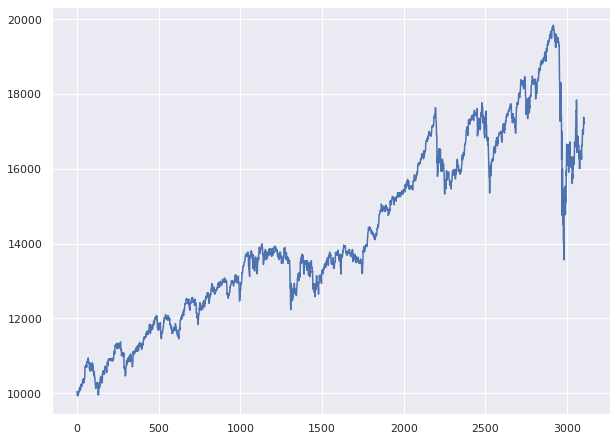

*-----Episode: 0, Reward:172.064303%-----*
Now we are at epoch 1


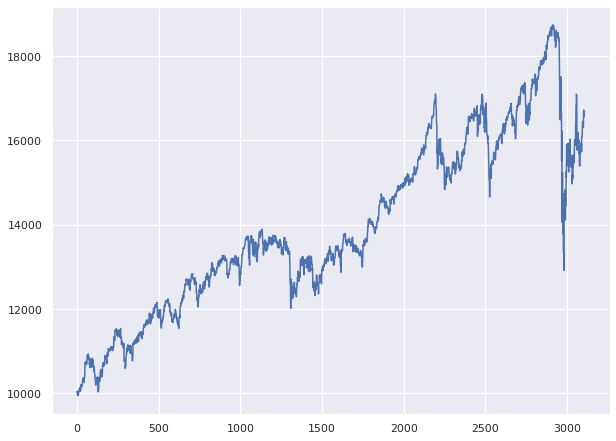

*-----Episode: 1, Reward:165.673863%-----*
Now we are at epoch 2


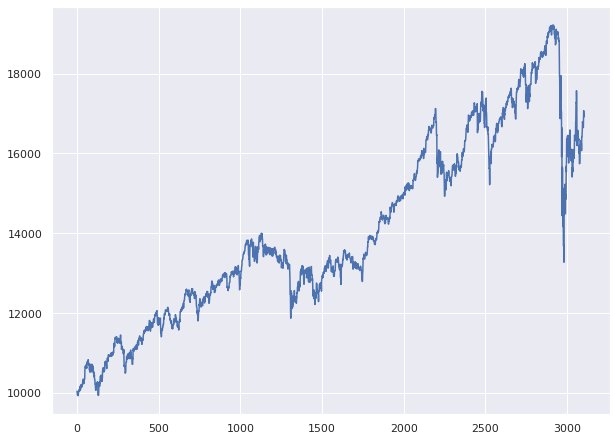

*-----Episode: 2, Reward:169.203666%-----*
Now we are at epoch 3


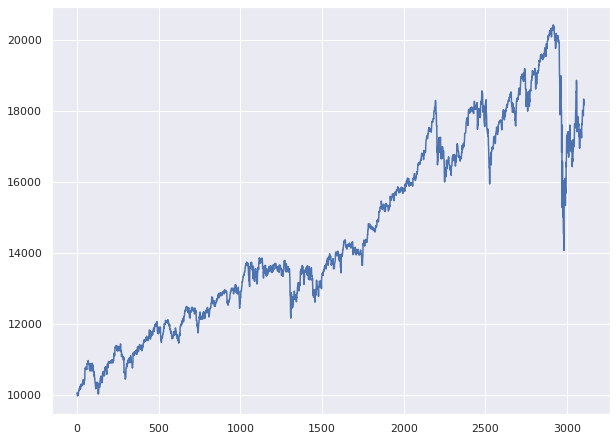

*-----Episode: 3, Reward:181.880824%-----*
Now we are at epoch 4


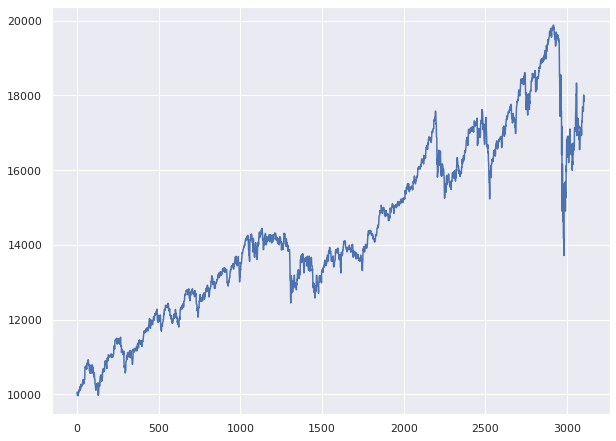

*-----Episode: 4, Reward:178.418974%-----*
Now we are at epoch 5


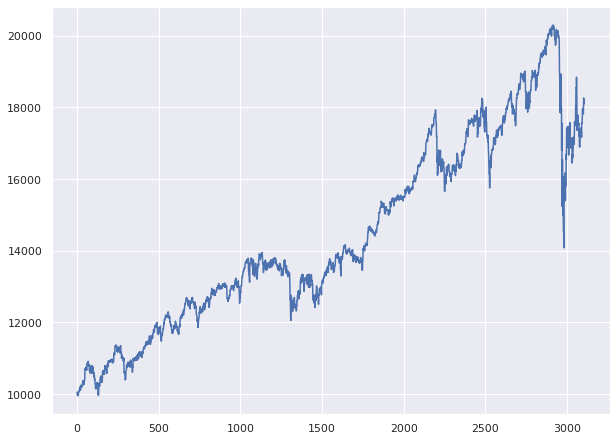

*-----Episode: 5, Reward:181.055923%-----*
Now we are at epoch 6


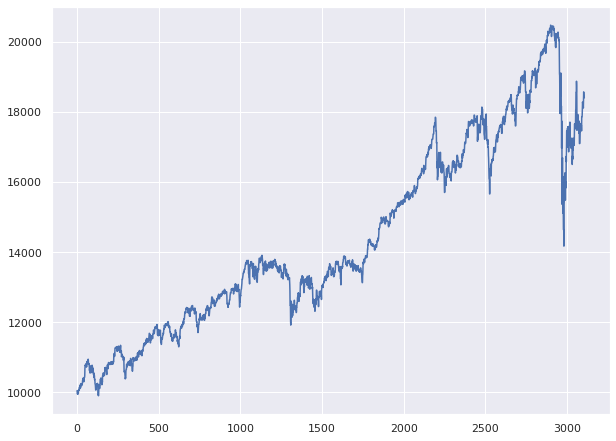

*-----Episode: 6, Reward:184.048187%-----*
Now we are at epoch 7


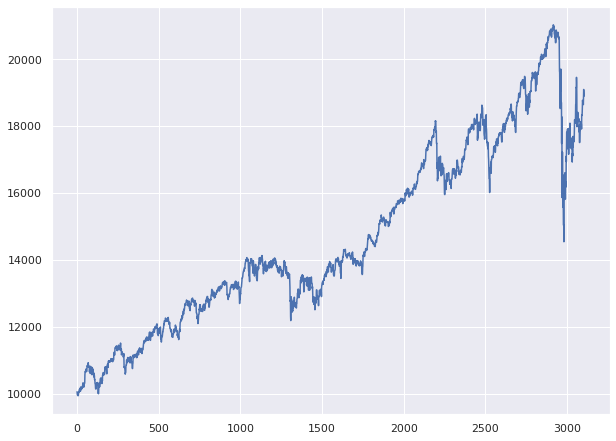

*-----Episode: 7, Reward:188.933103%-----*
Now we are at epoch 8


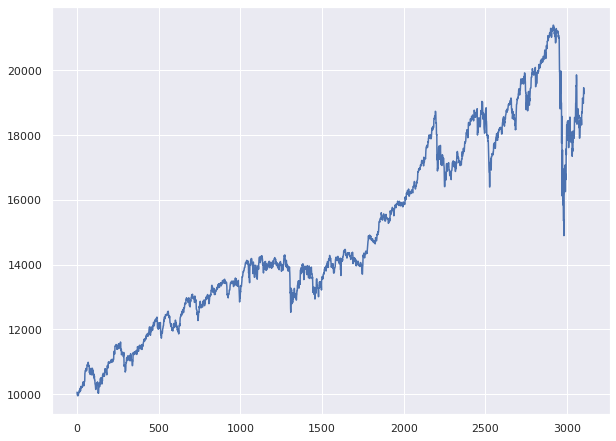

*-----Episode: 8, Reward:192.876635%-----*
Now we are at epoch 9


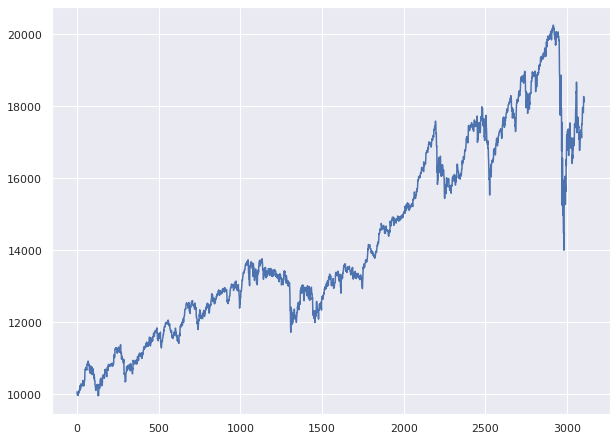

*-----Episode: 9, Reward:181.395360%-----*
Now we are at epoch 10


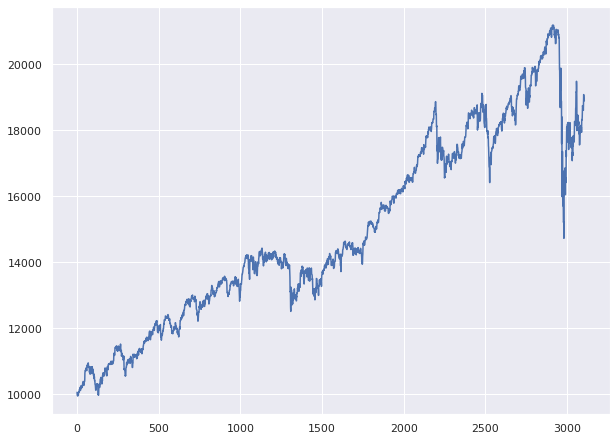

*-----Episode: 10, Reward:188.841992%-----*
Instructions for updating:
Use standard file APIs to delete files with this prefix.
Now we are at epoch 11


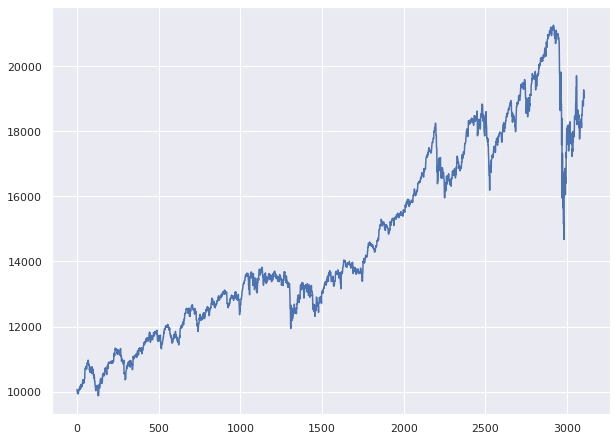

*-----Episode: 11, Reward:190.283396%-----*
Now we are at epoch 12


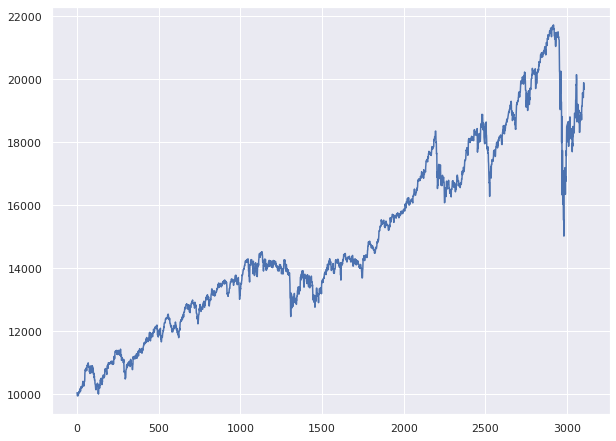

*-----Episode: 12, Reward:196.784473%-----*
Now we are at epoch 13


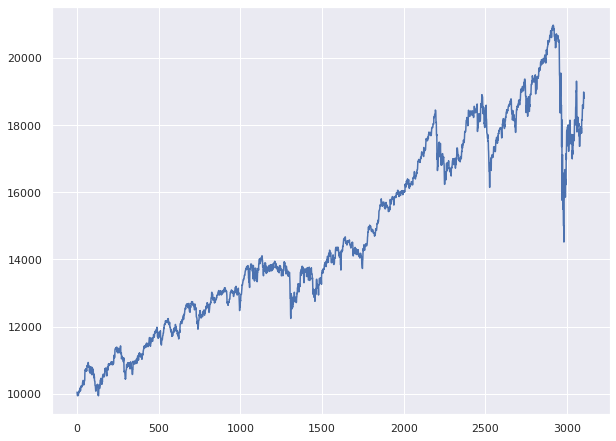

*-----Episode: 13, Reward:188.038122%-----*
Now we are at epoch 14


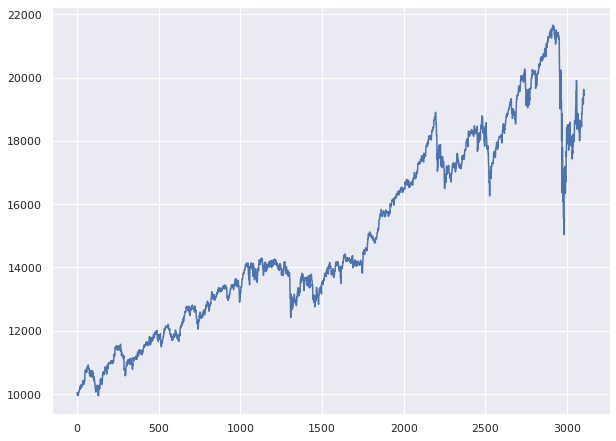

*-----Episode: 14, Reward:194.438574%-----*
Now we are at epoch 15


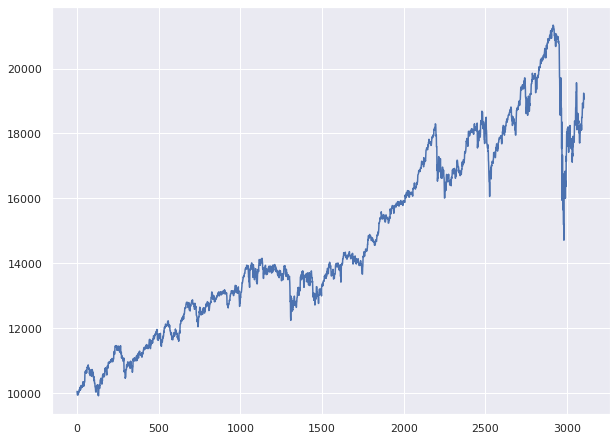

*-----Episode: 15, Reward:190.637919%-----*
Now we are at epoch 16


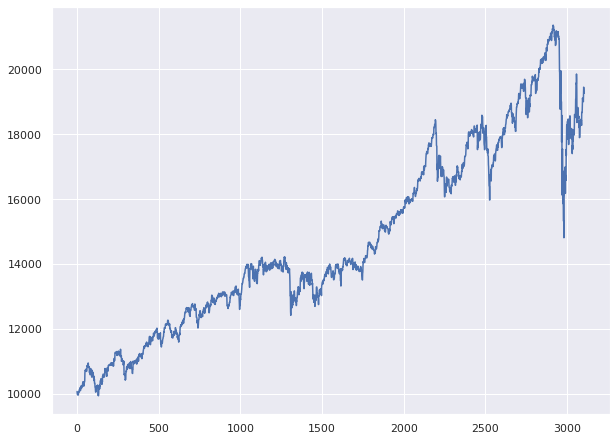

*-----Episode: 16, Reward:192.615061%-----*
Now we are at epoch 17


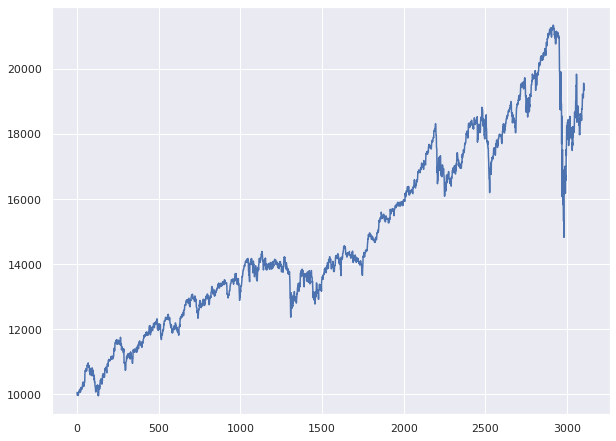

*-----Episode: 17, Reward:193.595349%-----*
Now we are at epoch 18


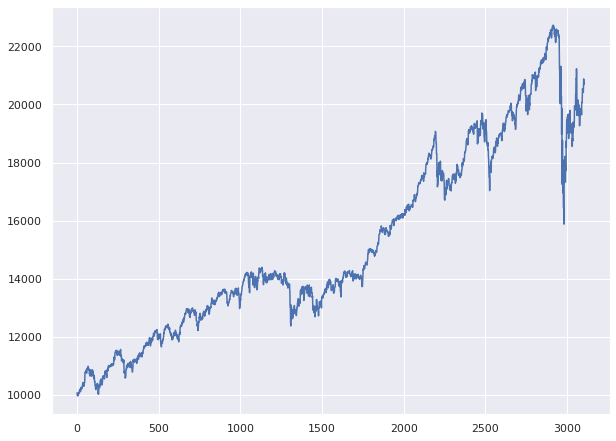

*-----Episode: 18, Reward:207.033436%-----*
Now we are at epoch 19


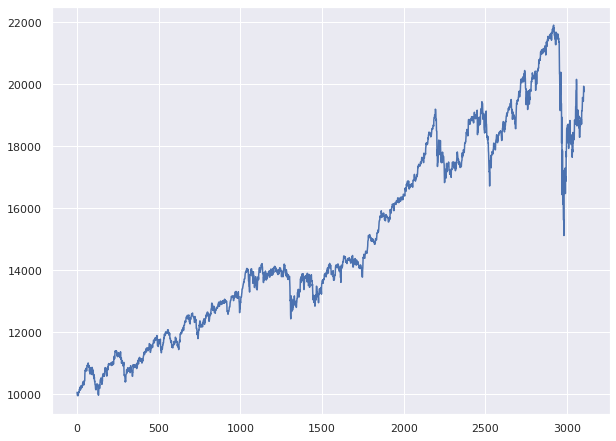

*-----Episode: 19, Reward:197.739161%-----*
Now we are at epoch 20


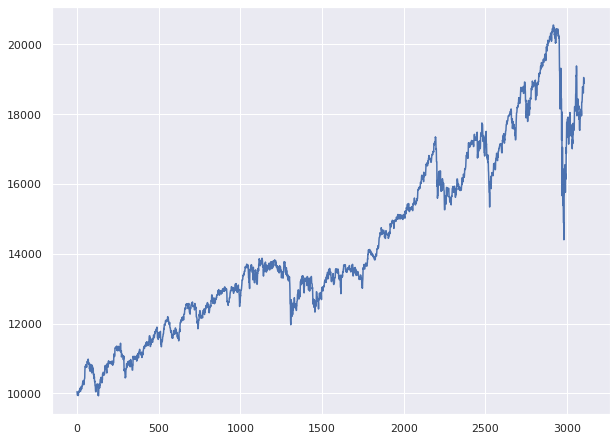

*-----Episode: 20, Reward:188.736520%-----*
Now we are at epoch 21


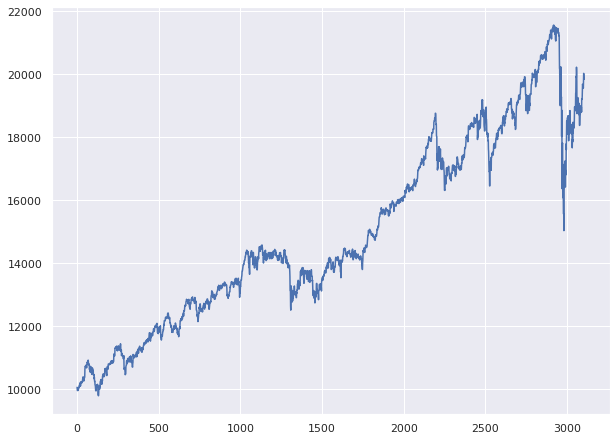

*-----Episode: 21, Reward:198.424645%-----*
Now we are at epoch 22


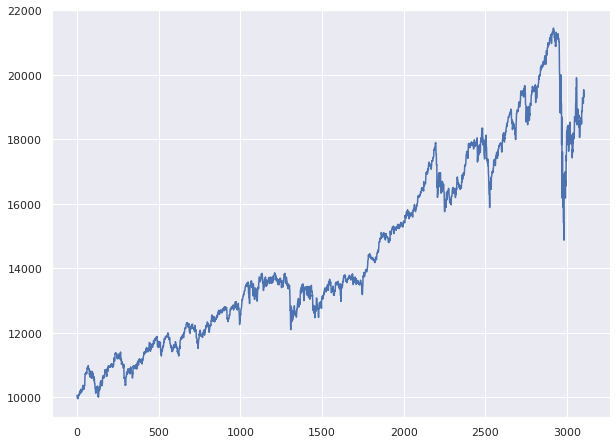

*-----Episode: 22, Reward:193.268182%-----*
Now we are at epoch 23


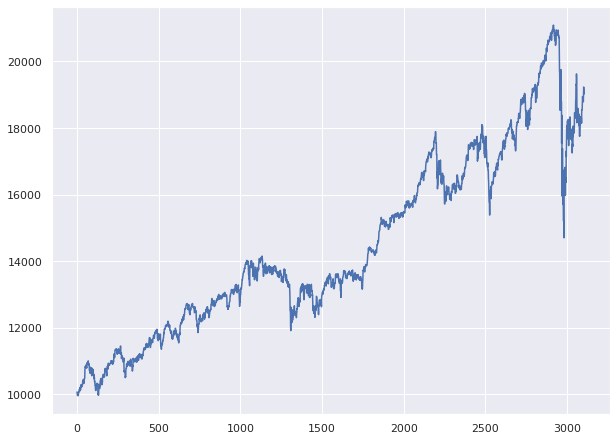

*-----Episode: 23, Reward:190.273010%-----*
Now we are at epoch 24


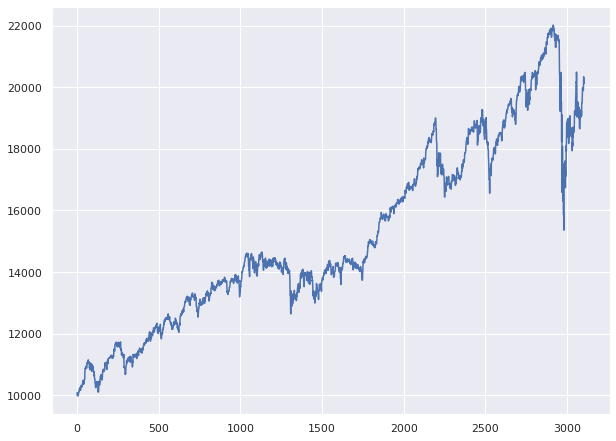

*-----Episode: 24, Reward:201.235294%-----*
Now we are at epoch 25


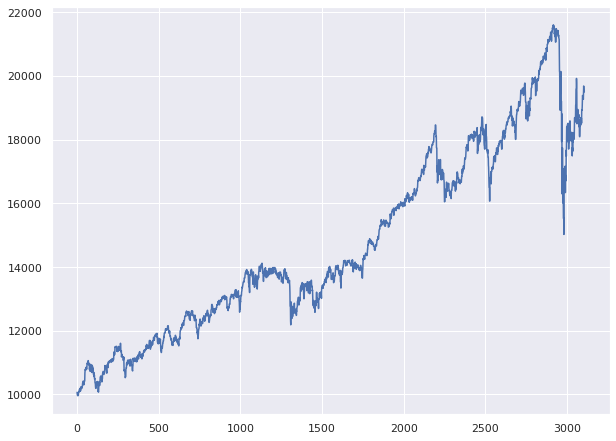

*-----Episode: 25, Reward:194.983088%-----*
Now we are at epoch 26


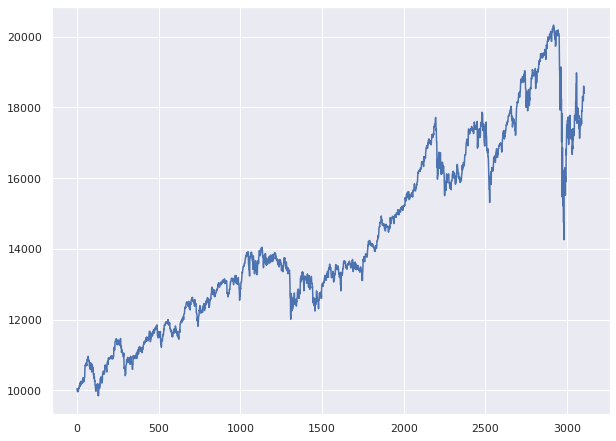

*-----Episode: 26, Reward:183.984858%-----*
Now we are at epoch 27


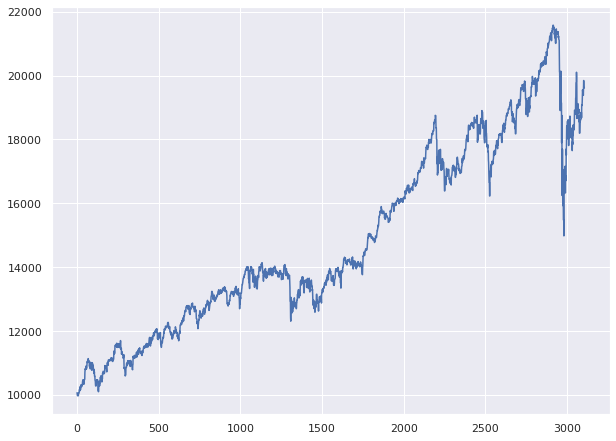

*-----Episode: 27, Reward:196.117209%-----*
Now we are at epoch 28


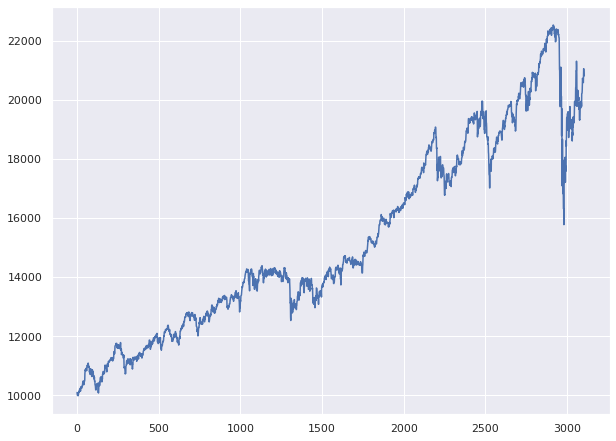

*-----Episode: 28, Reward:208.114877%-----*
Now we are at epoch 29


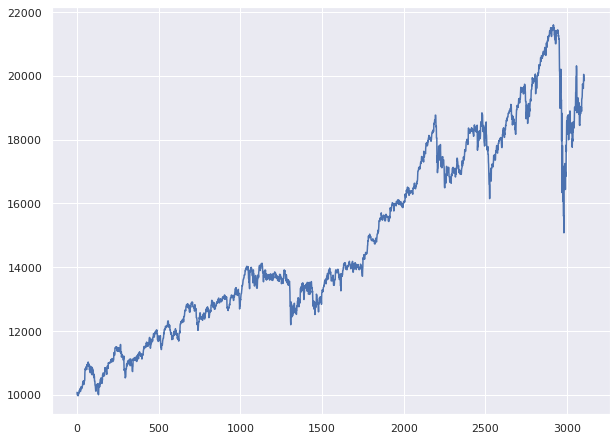

*-----Episode: 29, Reward:198.614123%-----*
Now we are at epoch 30


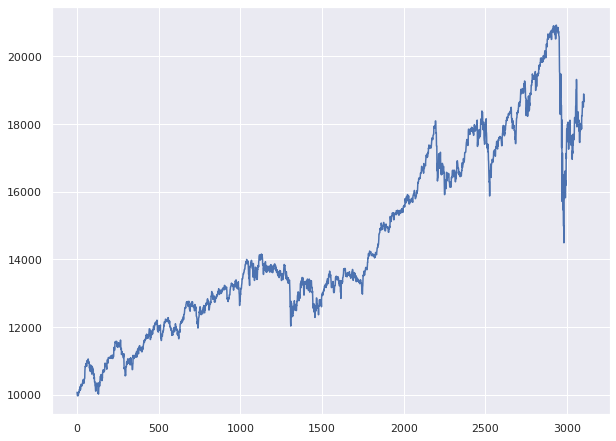

*-----Episode: 30, Reward:186.709090%-----*
Now we are at epoch 31


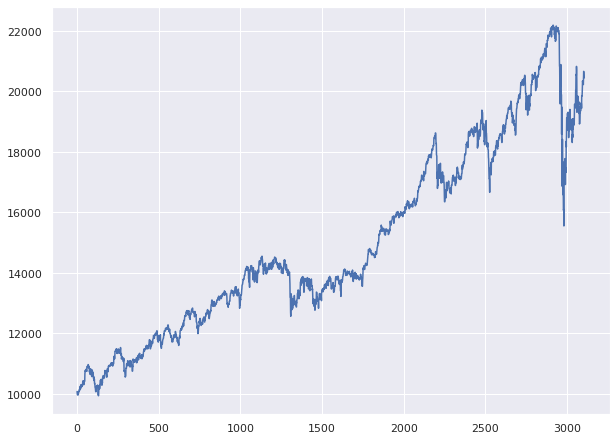

*-----Episode: 31, Reward:204.513010%-----*
Now we are at epoch 32


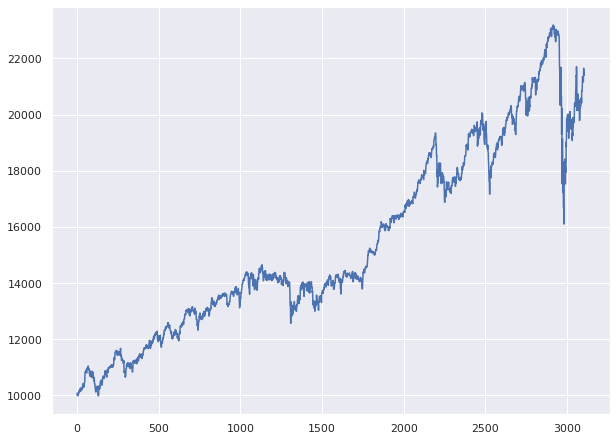

*-----Episode: 32, Reward:214.010802%-----*
Now we are at epoch 33


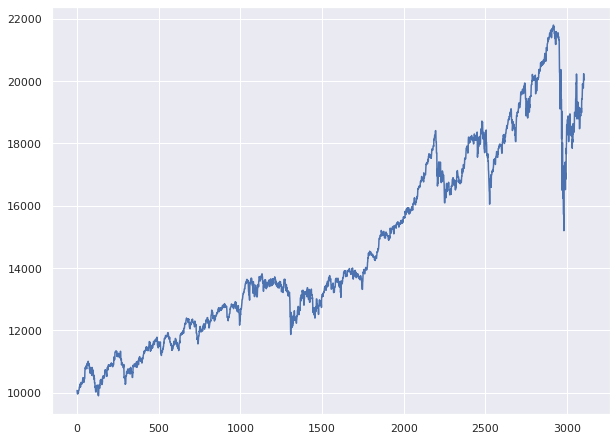

*-----Episode: 33, Reward:200.459889%-----*
Now we are at epoch 34


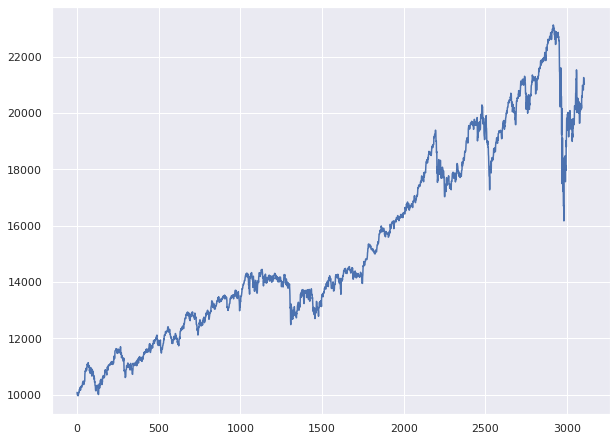

*-----Episode: 34, Reward:210.451137%-----*
Now we are at epoch 35


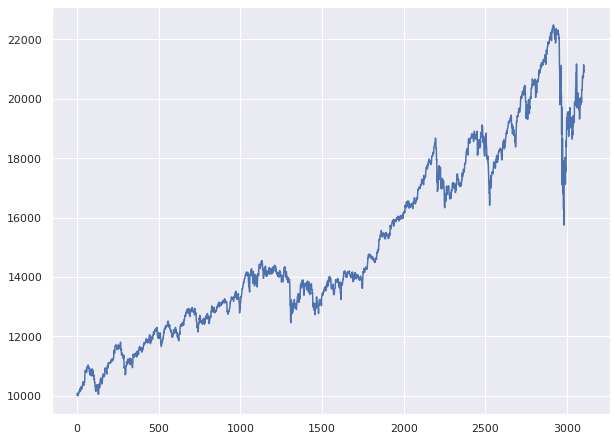

*-----Episode: 35, Reward:209.183919%-----*
Now we are at epoch 36


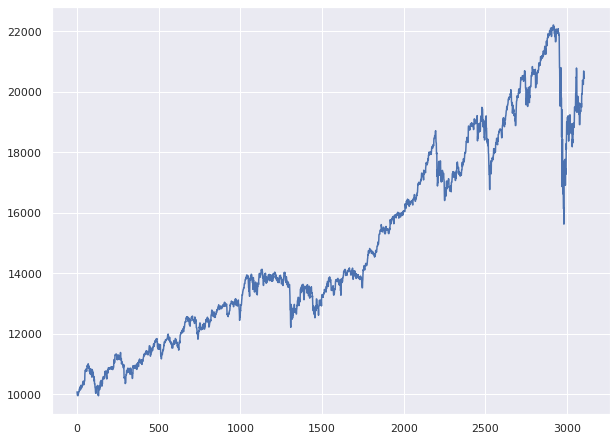

*-----Episode: 36, Reward:204.448660%-----*
Now we are at epoch 37


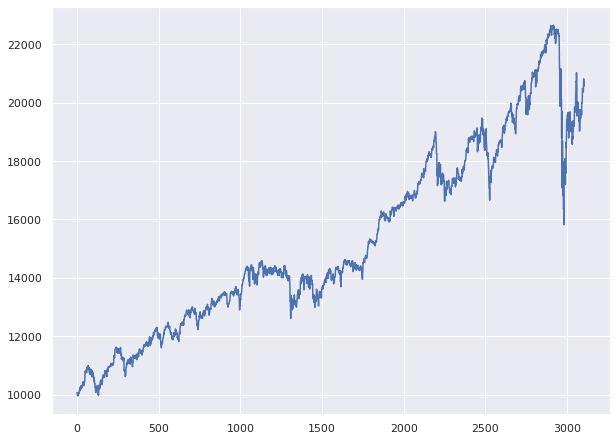

*-----Episode: 37, Reward:205.700649%-----*
Now we are at epoch 38


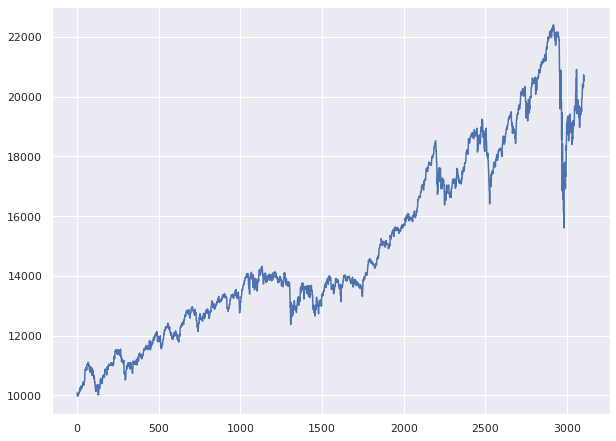

*-----Episode: 38, Reward:205.334843%-----*
Now we are at epoch 39


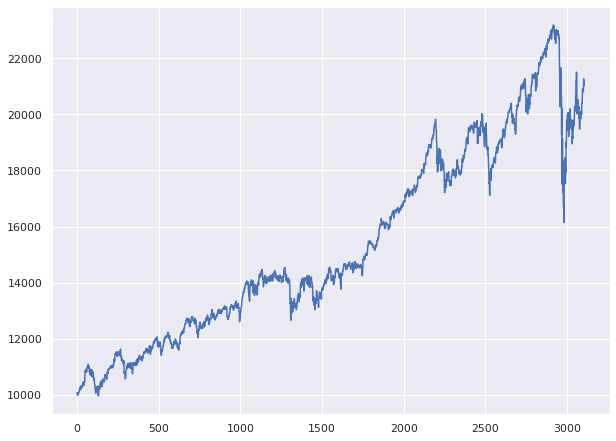

*-----Episode: 39, Reward:210.271403%-----*
Now we are at epoch 40


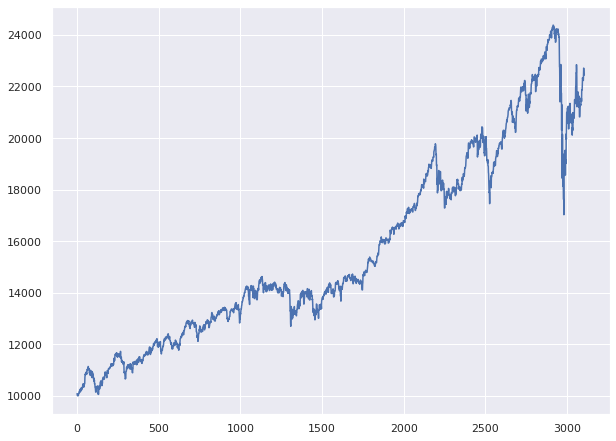

*-----Episode: 40, Reward:224.562095%-----*
Now we are at epoch 41


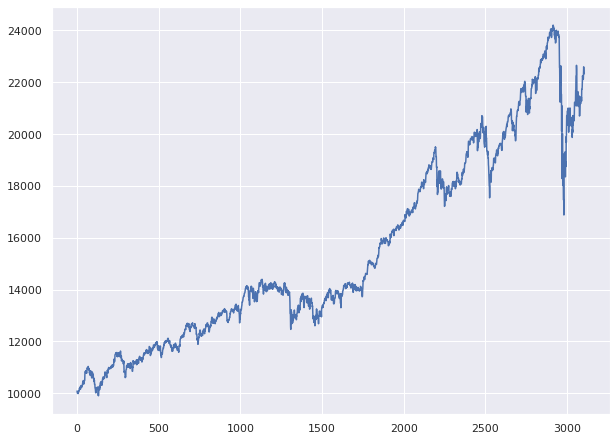

*-----Episode: 41, Reward:223.298480%-----*
Now we are at epoch 42


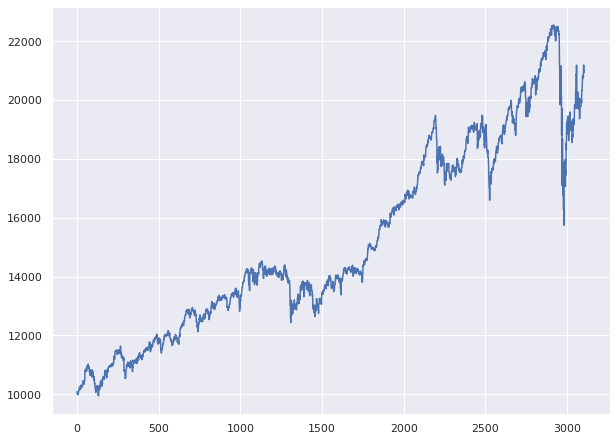

*-----Episode: 42, Reward:209.502816%-----*
Now we are at epoch 43


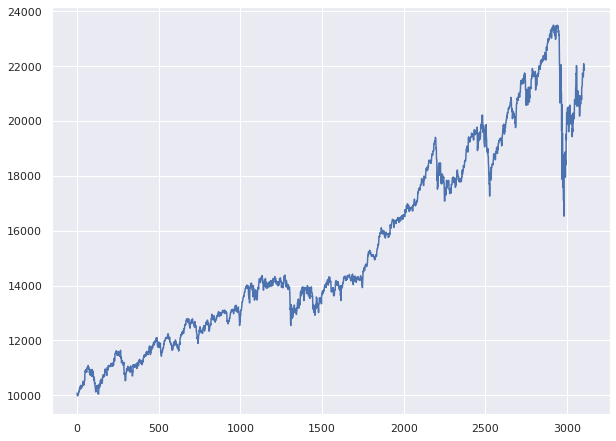

*-----Episode: 43, Reward:218.567598%-----*
Now we are at epoch 44


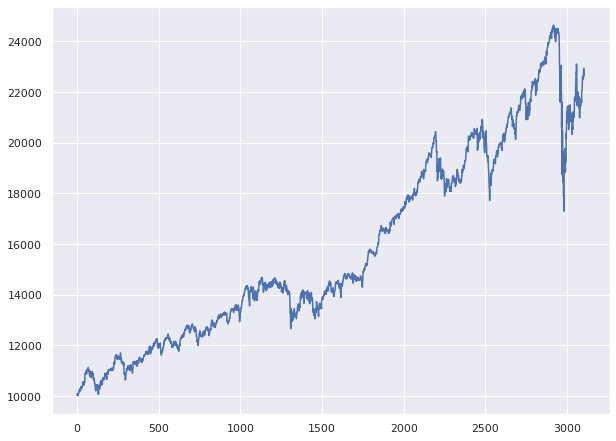

*-----Episode: 44, Reward:226.422509%-----*
Now we are at epoch 45


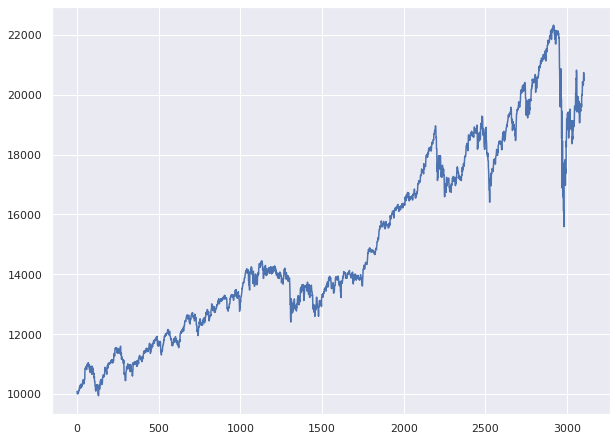

*-----Episode: 45, Reward:204.836697%-----*
Now we are at epoch 46


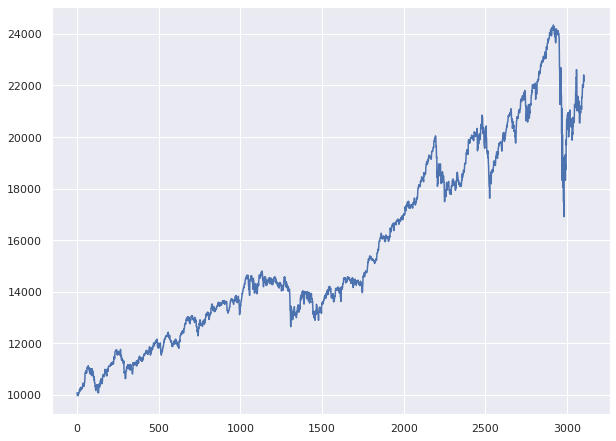

*-----Episode: 46, Reward:221.770392%-----*
Now we are at epoch 47


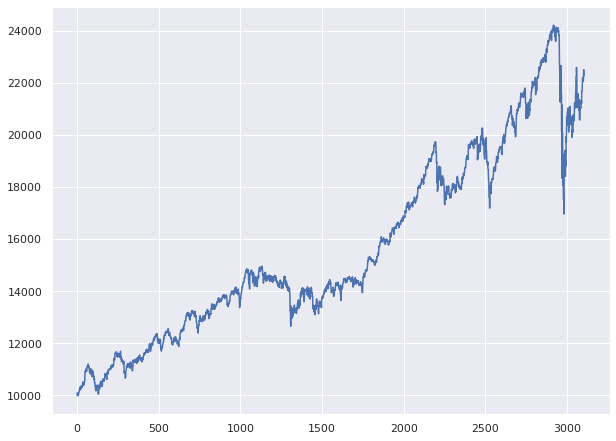

*-----Episode: 47, Reward:222.772085%-----*
Now we are at epoch 48


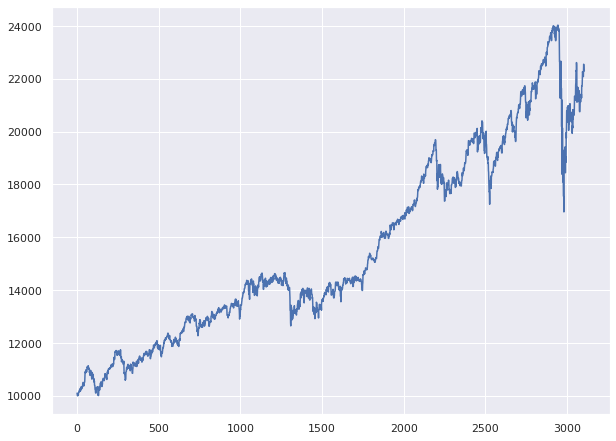

*-----Episode: 48, Reward:223.132288%-----*
Now we are at epoch 49


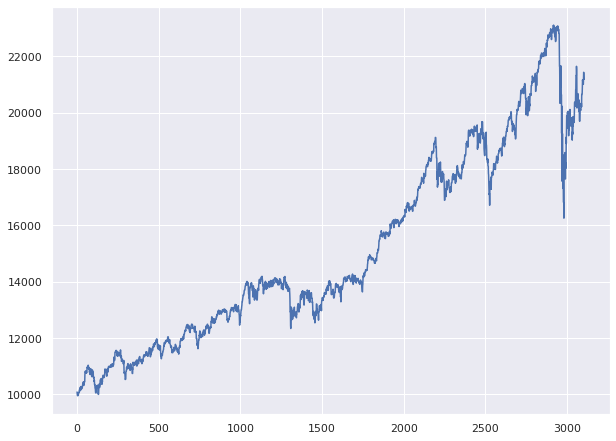

*-----Episode: 49, Reward:211.986233%-----*
Now we are at epoch 50


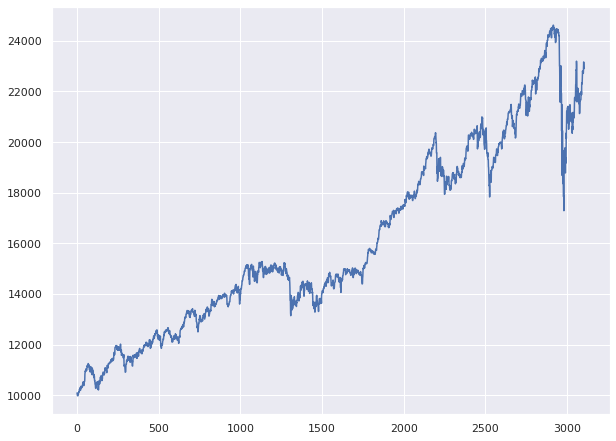

*-----Episode: 50, Reward:229.153166%-----*
Now we are at epoch 51


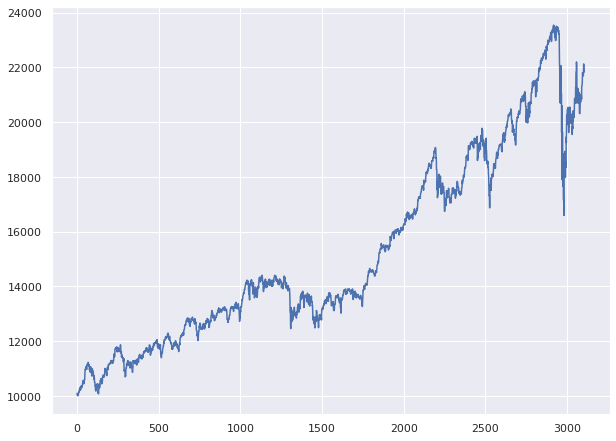

*-----Episode: 51, Reward:218.403730%-----*
Now we are at epoch 52


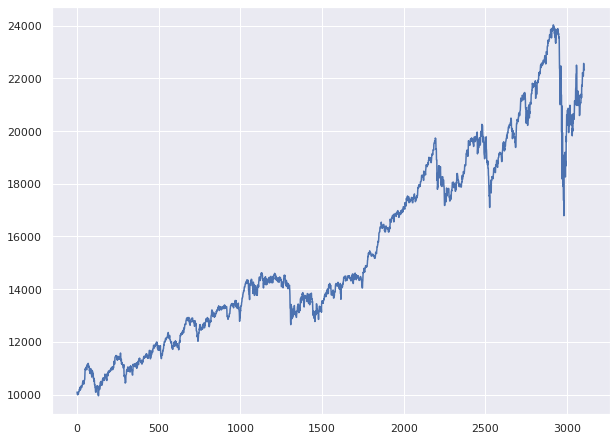

*-----Episode: 52, Reward:223.213370%-----*
Now we are at epoch 53


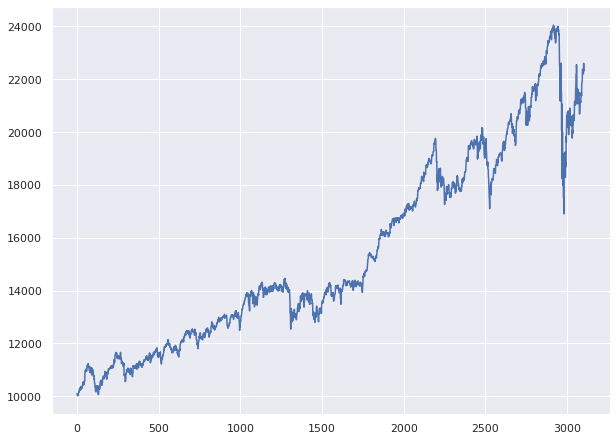

*-----Episode: 53, Reward:223.213013%-----*
Now we are at epoch 54


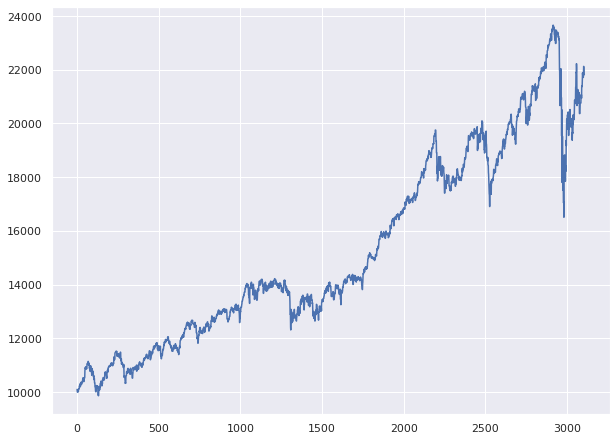

*-----Episode: 54, Reward:218.164624%-----*
Now we are at epoch 55


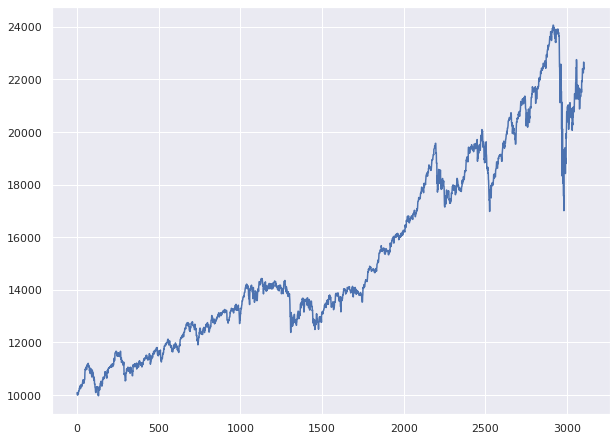

*-----Episode: 55, Reward:224.150106%-----*
Now we are at epoch 56


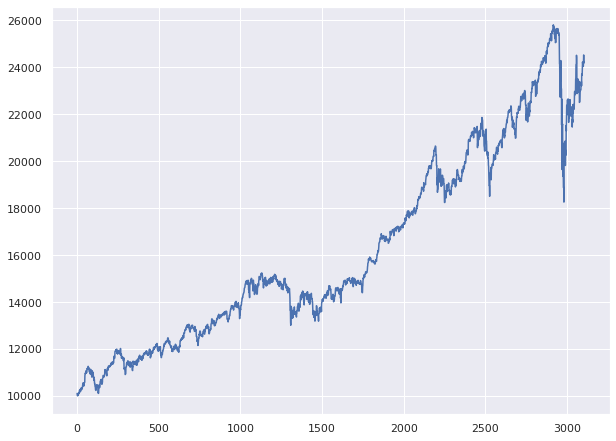

*-----Episode: 56, Reward:241.898822%-----*
Now we are at epoch 57


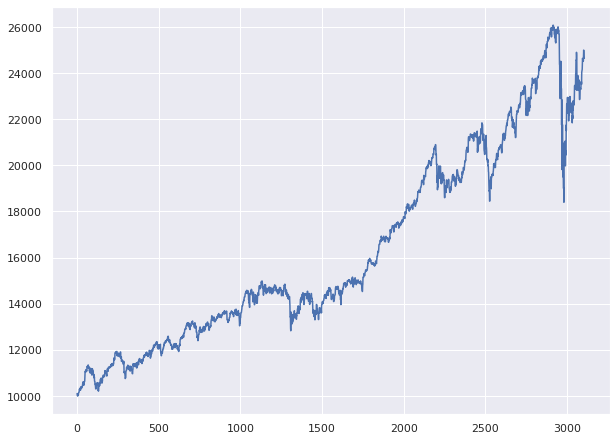

*-----Episode: 57, Reward:246.450855%-----*
Now we are at epoch 58


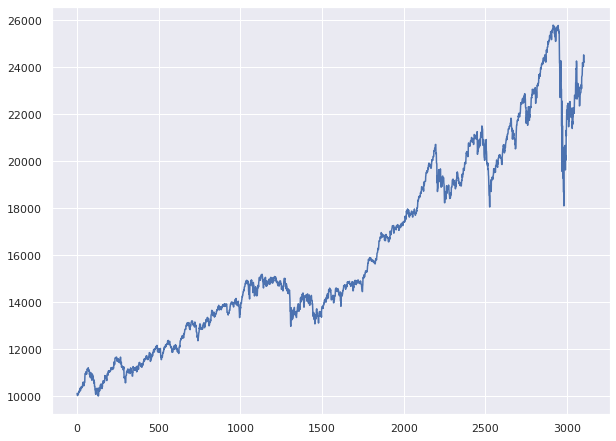

*-----Episode: 58, Reward:242.183721%-----*
Now we are at epoch 59


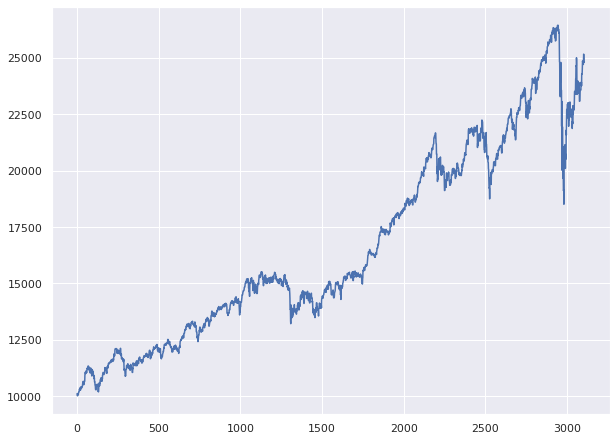

*-----Episode: 59, Reward:248.116061%-----*
Now we are at epoch 60


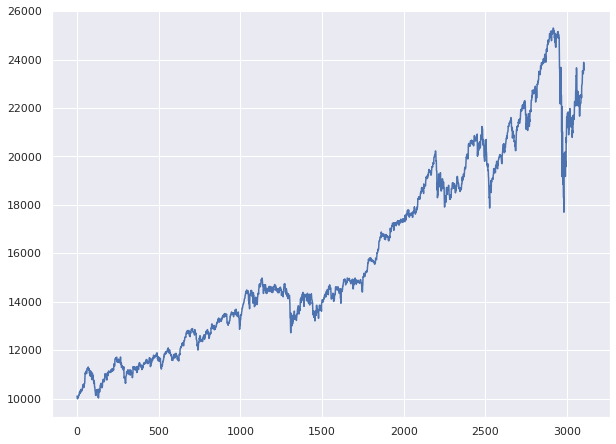

*-----Episode: 60, Reward:235.741749%-----*
Now we are at epoch 61


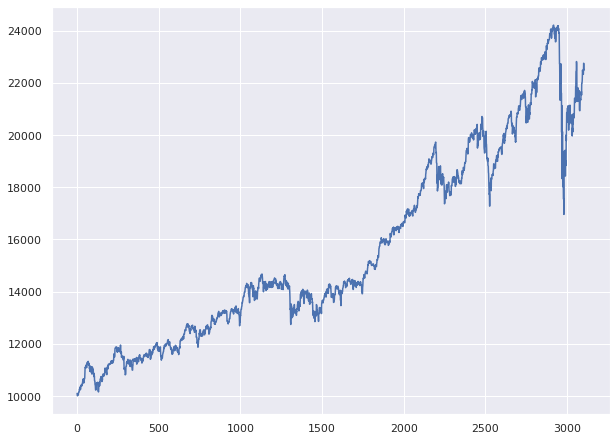

*-----Episode: 61, Reward:224.906221%-----*
Now we are at epoch 62


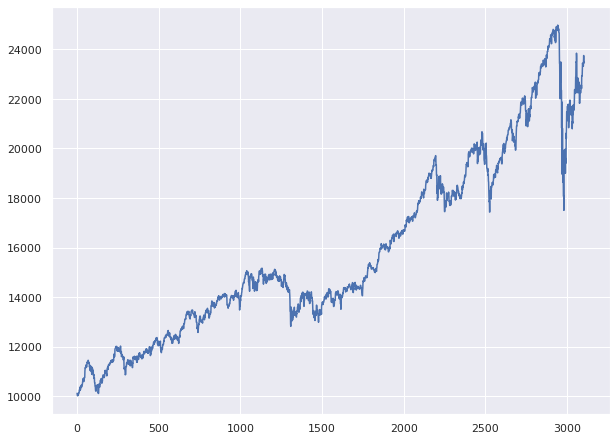

*-----Episode: 62, Reward:234.882859%-----*
Now we are at epoch 63


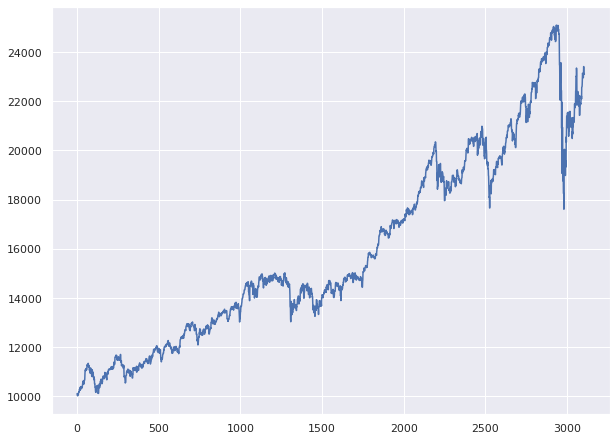

*-----Episode: 63, Reward:230.938392%-----*
Now we are at epoch 64


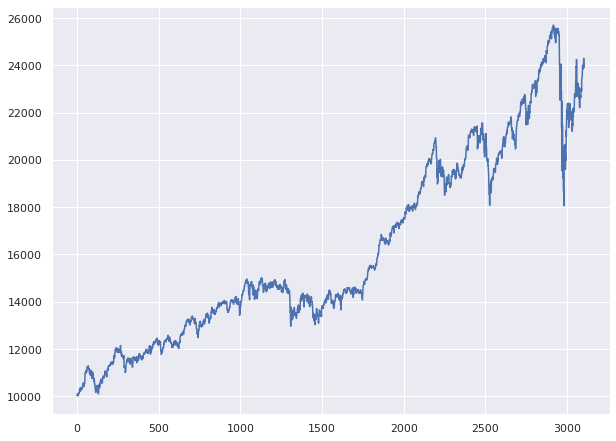

*-----Episode: 64, Reward:239.253509%-----*
Now we are at epoch 65


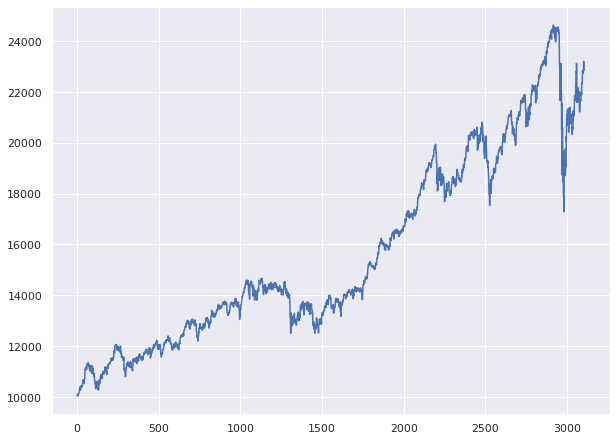

*-----Episode: 65, Reward:228.666919%-----*
Now we are at epoch 66


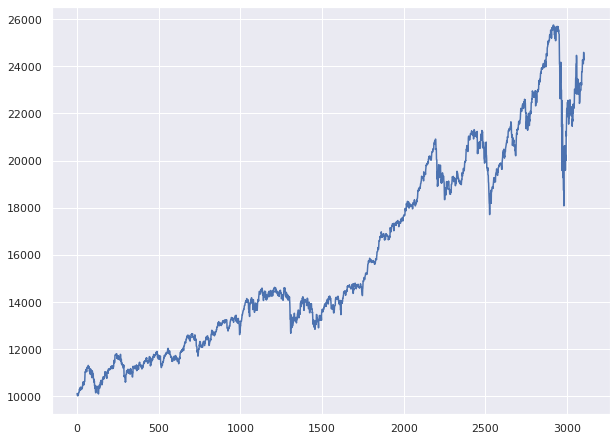

*-----Episode: 66, Reward:242.831713%-----*
Now we are at epoch 67


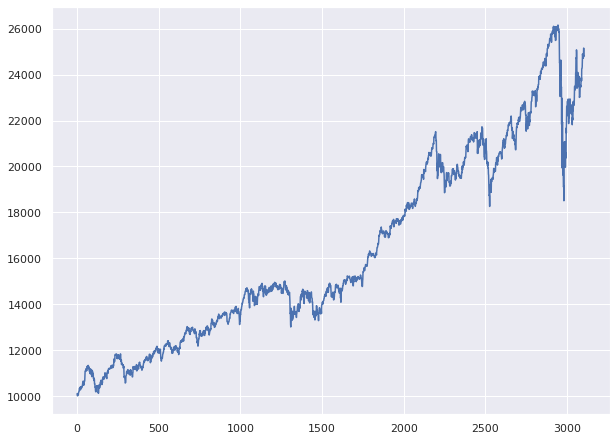

*-----Episode: 67, Reward:248.055730%-----*
Now we are at epoch 68


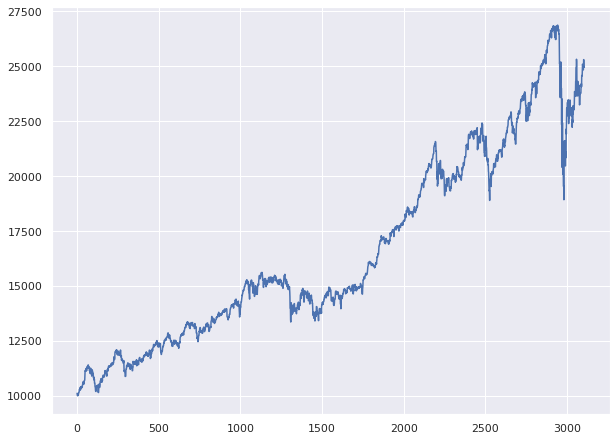

*-----Episode: 68, Reward:249.508344%-----*
Now we are at epoch 69


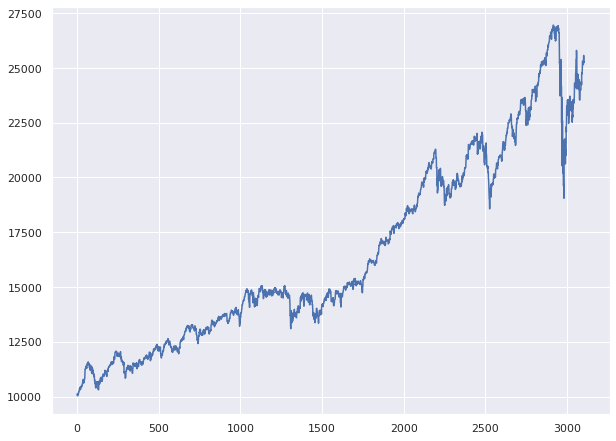

*-----Episode: 69, Reward:252.616783%-----*
Now we are at epoch 70


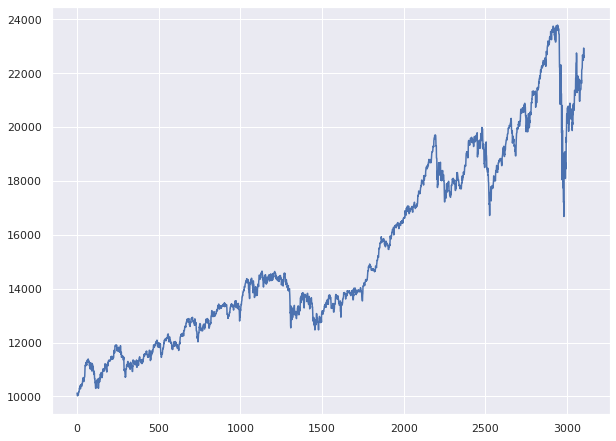

*-----Episode: 70, Reward:226.311961%-----*
Now we are at epoch 71


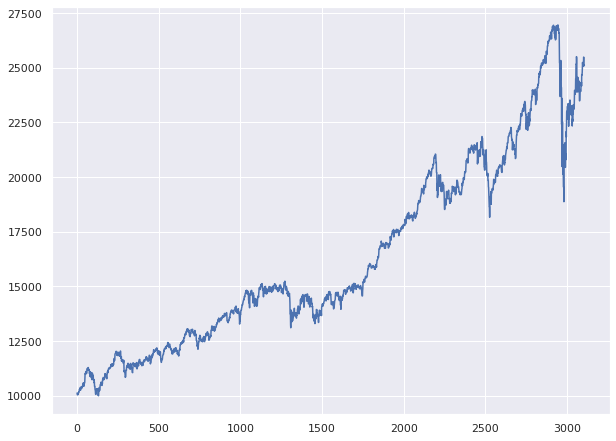

*-----Episode: 71, Reward:251.223132%-----*
Now we are at epoch 72


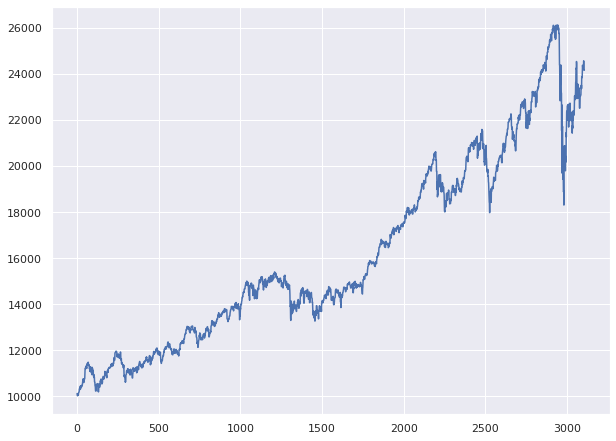

*-----Episode: 72, Reward:241.686594%-----*
Now we are at epoch 73


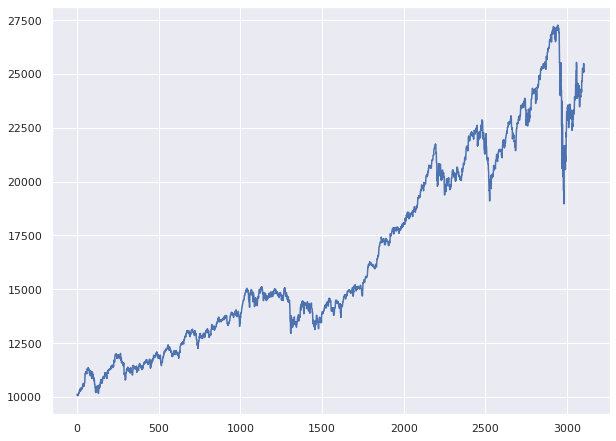

*-----Episode: 73, Reward:251.285489%-----*
Now we are at epoch 74


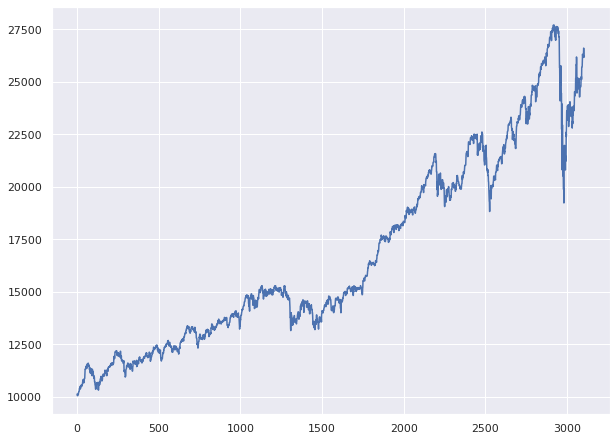

*-----Episode: 74, Reward:262.176631%-----*
Now we are at epoch 75


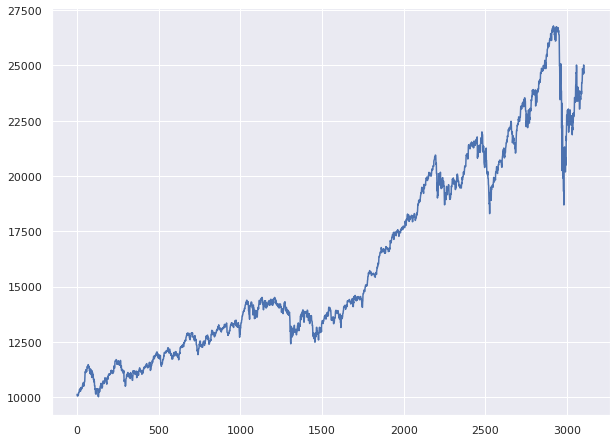

*-----Episode: 75, Reward:246.646139%-----*
Now we are at epoch 76


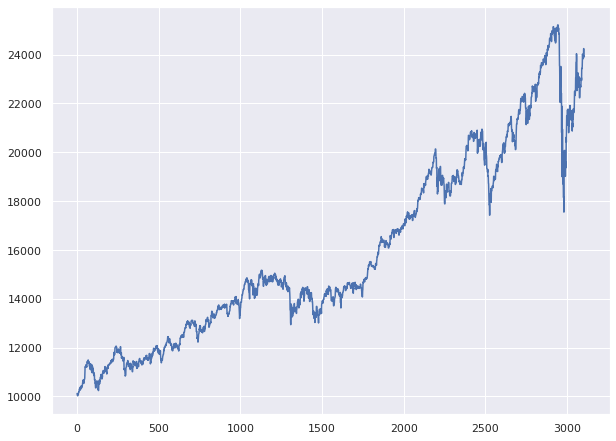

*-----Episode: 76, Reward:239.237954%-----*
Now we are at epoch 77


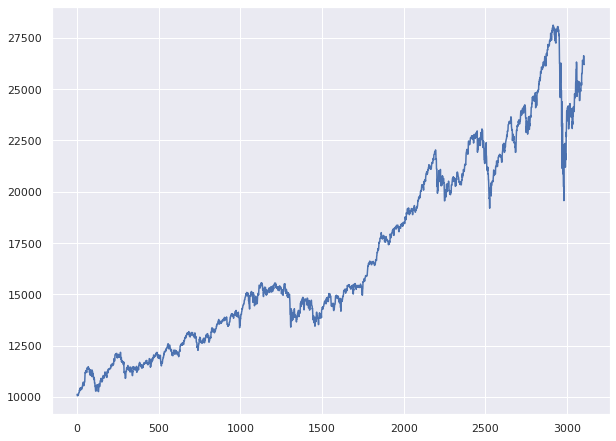

*-----Episode: 77, Reward:261.937315%-----*
Now we are at epoch 78


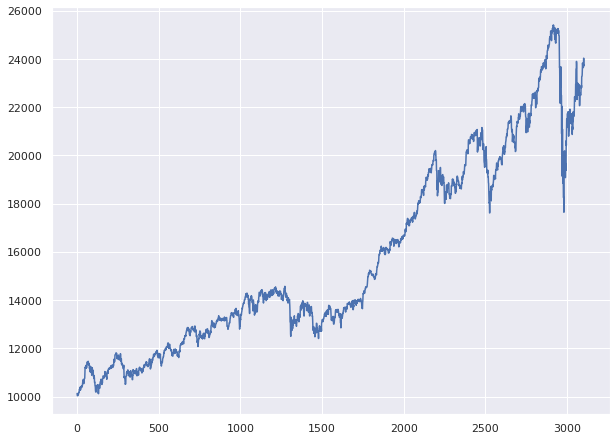

*-----Episode: 78, Reward:237.357017%-----*
Now we are at epoch 79


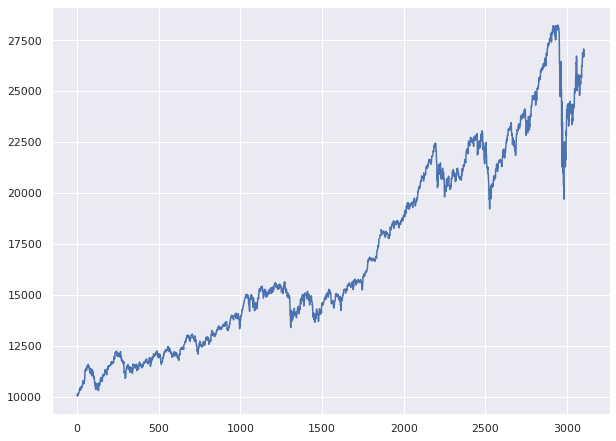

*-----Episode: 79, Reward:267.650271%-----*
Now we are at epoch 80


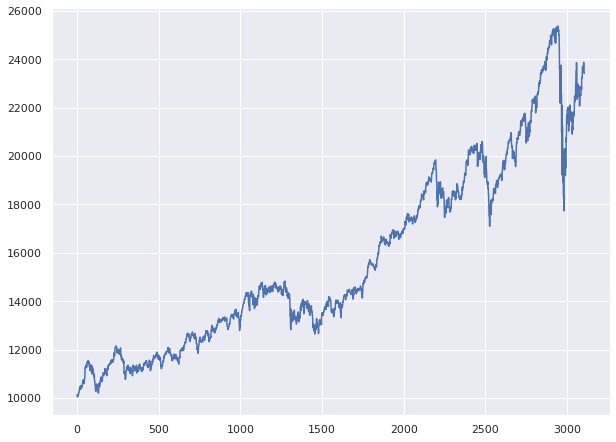

*-----Episode: 80, Reward:234.208975%-----*
Now we are at epoch 81


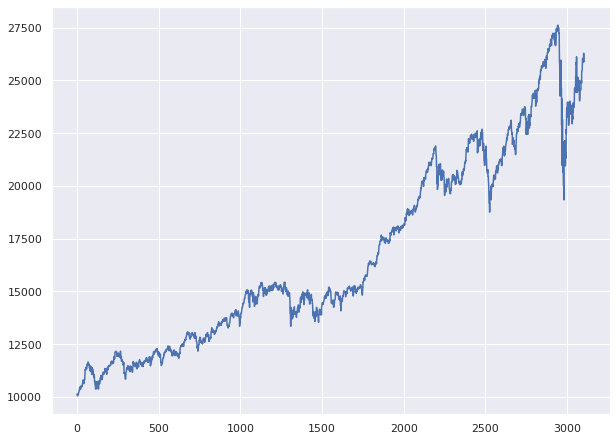

*-----Episode: 81, Reward:259.068349%-----*
Now we are at epoch 82


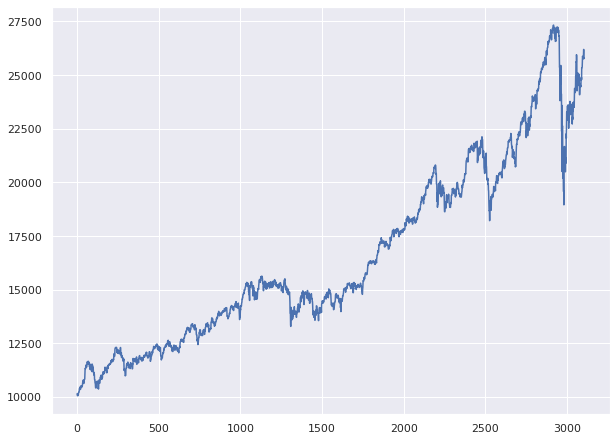

*-----Episode: 82, Reward:257.867111%-----*
Now we are at epoch 83


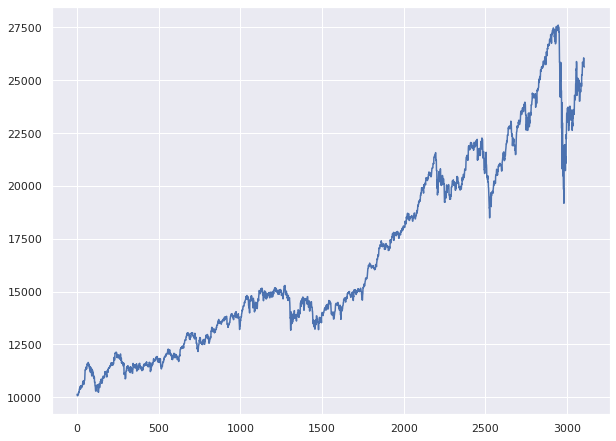

*-----Episode: 83, Reward:256.175976%-----*
Now we are at epoch 84


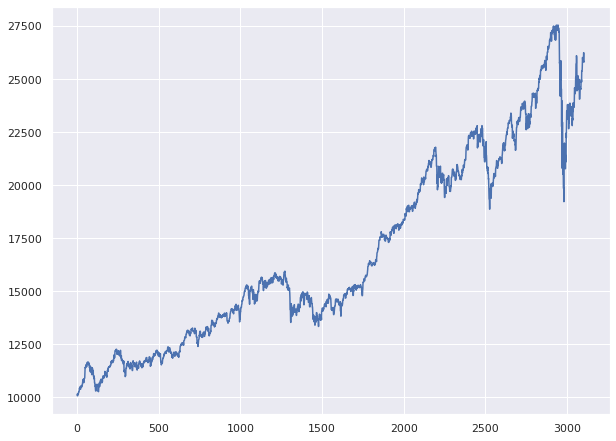

*-----Episode: 84, Reward:258.045108%-----*
Now we are at epoch 85


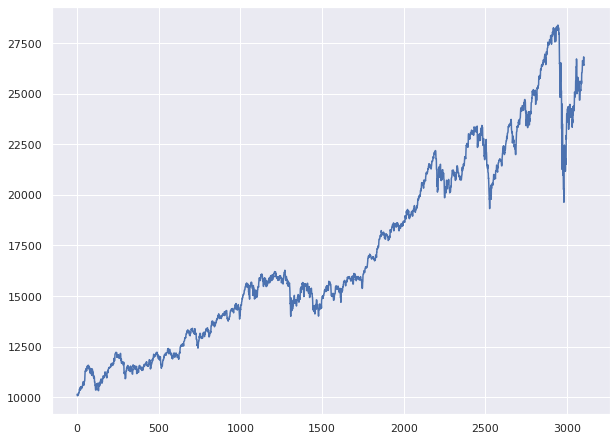

*-----Episode: 85, Reward:264.317548%-----*
Now we are at epoch 86


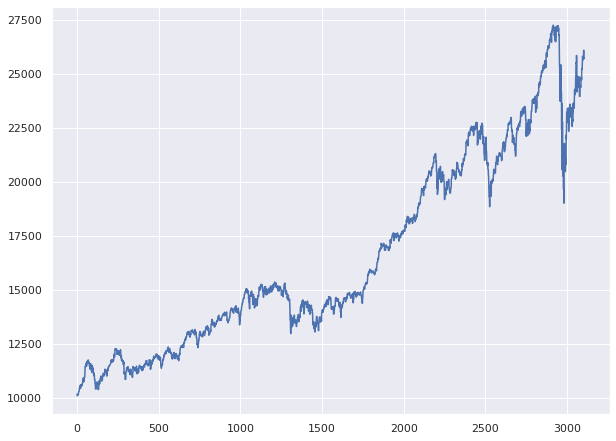

*-----Episode: 86, Reward:257.240843%-----*
Now we are at epoch 87


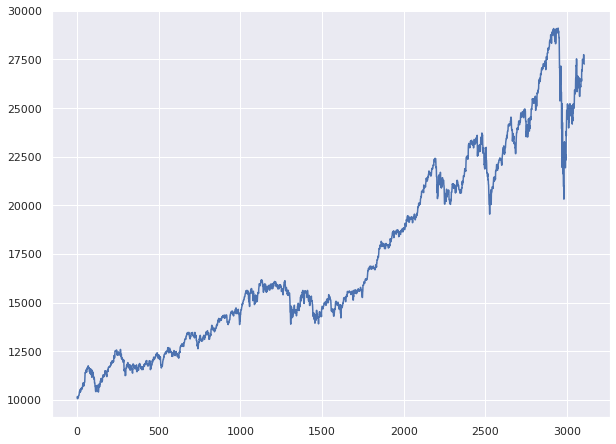

*-----Episode: 87, Reward:272.601041%-----*
Now we are at epoch 88


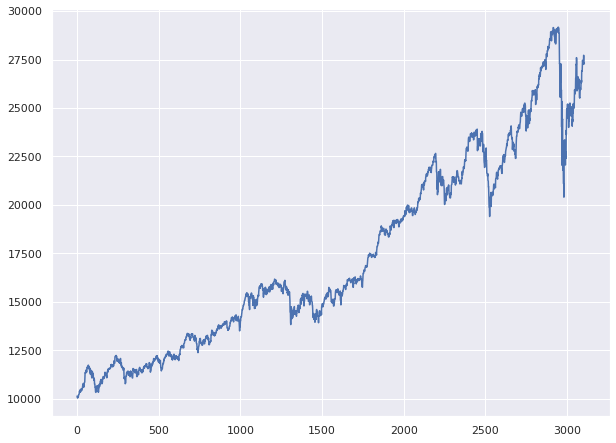

*-----Episode: 88, Reward:273.223505%-----*
Now we are at epoch 89


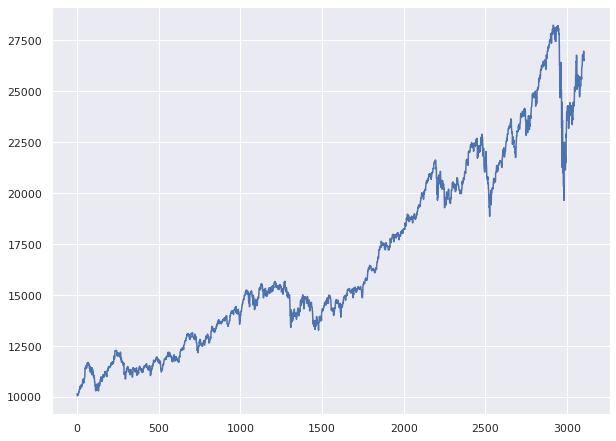

*-----Episode: 89, Reward:265.644549%-----*
Now we are at epoch 90


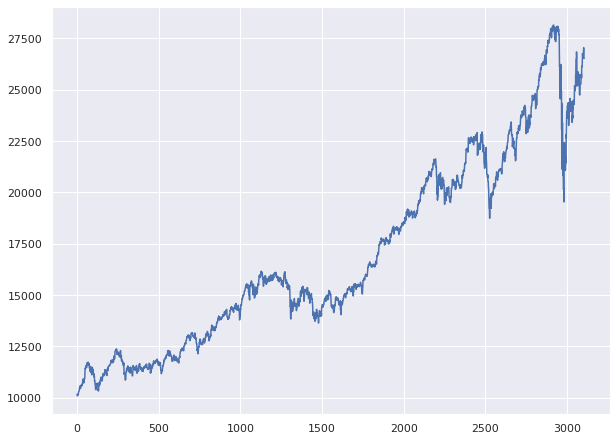

*-----Episode: 90, Reward:265.257780%-----*
Now we are at epoch 91


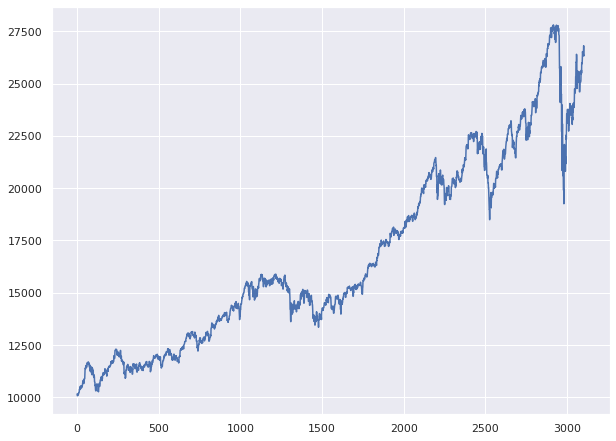

*-----Episode: 91, Reward:263.347878%-----*
Now we are at epoch 92


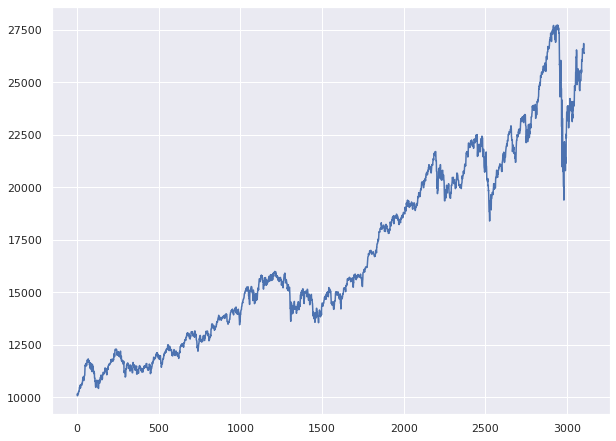

*-----Episode: 92, Reward:263.936228%-----*
Now we are at epoch 93


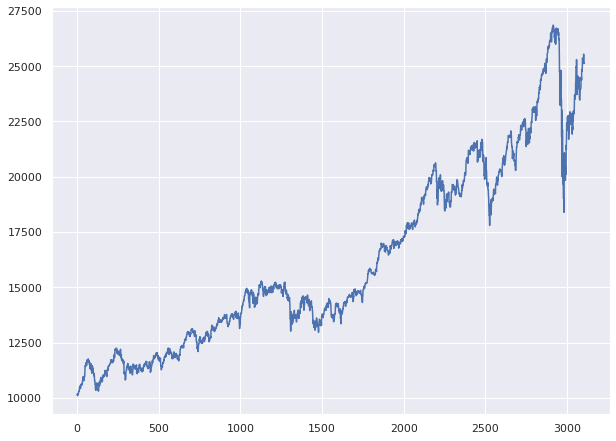

*-----Episode: 93, Reward:251.229855%-----*
Now we are at epoch 94


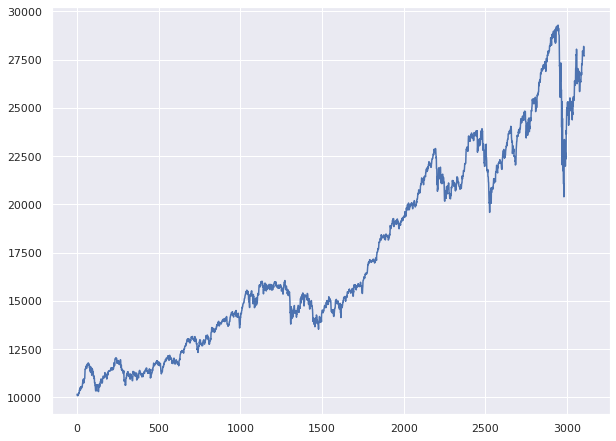

*-----Episode: 94, Reward:277.062474%-----*
Now we are at epoch 95


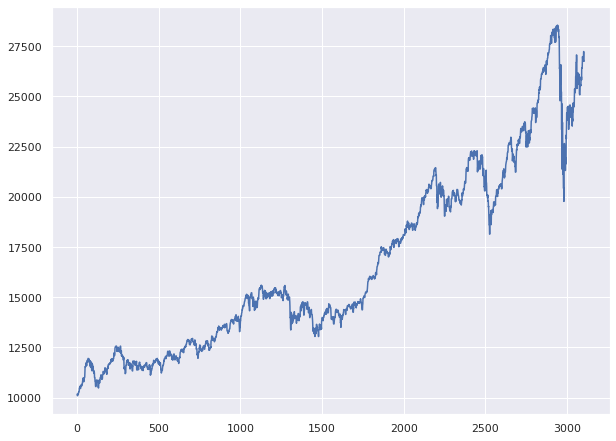

*-----Episode: 95, Reward:267.470261%-----*
Now we are at epoch 96


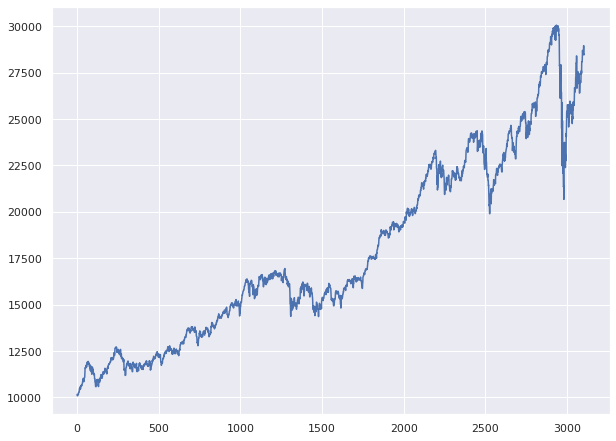

*-----Episode: 96, Reward:284.890667%-----*
Now we are at epoch 97


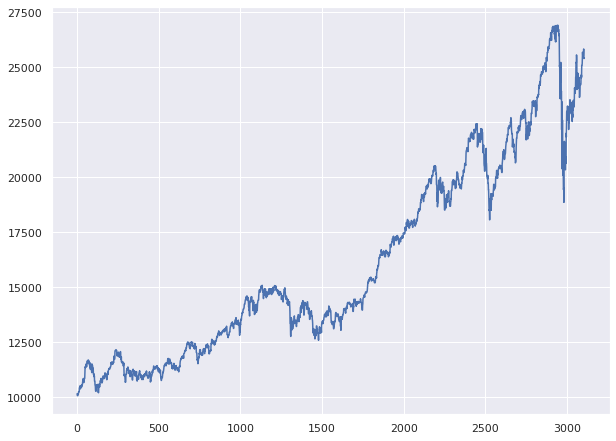

*-----Episode: 97, Reward:254.226218%-----*
Now we are at epoch 98


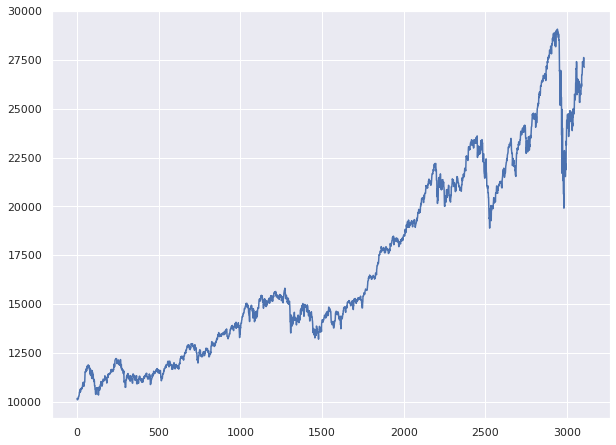

*-----Episode: 98, Reward:271.244917%-----*
Now we are at epoch 99


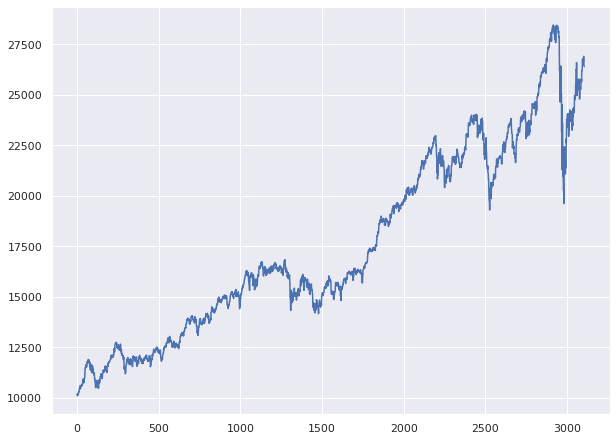

*-----Episode: 99, Reward:263.996779%-----*
Now we are at epoch 100


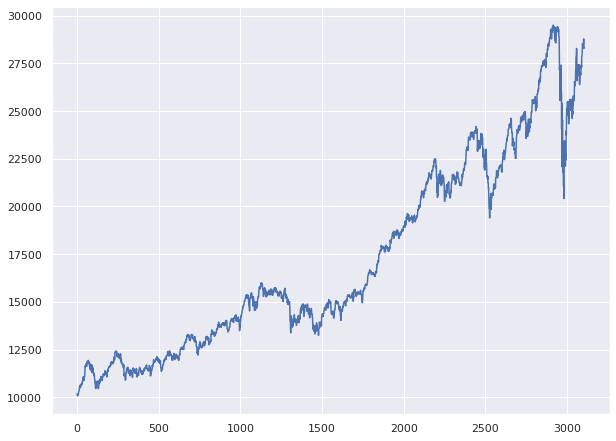

*-----Episode: 100, Reward:283.176242%-----*
Now we are at epoch 101


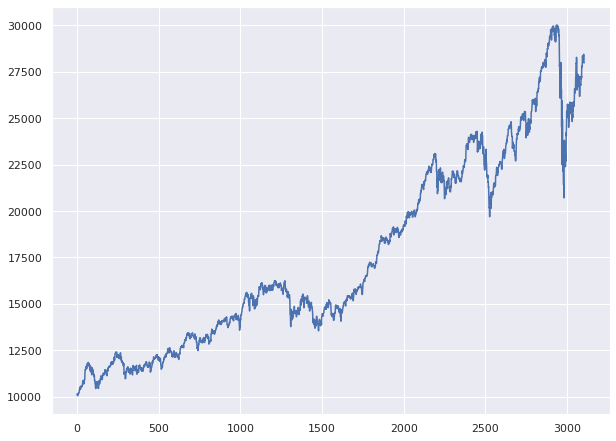

*-----Episode: 101, Reward:279.779435%-----*
Now we are at epoch 102


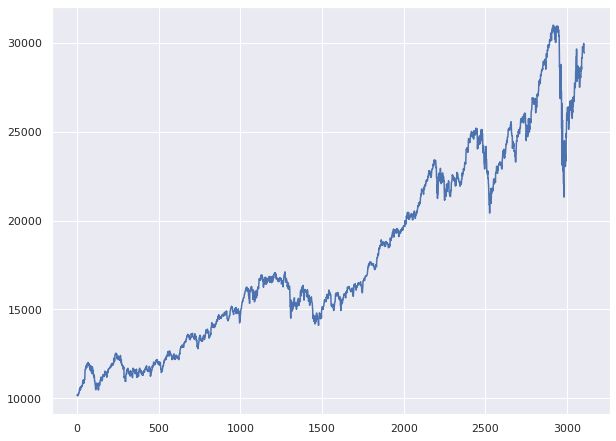

*-----Episode: 102, Reward:294.279273%-----*
Now we are at epoch 103


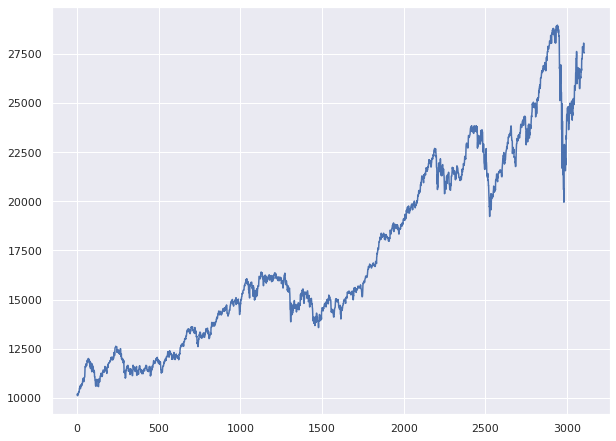

*-----Episode: 103, Reward:275.414133%-----*
Now we are at epoch 104


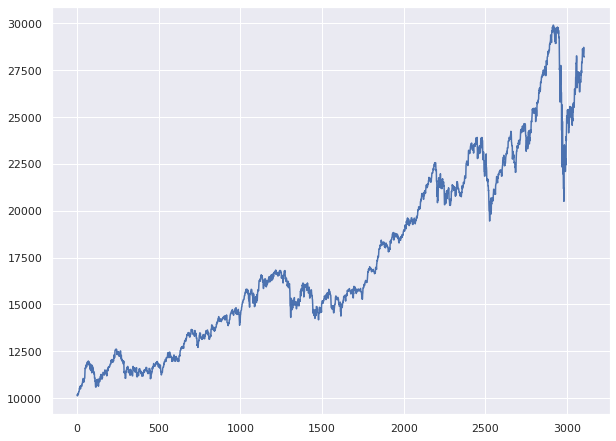

*-----Episode: 104, Reward:282.075277%-----*
Now we are at epoch 105


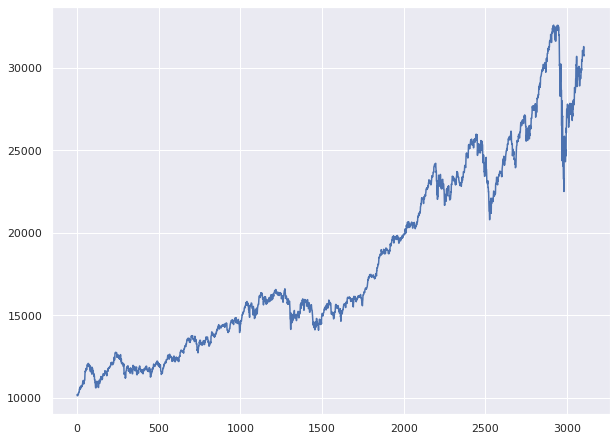

*-----Episode: 105, Reward:307.564044%-----*
Now we are at epoch 106


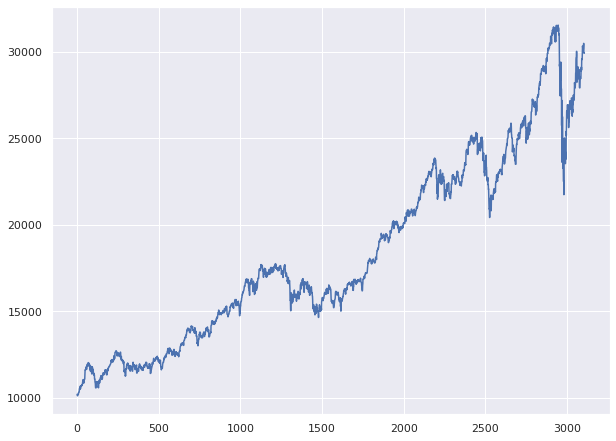

*-----Episode: 106, Reward:299.129160%-----*
Now we are at epoch 107


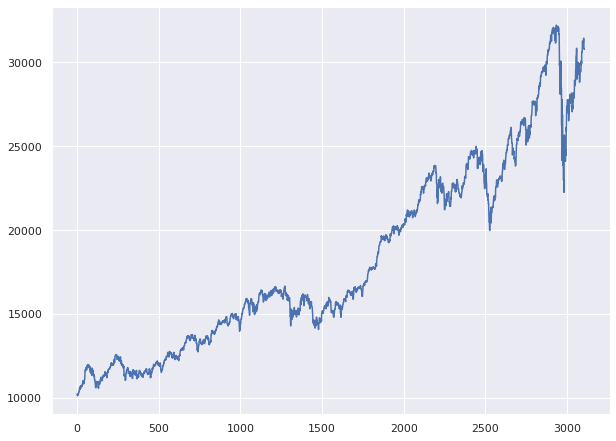

*-----Episode: 107, Reward:307.931920%-----*
Now we are at epoch 108


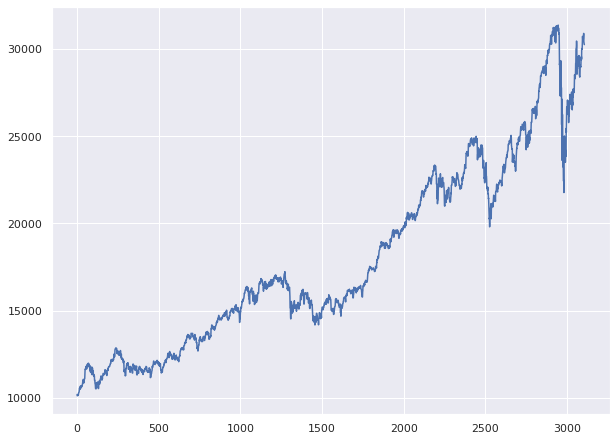

*-----Episode: 108, Reward:302.283906%-----*
Now we are at epoch 109


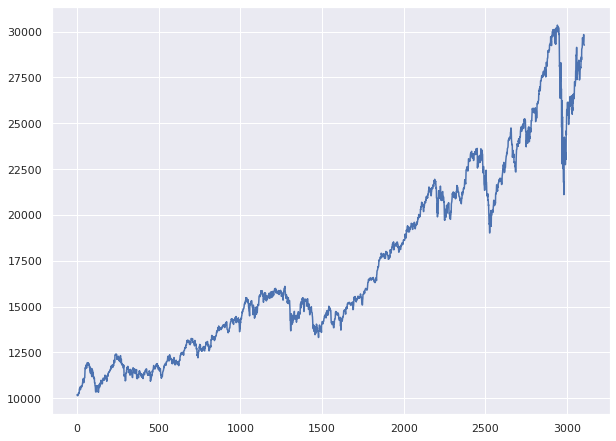

*-----Episode: 109, Reward:292.617330%-----*
Now we are at epoch 110


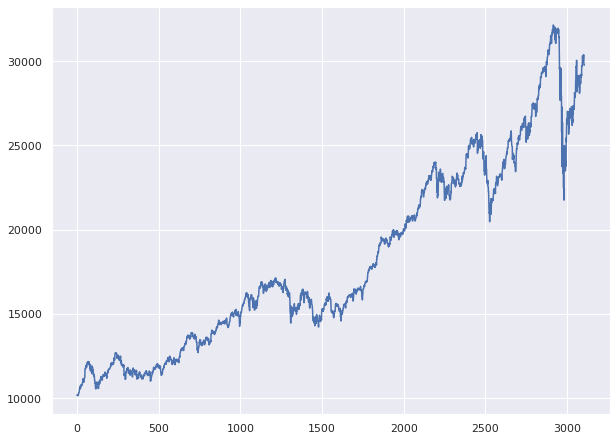

*-----Episode: 110, Reward:297.606616%-----*
Now we are at epoch 111


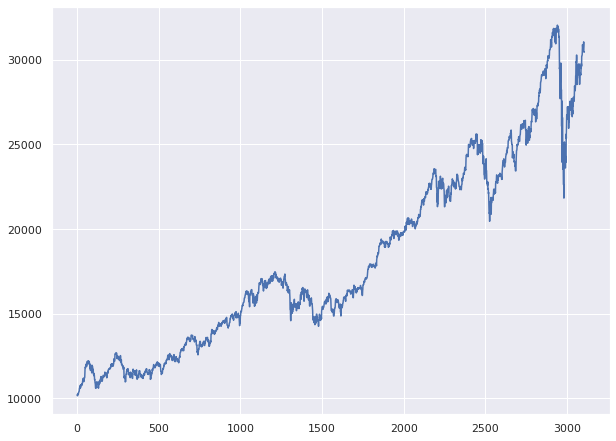

*-----Episode: 111, Reward:304.535056%-----*
Now we are at epoch 112


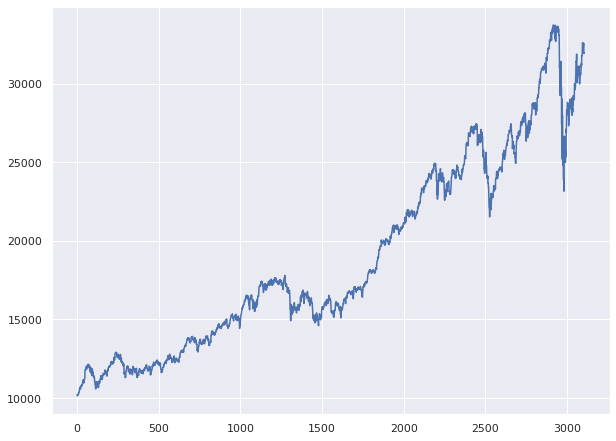

*-----Episode: 112, Reward:319.488413%-----*
Now we are at epoch 113


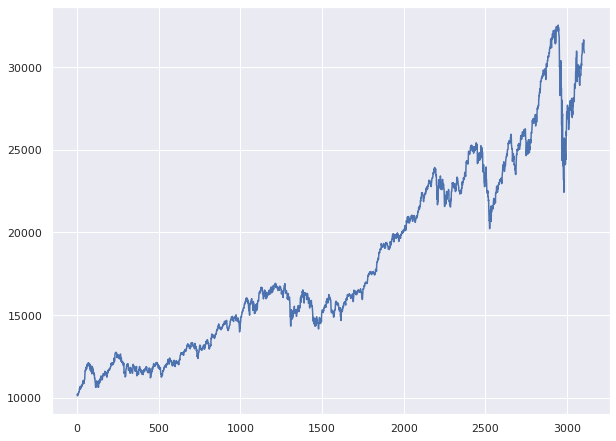

*-----Episode: 113, Reward:308.780569%-----*
Now we are at epoch 114


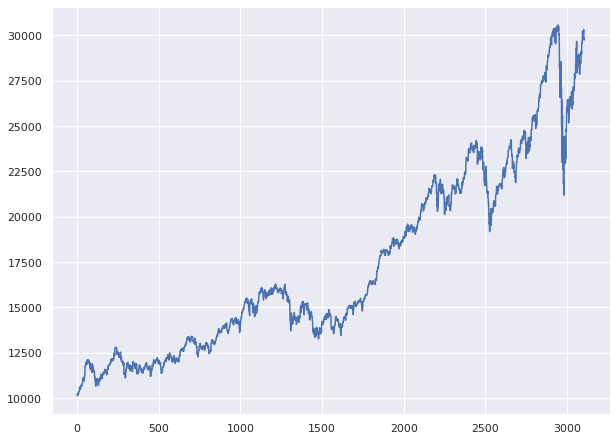

*-----Episode: 114, Reward:298.297187%-----*
Now we are at epoch 115


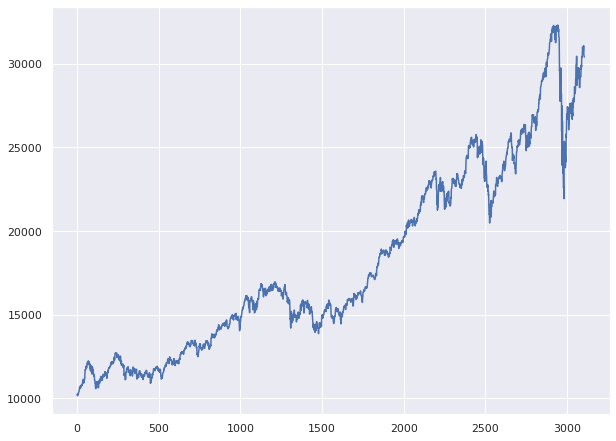

*-----Episode: 115, Reward:304.009625%-----*
Now we are at epoch 116


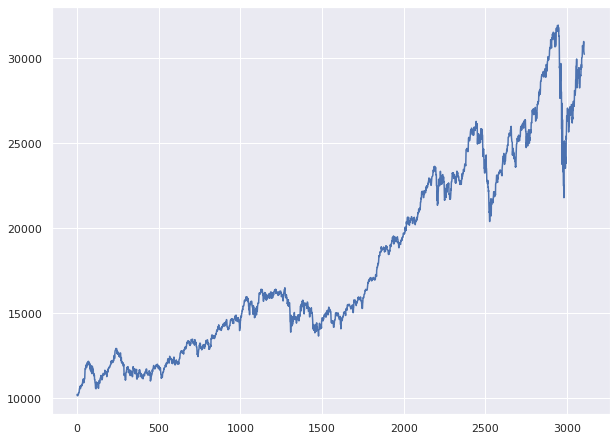

*-----Episode: 116, Reward:302.335298%-----*
Now we are at epoch 117


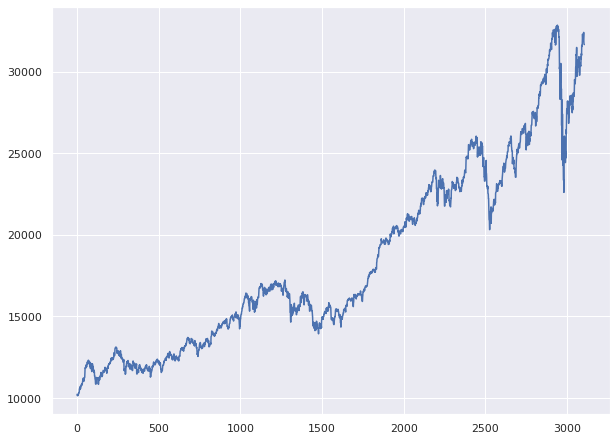

*-----Episode: 117, Reward:316.609704%-----*
Now we are at epoch 118


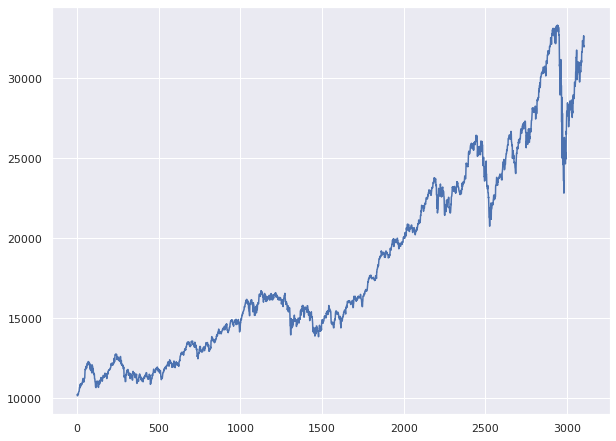

*-----Episode: 118, Reward:320.181557%-----*
Now we are at epoch 119


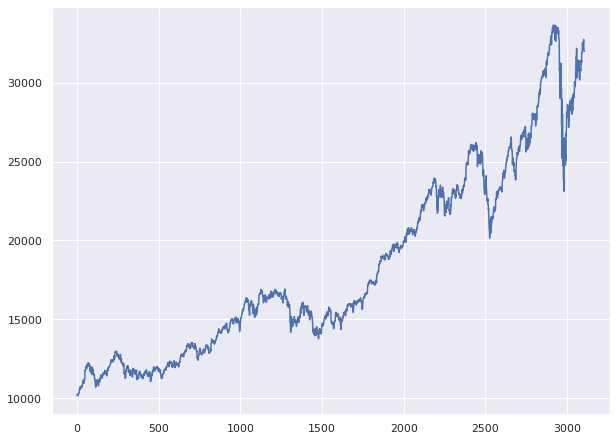

*-----Episode: 119, Reward:319.989123%-----*
Now we are at epoch 120


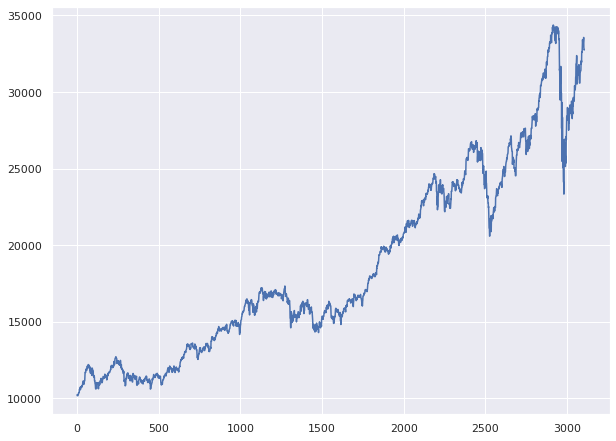

*-----Episode: 120, Reward:327.668543%-----*
Now we are at epoch 121


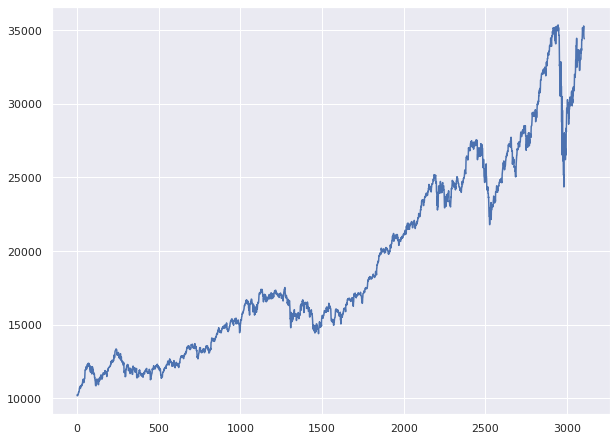

*-----Episode: 121, Reward:344.021490%-----*
Now we are at epoch 122


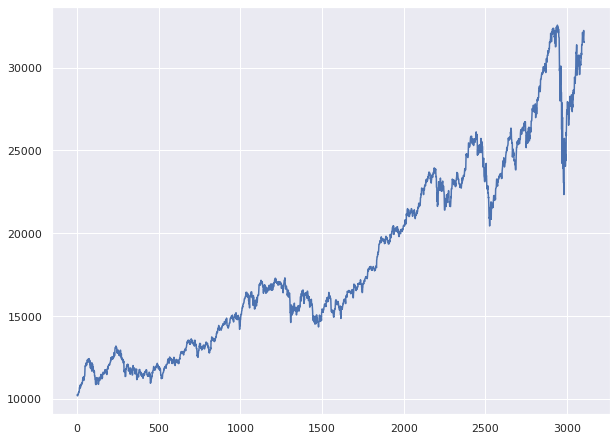

*-----Episode: 122, Reward:315.245609%-----*
Now we are at epoch 123


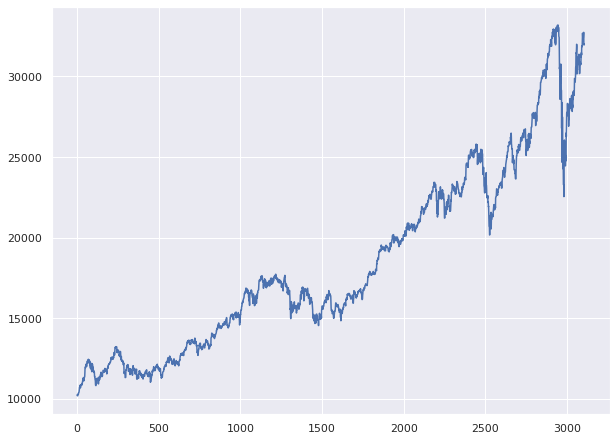

*-----Episode: 123, Reward:320.117037%-----*
Now we are at epoch 124


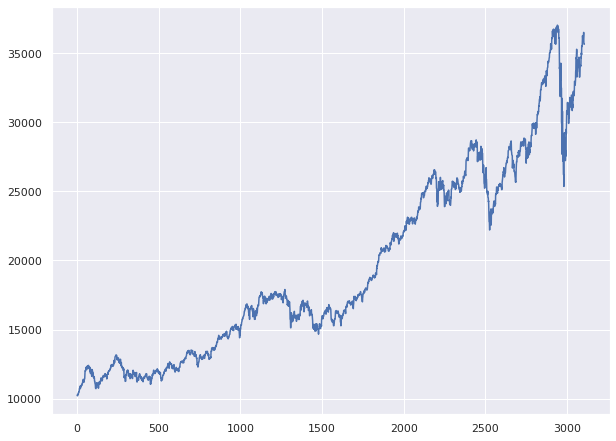

*-----Episode: 124, Reward:356.605114%-----*
Now we are at epoch 125


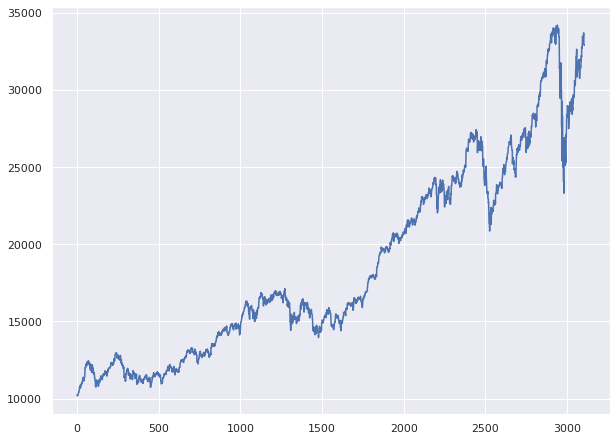

*-----Episode: 125, Reward:329.077155%-----*
Now we are at epoch 126


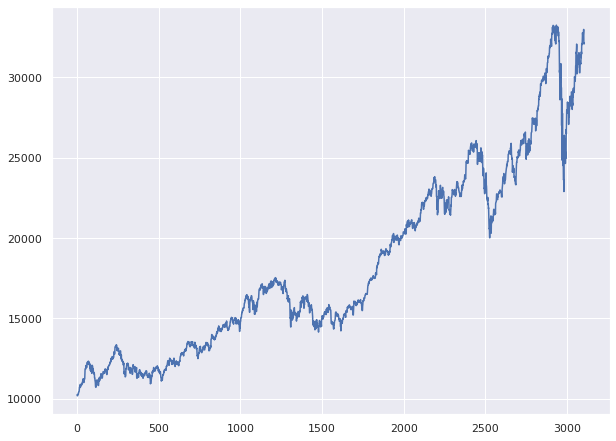

*-----Episode: 126, Reward:321.103148%-----*
Now we are at epoch 127


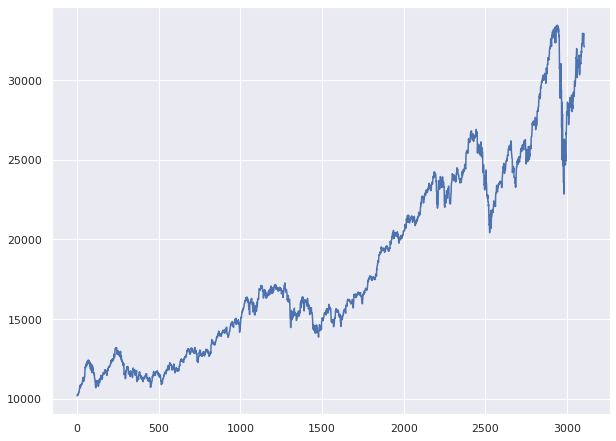

*-----Episode: 127, Reward:320.762748%-----*
Now we are at epoch 128


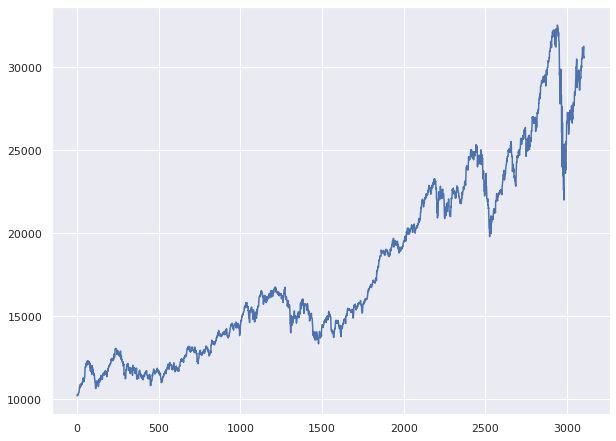

*-----Episode: 128, Reward:305.877478%-----*
Now we are at epoch 129


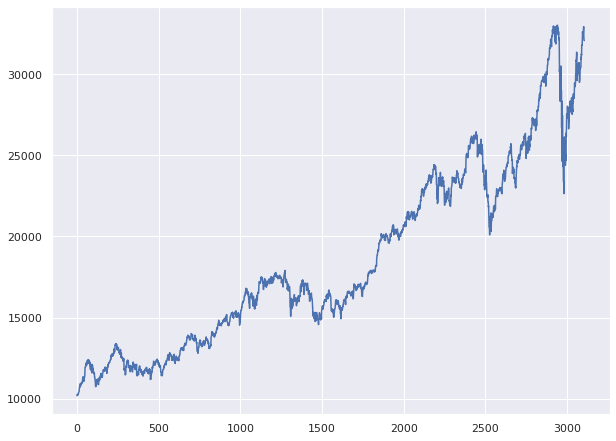

*-----Episode: 129, Reward:320.799389%-----*
Now we are at epoch 130


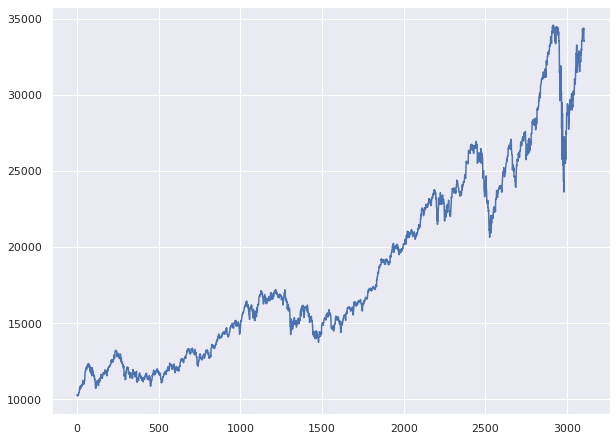

*-----Episode: 130, Reward:335.365140%-----*
Now we are at epoch 131


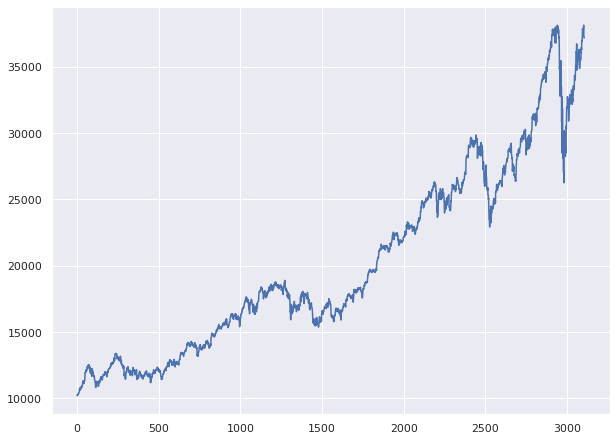

*-----Episode: 131, Reward:371.924124%-----*
Now we are at epoch 132


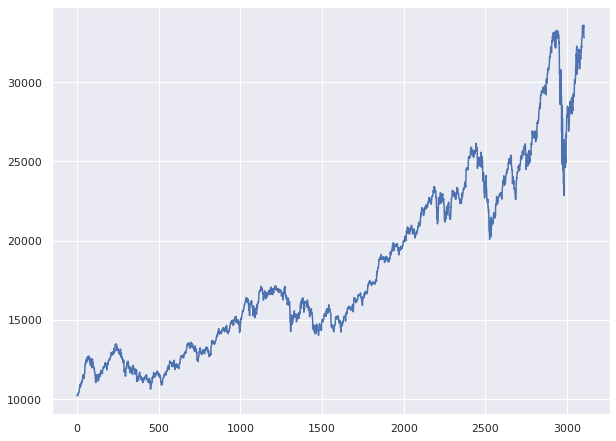

*-----Episode: 132, Reward:328.082227%-----*
Now we are at epoch 133


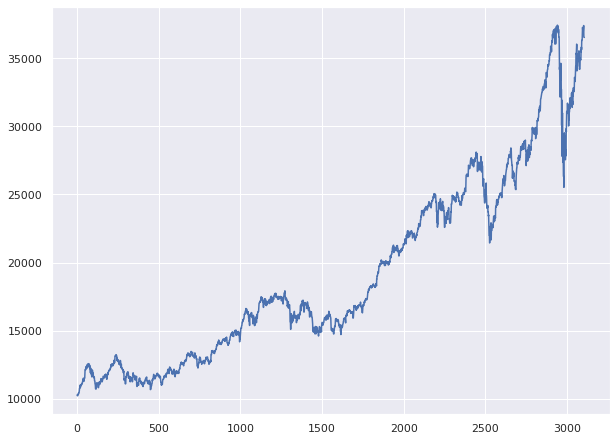

*-----Episode: 133, Reward:365.111024%-----*
Now we are at epoch 134


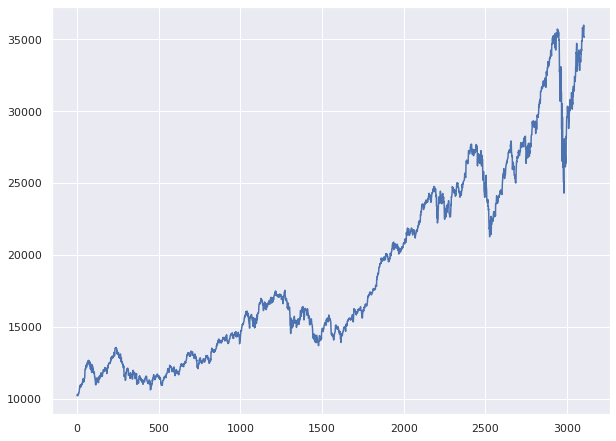

*-----Episode: 134, Reward:351.605113%-----*
Now we are at epoch 135


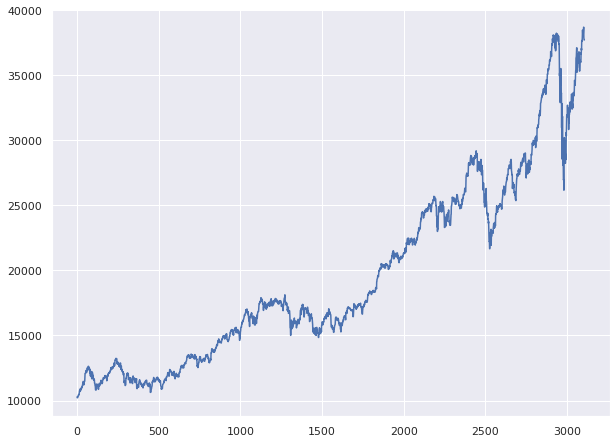

*-----Episode: 135, Reward:377.220862%-----*
Now we are at epoch 136


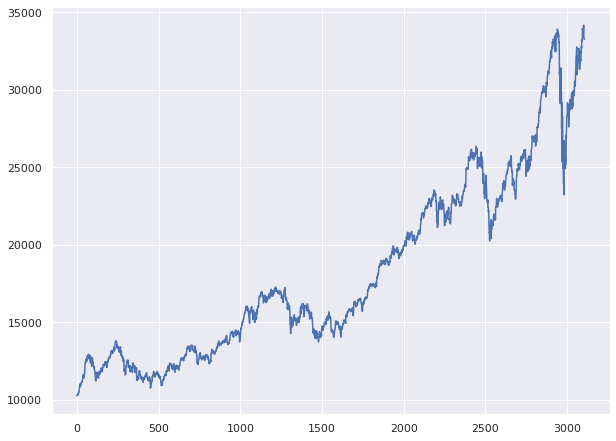

*-----Episode: 136, Reward:332.619494%-----*
Now we are at epoch 137


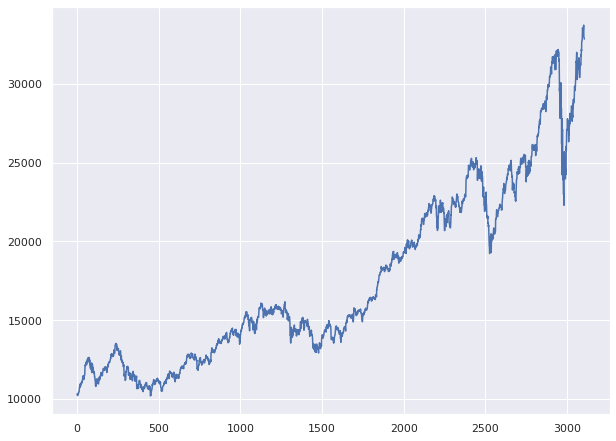

*-----Episode: 137, Reward:328.439371%-----*
Now we are at epoch 138


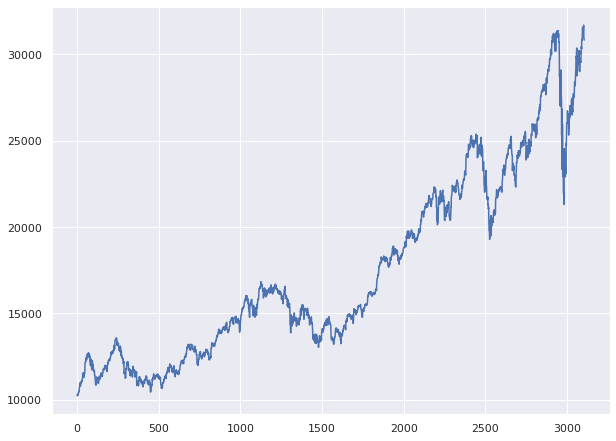

*-----Episode: 138, Reward:308.152524%-----*
Now we are at epoch 139


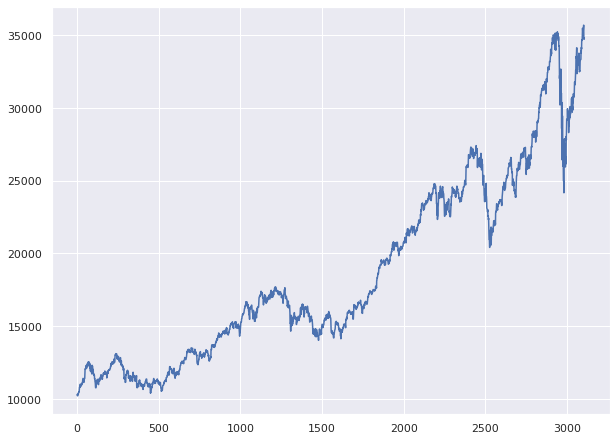

*-----Episode: 139, Reward:348.156834%-----*
Now we are at epoch 140


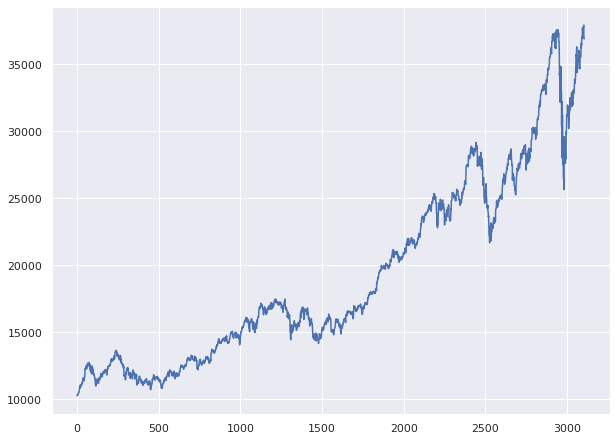

*-----Episode: 140, Reward:369.066062%-----*
Now we are at epoch 141


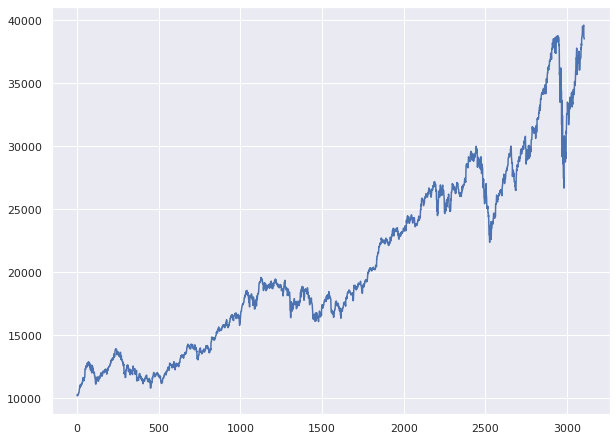

*-----Episode: 141, Reward:385.354458%-----*
Now we are at epoch 142


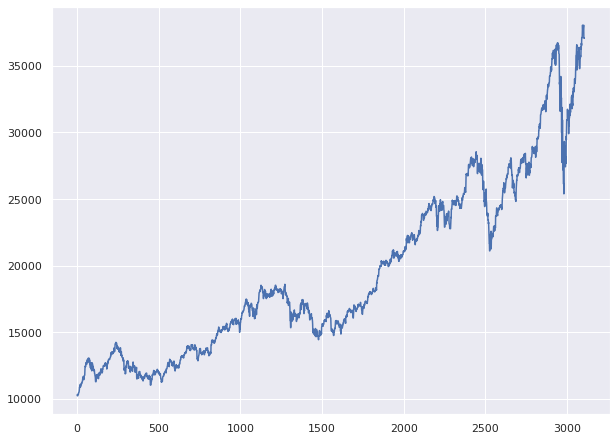

*-----Episode: 142, Reward:370.942582%-----*
Now we are at epoch 143


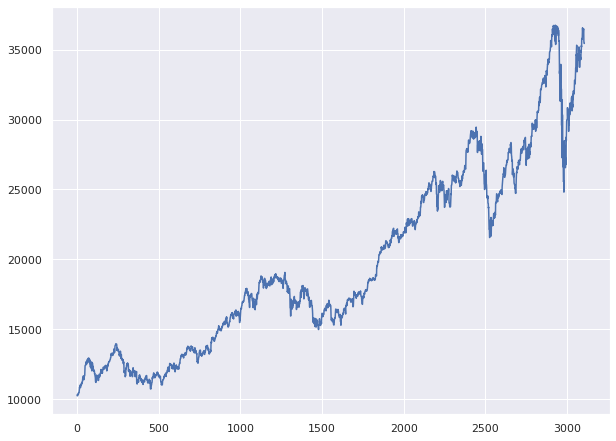

*-----Episode: 143, Reward:354.478090%-----*
Now we are at epoch 144


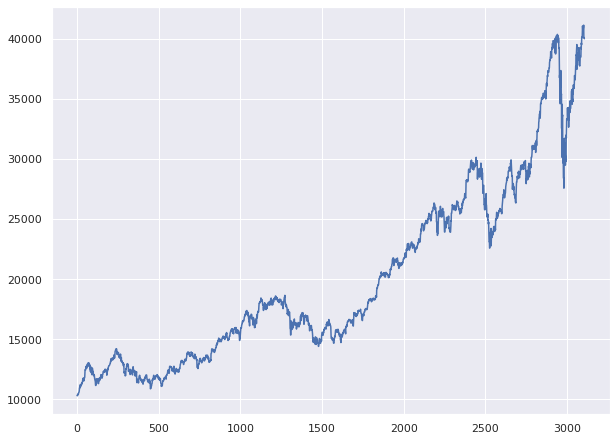

*-----Episode: 144, Reward:399.992797%-----*
Now we are at epoch 145


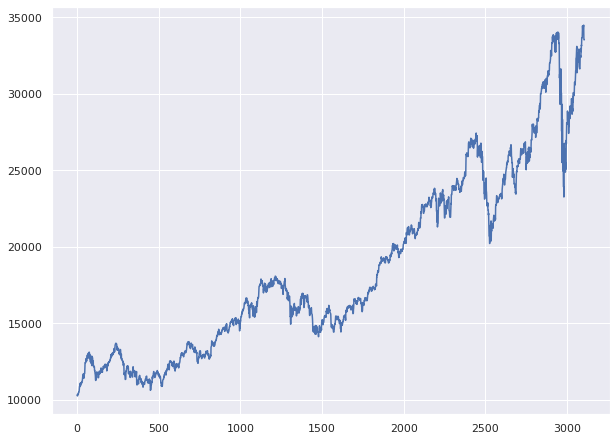

*-----Episode: 145, Reward:335.454343%-----*
Now we are at epoch 146


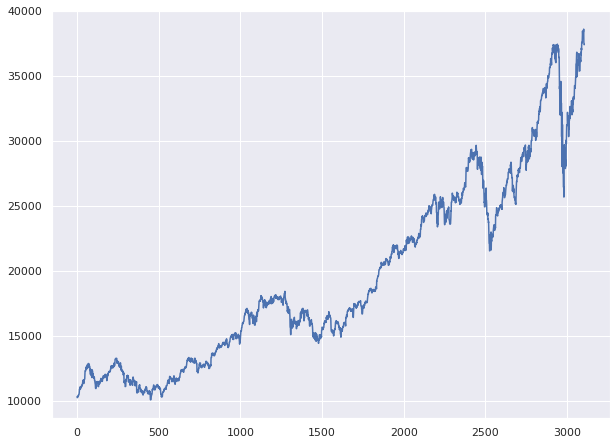

*-----Episode: 146, Reward:374.276743%-----*
Now we are at epoch 147


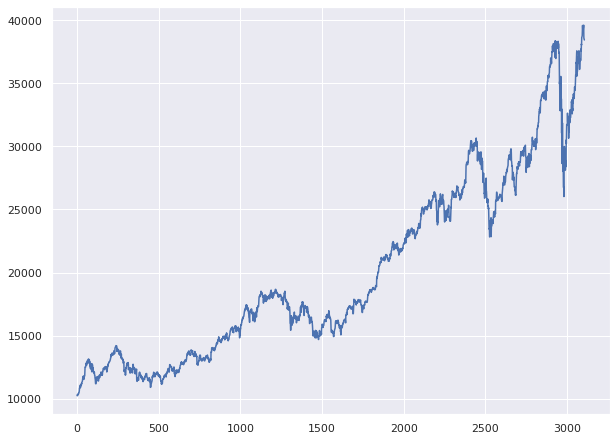

*-----Episode: 147, Reward:384.234563%-----*
Now we are at epoch 148


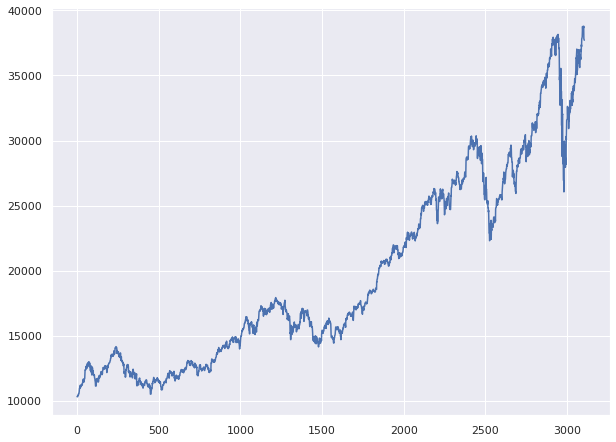

*-----Episode: 148, Reward:377.105053%-----*
Now we are at epoch 149


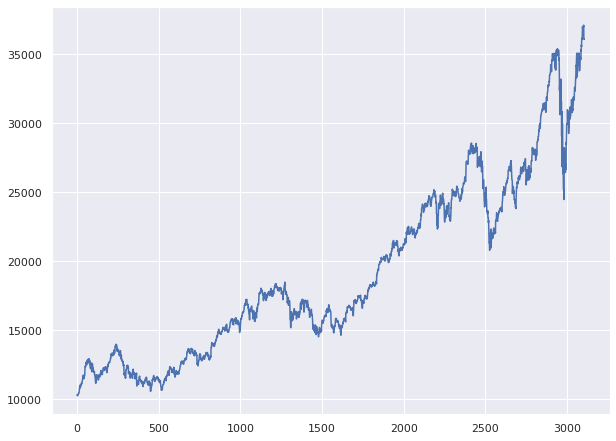

*-----Episode: 149, Reward:360.721323%-----*
Now we are at epoch 150


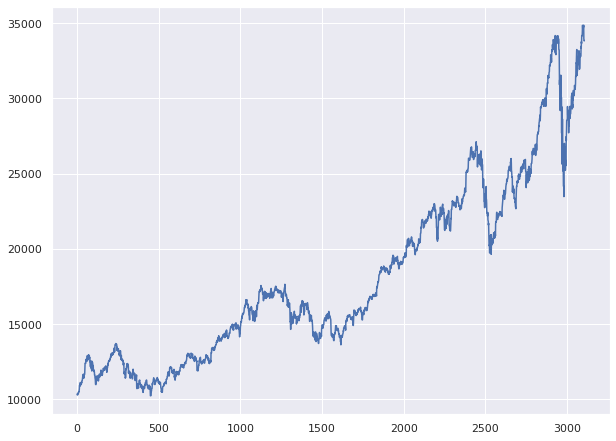

*-----Episode: 150, Reward:338.540251%-----*
Now we are at epoch 151


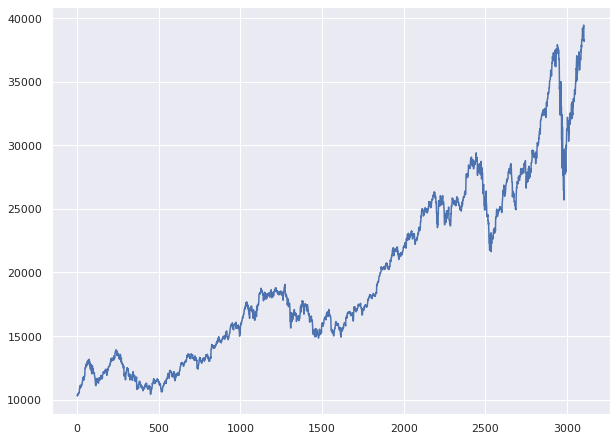

*-----Episode: 151, Reward:382.651276%-----*
Now we are at epoch 152


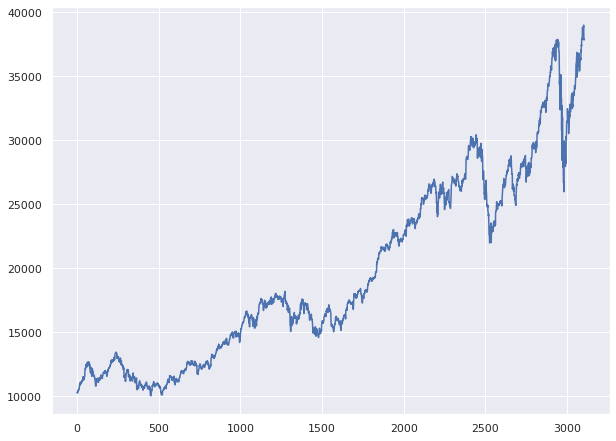

*-----Episode: 152, Reward:378.964533%-----*
Now we are at epoch 153


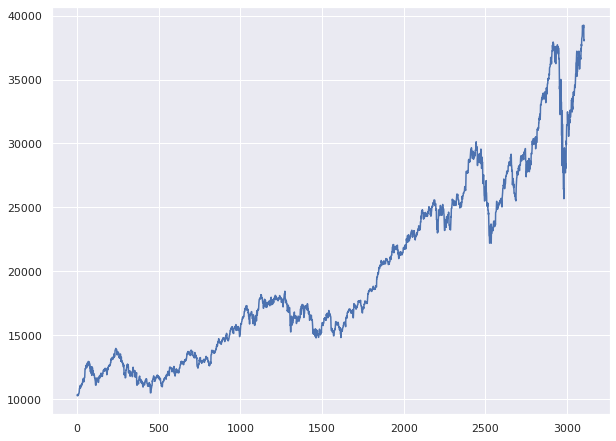

*-----Episode: 153, Reward:380.821853%-----*
Now we are at epoch 154


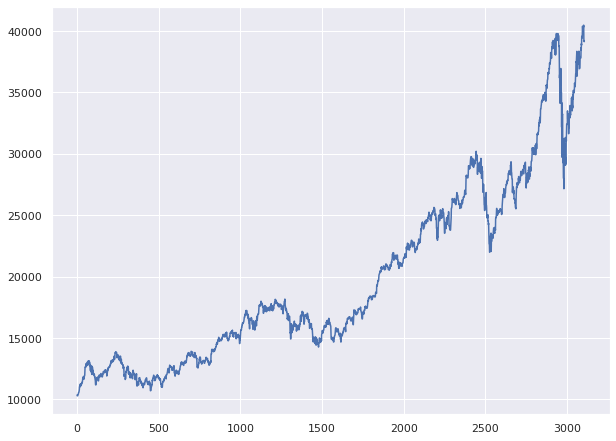

*-----Episode: 154, Reward:392.073570%-----*
Now we are at epoch 155


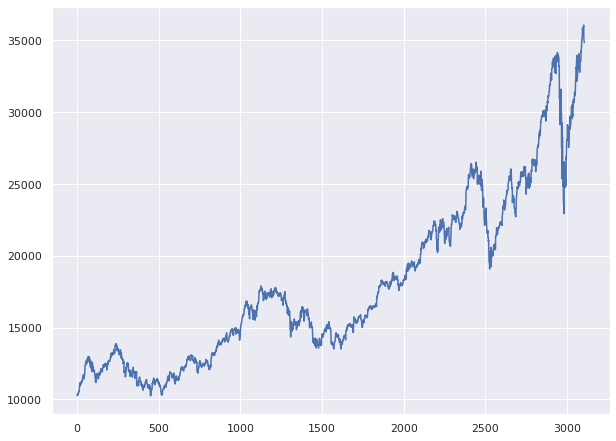

*-----Episode: 155, Reward:348.334560%-----*
Now we are at epoch 156


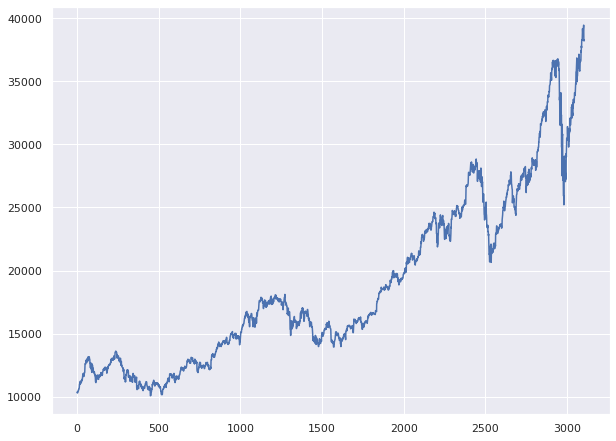

*-----Episode: 156, Reward:382.979069%-----*
Now we are at epoch 157


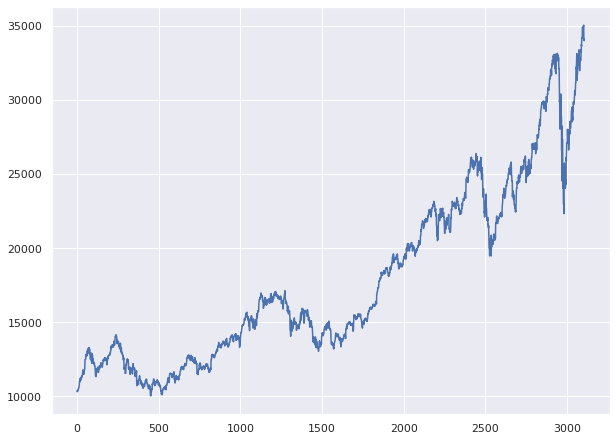

*-----Episode: 157, Reward:340.922203%-----*
Now we are at epoch 158


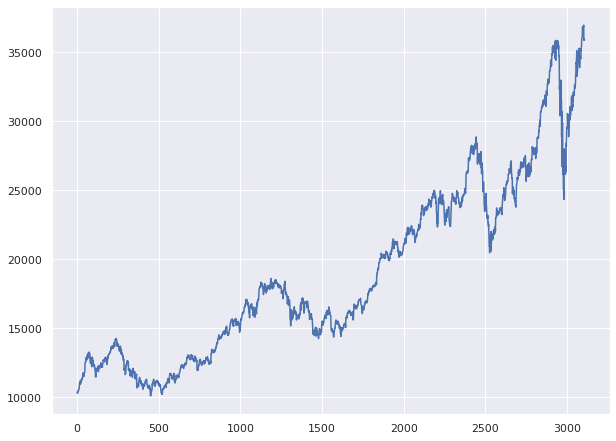

*-----Episode: 158, Reward:358.923832%-----*
Now we are at epoch 159


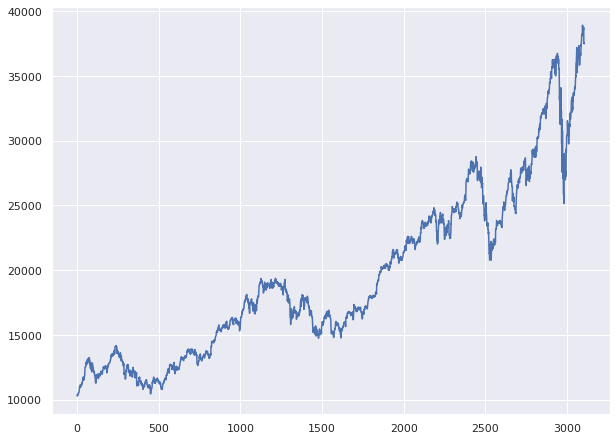

*-----Episode: 159, Reward:375.753935%-----*
Now we are at epoch 160


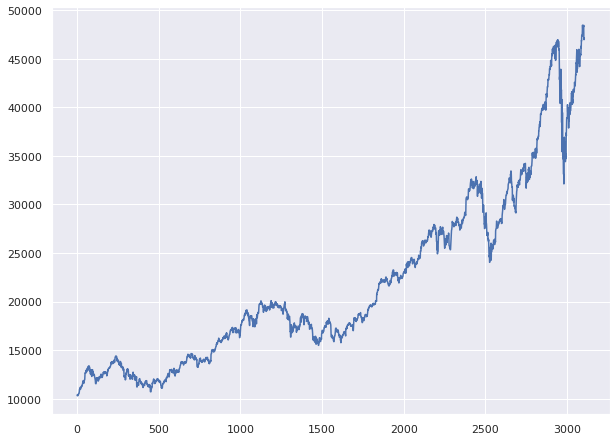

*-----Episode: 160, Reward:471.505209%-----*
Now we are at epoch 161


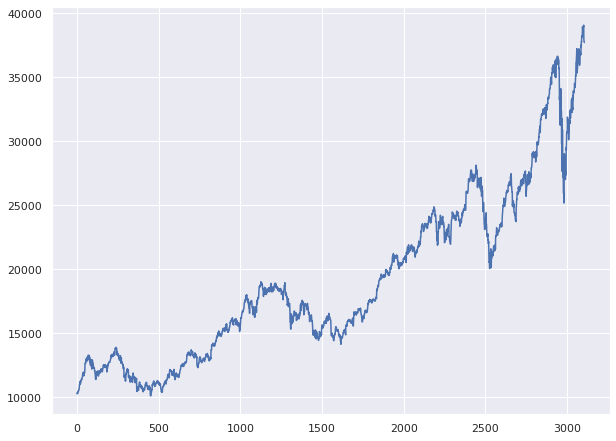

*-----Episode: 161, Reward:376.976780%-----*
Now we are at epoch 162


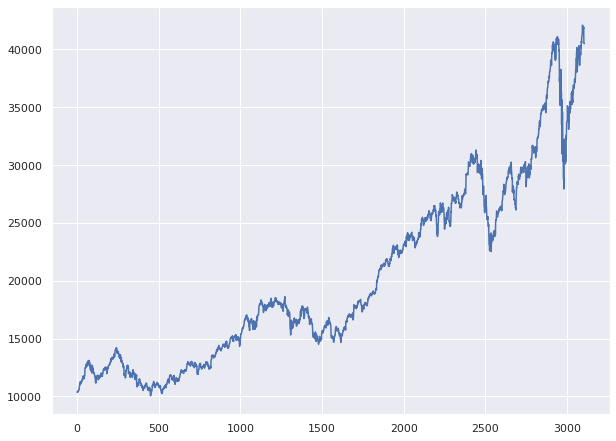

*-----Episode: 162, Reward:404.843315%-----*
Now we are at epoch 163


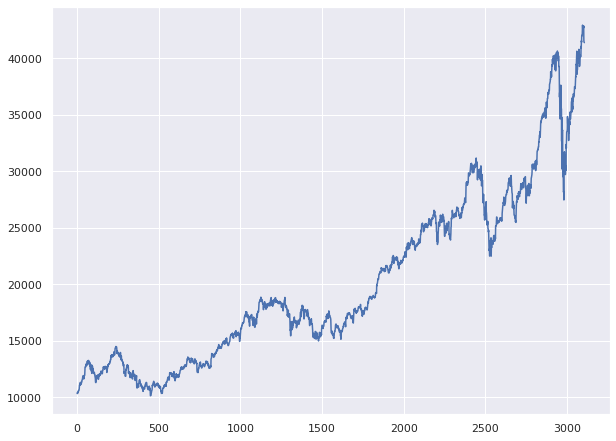

*-----Episode: 163, Reward:413.610456%-----*
Now we are at epoch 164


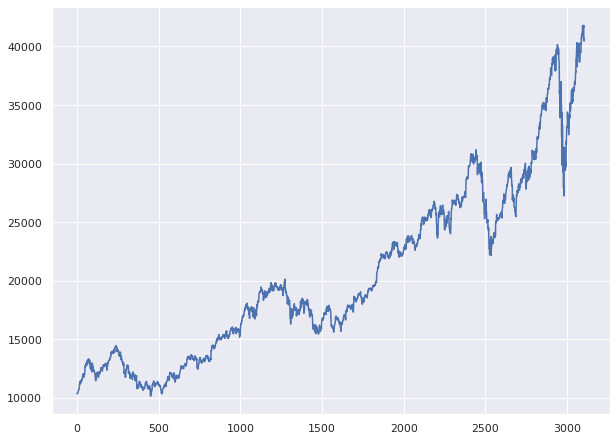

*-----Episode: 164, Reward:406.210870%-----*
Now we are at epoch 165


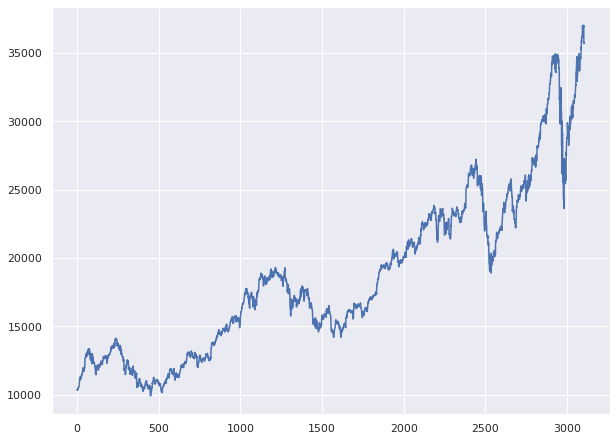

*-----Episode: 165, Reward:357.483473%-----*
Now we are at epoch 166


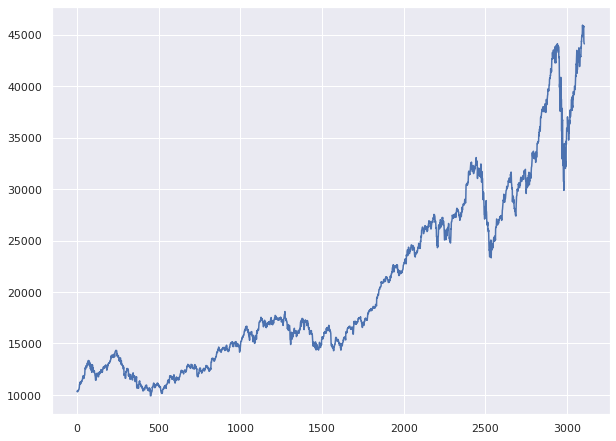

*-----Episode: 166, Reward:441.174945%-----*
Now we are at epoch 167


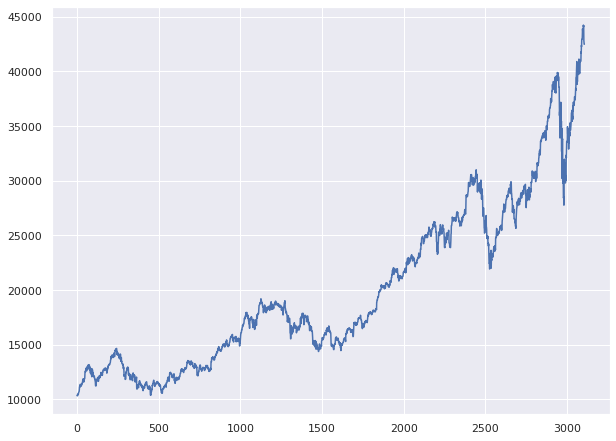

*-----Episode: 167, Reward:424.919569%-----*
Now we are at epoch 168


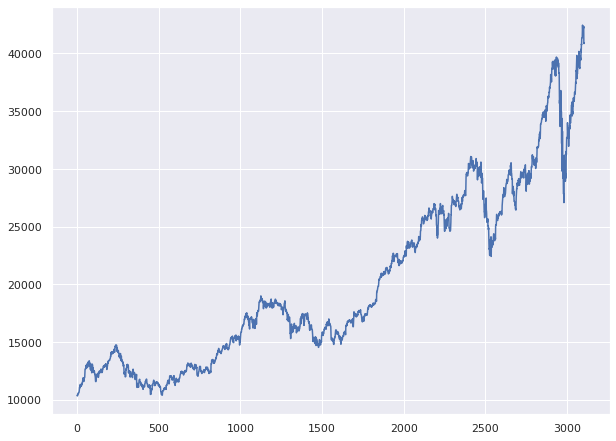

*-----Episode: 168, Reward:409.102999%-----*
Now we are at epoch 169


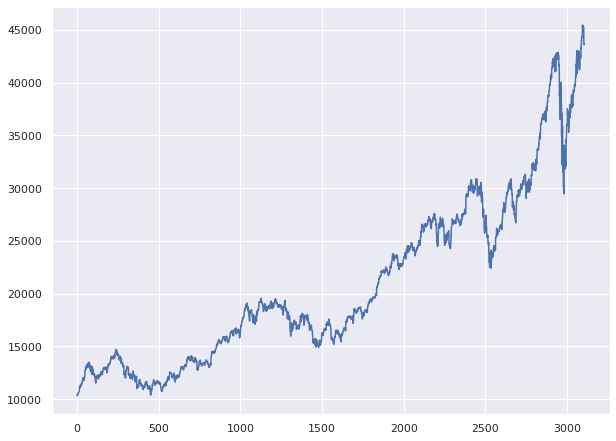

*-----Episode: 169, Reward:436.196069%-----*
Now we are at epoch 170


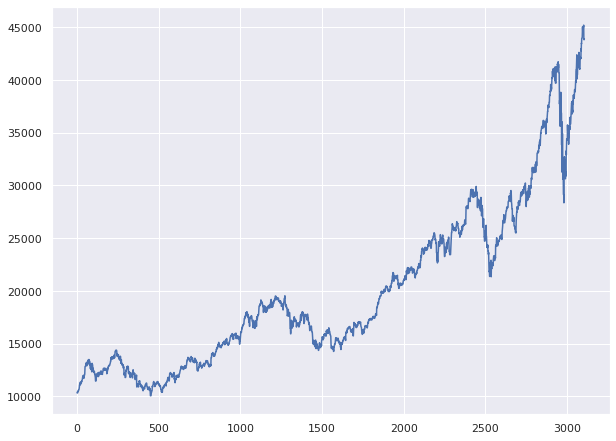

*-----Episode: 170, Reward:439.198411%-----*
Now we are at epoch 171


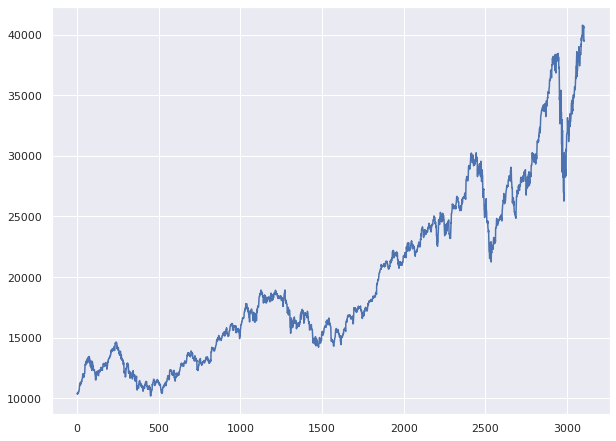

*-----Episode: 171, Reward:395.096260%-----*
Now we are at epoch 172


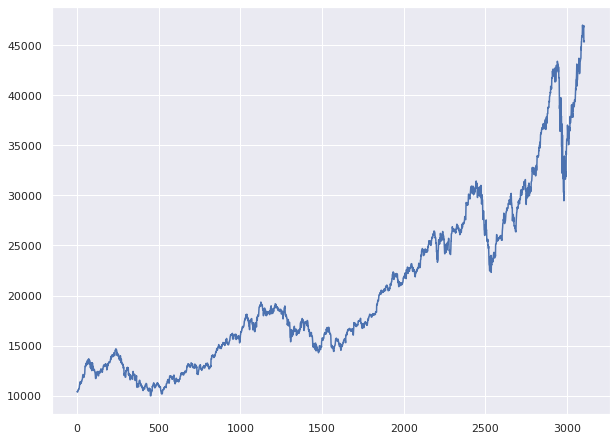

*-----Episode: 172, Reward:454.284233%-----*
Now we are at epoch 173


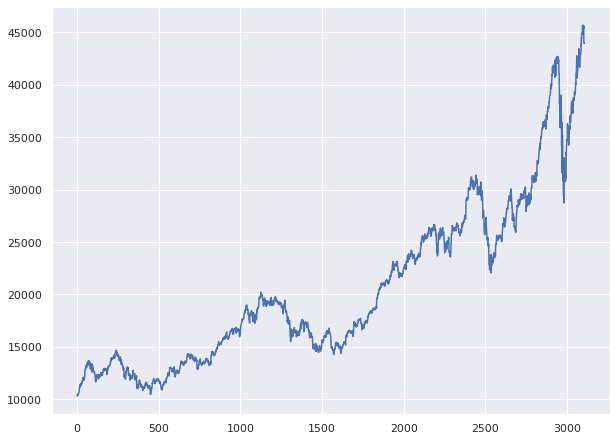

*-----Episode: 173, Reward:440.171202%-----*
Now we are at epoch 174


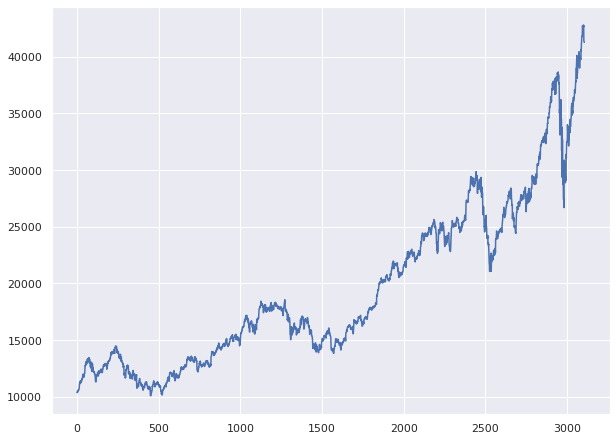

*-----Episode: 174, Reward:412.631308%-----*
Now we are at epoch 175


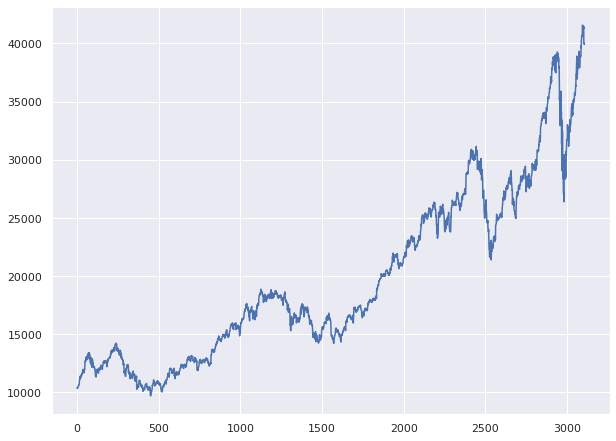

*-----Episode: 175, Reward:399.015356%-----*
Now we are at epoch 176


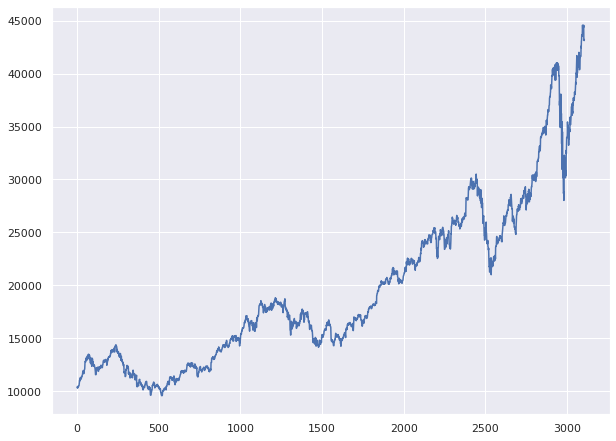

*-----Episode: 176, Reward:432.205988%-----*
Now we are at epoch 177


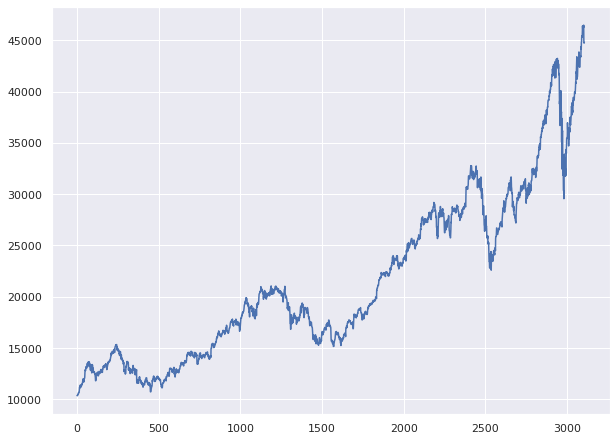

*-----Episode: 177, Reward:447.845075%-----*
Now we are at epoch 178


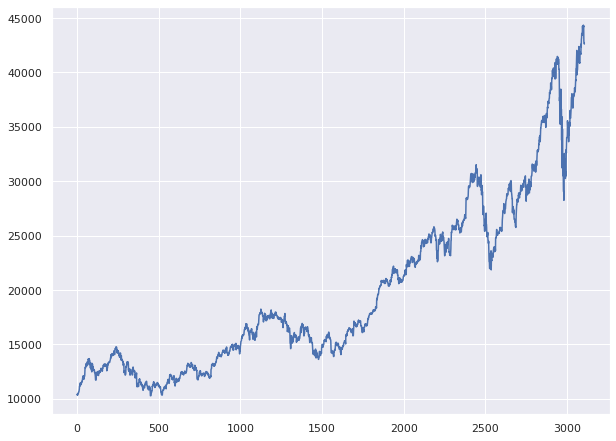

*-----Episode: 178, Reward:426.151523%-----*
Now we are at epoch 179


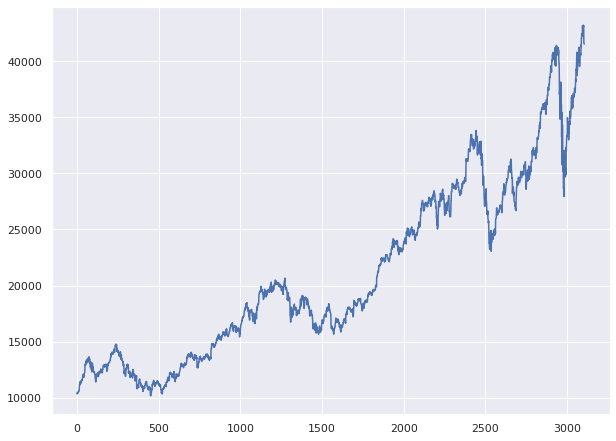

*-----Episode: 179, Reward:415.264729%-----*
Now we are at epoch 180


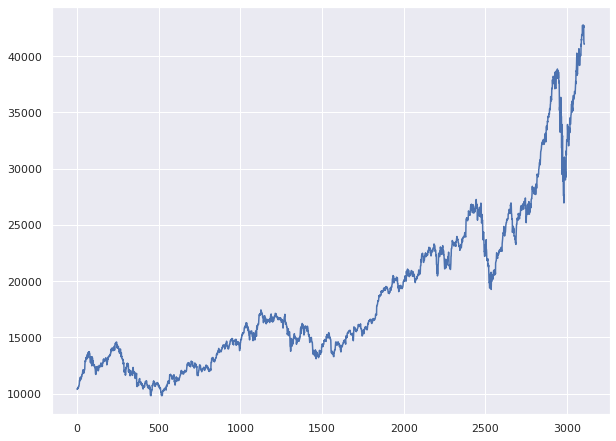

*-----Episode: 180, Reward:410.547519%-----*
Now we are at epoch 181


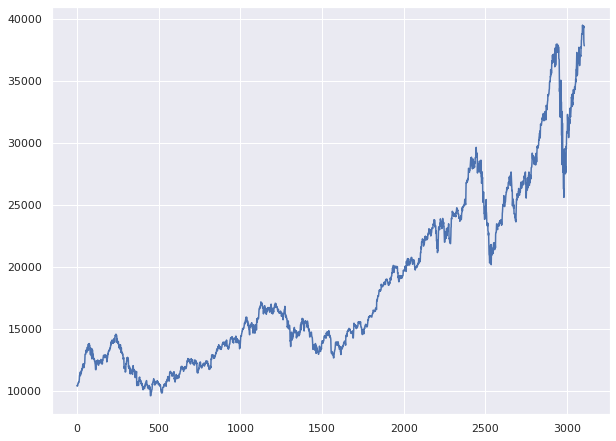

*-----Episode: 181, Reward:378.141292%-----*
Now we are at epoch 182


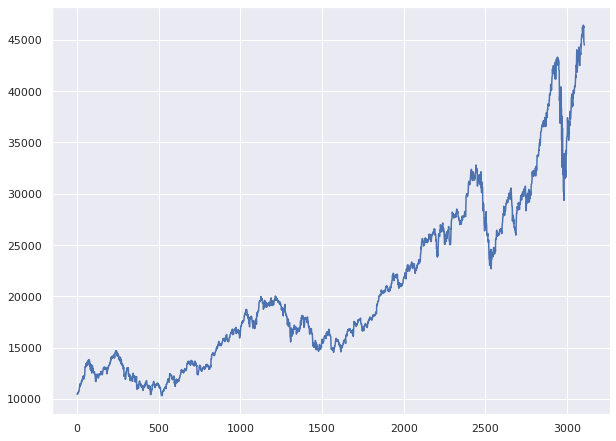

*-----Episode: 182, Reward:444.851160%-----*
Now we are at epoch 183


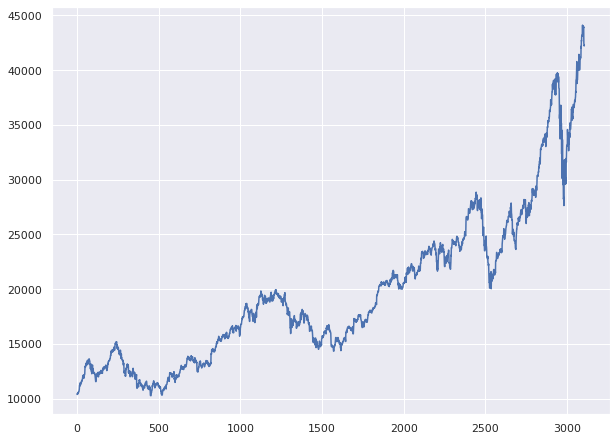

*-----Episode: 183, Reward:422.490001%-----*
Now we are at epoch 184


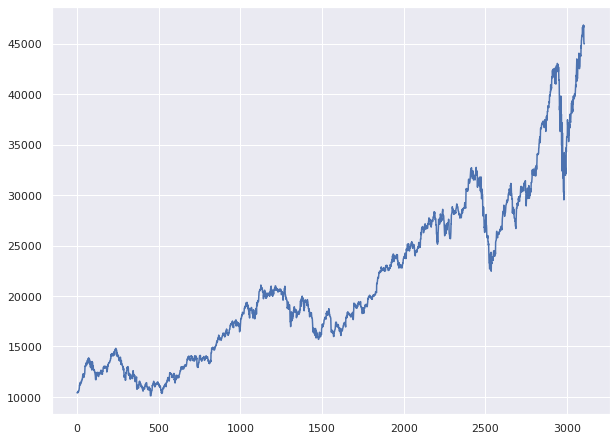

*-----Episode: 184, Reward:449.895084%-----*
Now we are at epoch 185


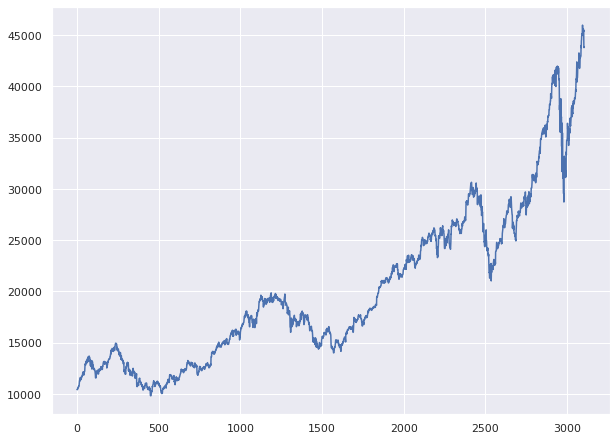

*-----Episode: 185, Reward:438.109202%-----*
Now we are at epoch 186


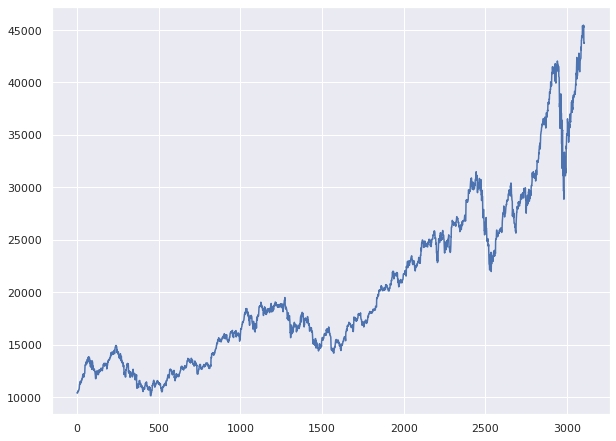

*-----Episode: 186, Reward:437.867757%-----*
Now we are at epoch 187


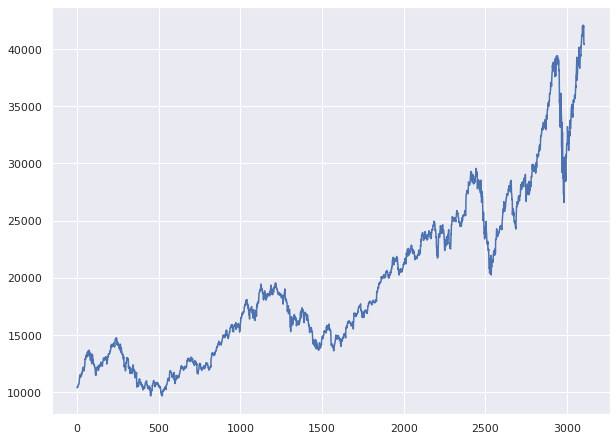

*-----Episode: 187, Reward:404.507405%-----*
Now we are at epoch 188


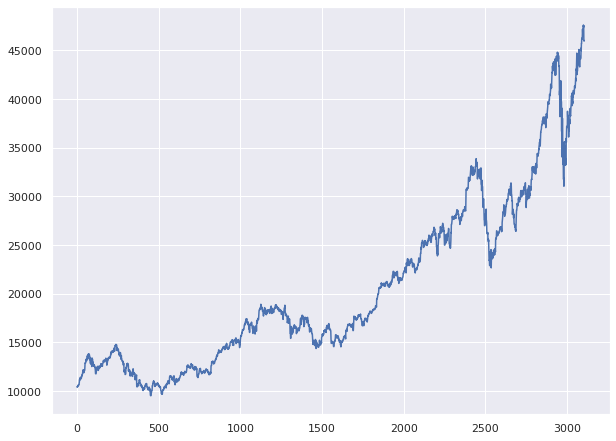

*-----Episode: 188, Reward:460.038510%-----*
Now we are at epoch 189


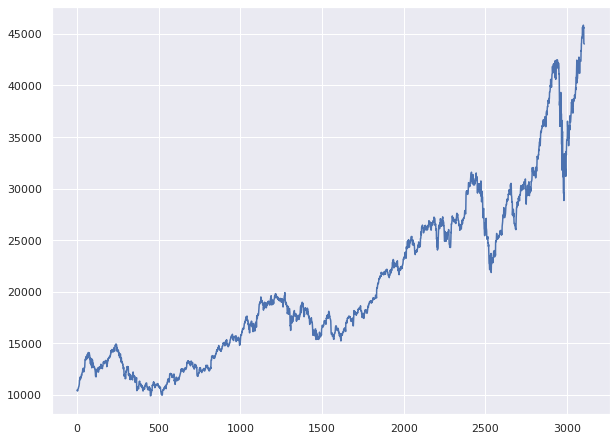

*-----Episode: 189, Reward:440.224114%-----*
Now we are at epoch 190


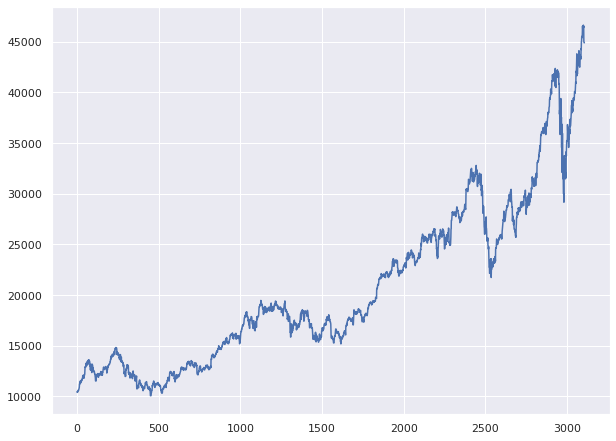

*-----Episode: 190, Reward:448.936083%-----*
Now we are at epoch 191


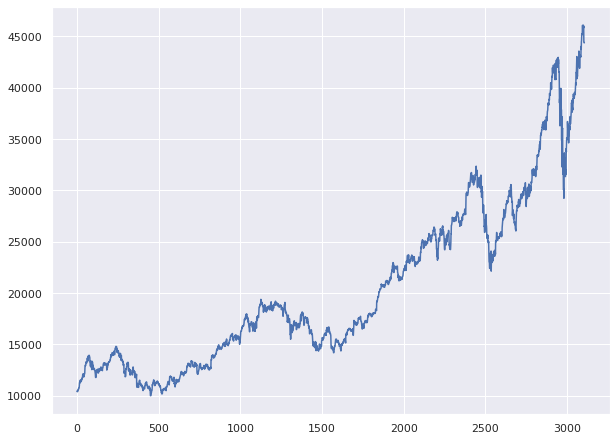

*-----Episode: 191, Reward:443.863125%-----*
Now we are at epoch 192


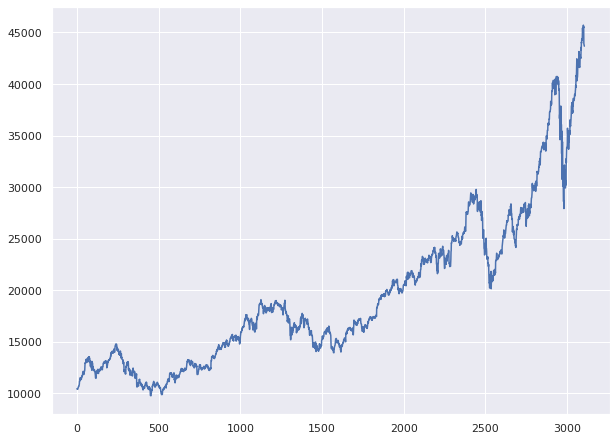

*-----Episode: 192, Reward:436.681167%-----*
Now we are at epoch 193


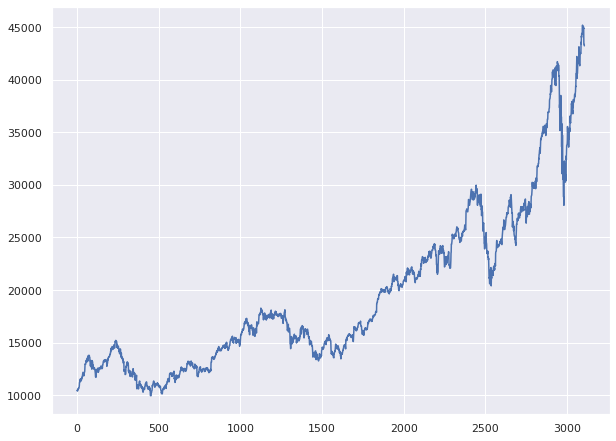

*-----Episode: 193, Reward:432.313958%-----*
Now we are at epoch 194


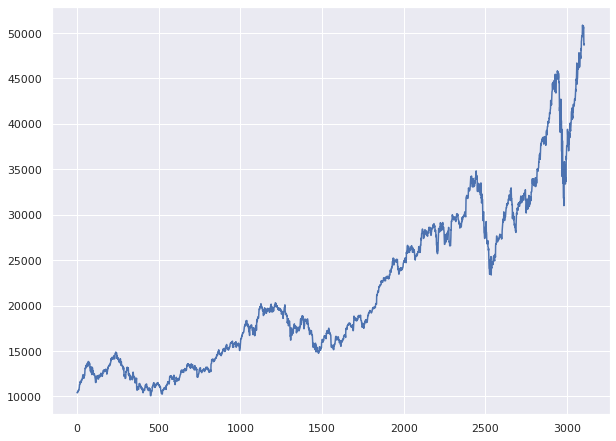

*-----Episode: 194, Reward:487.584699%-----*
Now we are at epoch 195


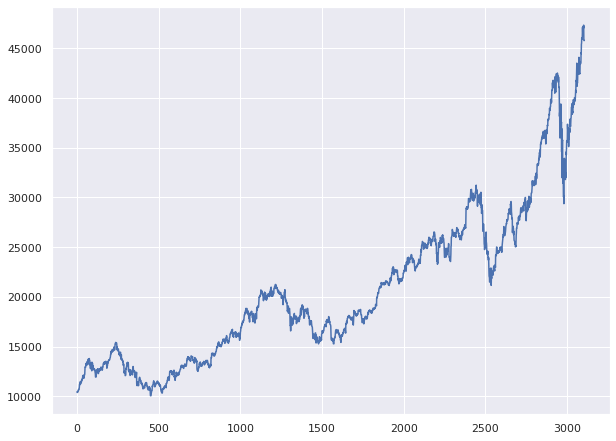

*-----Episode: 195, Reward:457.936230%-----*
Now we are at epoch 196


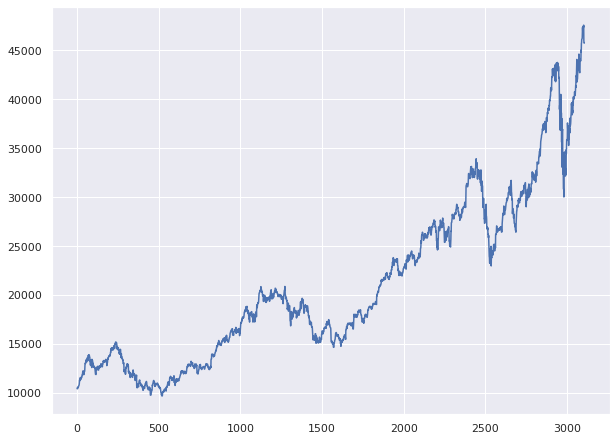

*-----Episode: 196, Reward:457.651873%-----*
Now we are at epoch 197


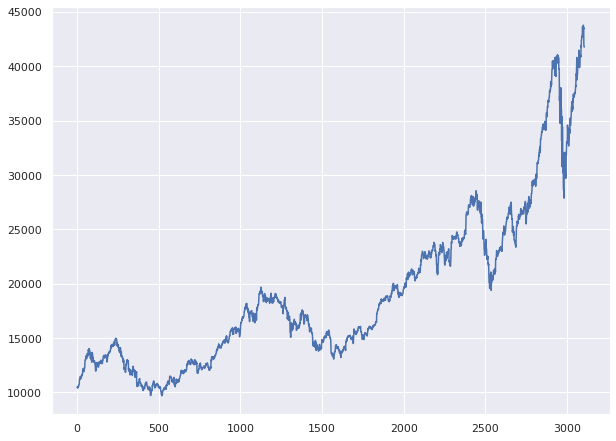

*-----Episode: 197, Reward:417.775723%-----*
Now we are at epoch 198


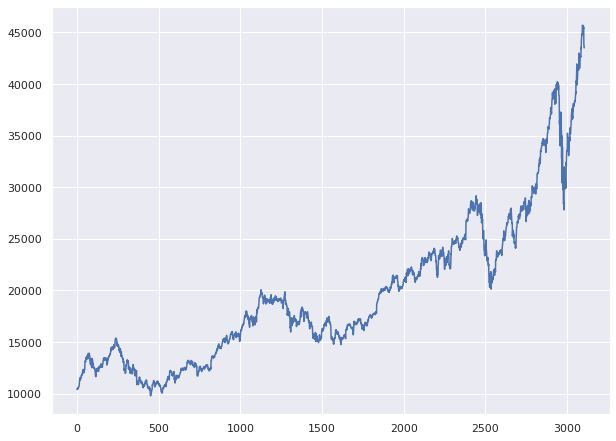

*-----Episode: 198, Reward:435.202251%-----*
Now we are at epoch 199


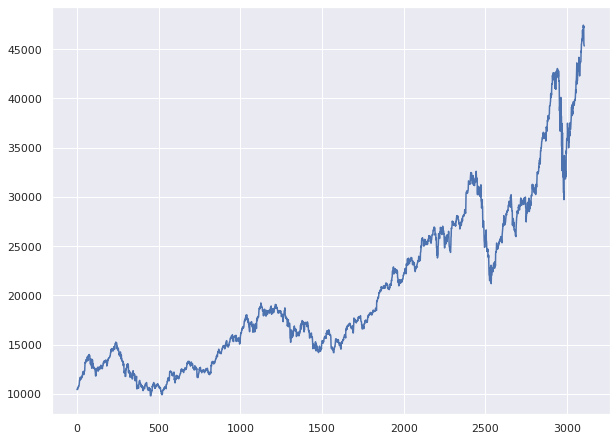

*-----Episode: 199, Reward:453.275066%-----*


In [24]:
"""

Launch of training set

"""

print("*-----------------Loading PG Agent---------------------*")
agent = PG(len(codes) + 1, int(window_length), len(features), 'pg_agent_name', reload_flag,
           trainable,noise_flag, runtime_version)

print("Training with {:d}".format(epochs))
for epoch in range(epochs):
    print("Now we are at epoch", epoch)
    traversal(stocktrader, agent, env, epoch, noise_flag, 'PG', method, trainable)

    if record_flag:
        stocktrader.write(epoch=epoch, agent_name='PG', prefix_dir=f'{runtime_version}/PG/train')

    if plot_flag:
        stocktrader.plot_result()

    agent.reset_buffer()
    stocktrader.print_result(epoch, agent, noise_flag)
    stocktrader.reset()
agent.close()
del agent

# 6 - Création des différentes stratégies de gestion de portefeuille 

In [25]:
"""
CNN baseline (single-state) consisting of convolutional layers followed by dense layers.
"""

import numpy as np

# Uniform CRP(Constant Rebalanced Portfolio)

class UCRP:
    def __init__(self):
        self.a_dim=0

    def predict(self,s,a):
        weights=np.ones(len(a[0]))/len(a[0])
        weights=weights[None,:]
        return weights

In [26]:
"""
Strategy based on selecting the weight from the maximum close price

"""

class WINNER:
    def __init__(self):
        self.a_dim=0

    def predict(self,s,a):
        close=[]
        for i,prices in enumerate(s[0]):
            closes=prices[-1]
            close.append(closes[-1]/closes[-2])
        weights = np.zeros(len(s[0]))
        weights[np.argmax(close)] = 1
        weights = weights[None,:]
        return weights

In [27]:

"""
Strategy based on selecting the weight from the minimum close price

"""

class LOOSER:
    def __init__(self):
        self.a_dim=0

    def predict(self,s,a):
        close = []
        for i, prices in enumerate(s[0]):
            closes = prices[-1]
            close.append(closes[-1] / closes[-2])
        weights = np.zeros(len(s[0]))
        weights[np.argmin(close)] = 1
        weights = weights[None, :]
        return weights

In [28]:
class RayDalio:
    
    """
    The All-Weather Portfolio is a lazy portfolio created by Ray Dalio,
    Bridgewater's hedge fund manager, and founder. As the name suggests,
    the All-Weather Portfolio is designed to perform well in all types of market conditions,
    such as inflation, deflation, economic growth, or decline.
    
    """
    def __init__(self, codes):
        ratio = {
            'risk-free' : 0.10,
            'KO' : 0.10,
            'AAPL' : 0.10,
            'XOM' : 0.10,
            'WMT' : 0.10,
            'PFE' : 0.10,
            'PG' : 0.10,
            'MCD' : 0.10,
            'JPM' : 0.10,
            'WFC' : 0.10,
        }

        self.ratio = [0.0] + [ratio[code] for code in codes]

    def predict(self, state, w1):
        weights = np.array(self.ratio)
        weights = weights[None, :]
        return weights

# 7 - Application de nos stratégies de gestion de portefeuille 

In [29]:
env.reset()

In [30]:
"""
Launch on the test set
"""


agents=[]

pg_name = 'pg_agent_name'
load_weights_to_init = True
trainable_to_init = False
noise_flag_to_load = noise_flag 

agents.extend(
    [PG(
        (len(codes) + 1), int(window_length), len(features), 
        pg_name, 
        load_weights_to_init, trainable_to_init, noise_flag_to_load, 
        runtime_version
    )]
)

agents.append(WINNER())
agents.append(UCRP())
agents.append(LOOSER())
agents.append(RayDalio(codes))
labels = ['CNN EIIE','Winner','UCRP','Looser', 'RayDailo']
step_units = [1, 200, 1, 200, 200]

wealths_result = list()
rs_result = list()
w_result = list()
for i, agent in enumerate(agents):
    stocktrader = StockTrader()
    agent_name = labels[i]
    noise_flag_to_step = False
    info = env.step(None, None, noise_flag_to_step)
    r, contin, s, w1, p, risk, close = parse_info(info)
    contin = 1
    wealth = 10000.
    wealths = [wealth]
    rs=[1]
    w = [w1]
    while contin:
        w2 = agent.predict(s, w1)
        env_info = env.step(w1, w2, noise_flag_to_step, step_unit=step_units[i])
        r, contin, s_next, w1, p, risk, close = parse_info(env_info)
        wealth = wealth * math.exp(r)
        for _ in range(step_units[i]):
            rs.append(math.exp(r)-1)
            wealths.append(wealth)
            w.append(w2)
        s = s_next
        stocktrader.update_summary(0, r, 0, 0, w2, p)

    stocktrader.write(codes=map(lambda x: str(x), env.get_codes()), agent_name=labels[i], prefix_dir=f'{runtime_version}/PG/test')
    print(f'finish agent "{labels[i]}"')
    wealths_result.append(wealths)
    rs_result.append(rs)
    w_result.append(w)

result_report_arr = []

for i in range(len(agents)):
    mrr=float(np.mean(rs_result[i])*100)
    sharpe=float(np.mean(rs_result[i])/np.std(rs_result[i])*np.sqrt(252))
    maxdrawdown=float(max(1-min(wealths_result[i])/np.maximum.accumulate(wealths_result[i])))
    result_report_arr.append([labels[i], f'{round(mrr,3)}%', round(sharpe,3), round(maxdrawdown,3)])
    # print(labels[i],'\t',round(mrr,3),'%','\t',round(sharpe,3),'\t',round(maxdrawdown,3))

result_report = pd.DataFrame(result_report_arr, columns=['Stratégie', 'Taux de rendement quotidien moyen', 'Ratio de Sharpe', 'perte maximale'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:541: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Loading Model
checkpoint dir: /content/result/2022-05-01T10:53:34.226583/PG/saved_network/True/
start restore
INFO:tensorflow:Restoring parameters from /content/result/2022-05-01T10:53:34.226583/PG/saved_network/True/pg_agent_name-200
Successfully loaded: /content/result/2022-05-01T10:53:34.226583/PG/saved_network/True/pg_agent_name-200
finish agent "CNN EIIE"
finish agent "Winner"
finish agent "UCRP"
finish agent "Looser"
finish agent "RayDailo"


In [31]:
result_report

Stratégie Taux de rendement quotidien moyen  Ratio de Sharpe  perte maximale
0  CNN EIIE                             0.09%            0.652           0.798
1    Winner                           -0.269%           -1.620           0.104
2      UCRP                            0.054%            0.438           0.506
3    Looser                           -0.414%           -3.114           0.074
4  RayDailo                          -10.064%          -78.790           0.818

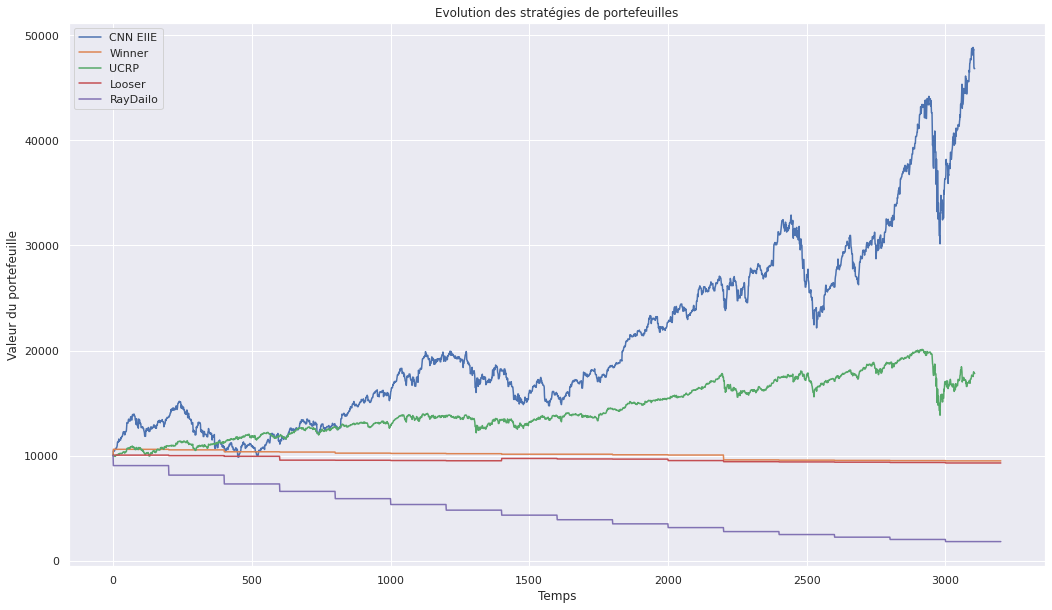

In [32]:
"""
Plot of result
"""
fig, ax = plt.subplots(figsize=(17.5, 10))

for i in range(len(agents)):
    plt.plot(wealths_result[i], label=labels[i])
plt.legend(['CNN EIIE','Winner','UCRP','Looser', 'RayDailo'])
plt.title("Evolution des stratégies de portefeuilles")
plt.xlabel("Temps")
plt.ylabel("Valeur du portefeuille")
plt.show()

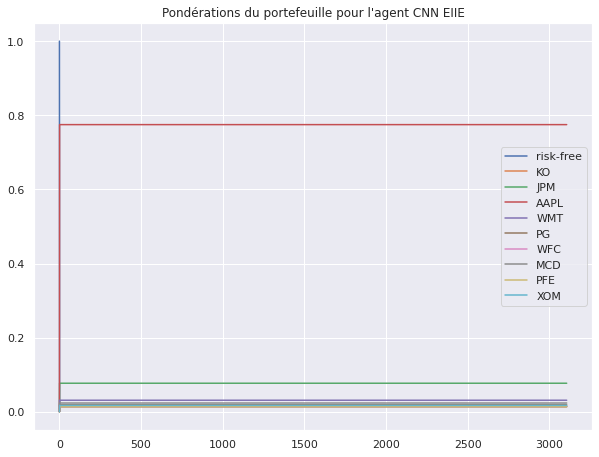

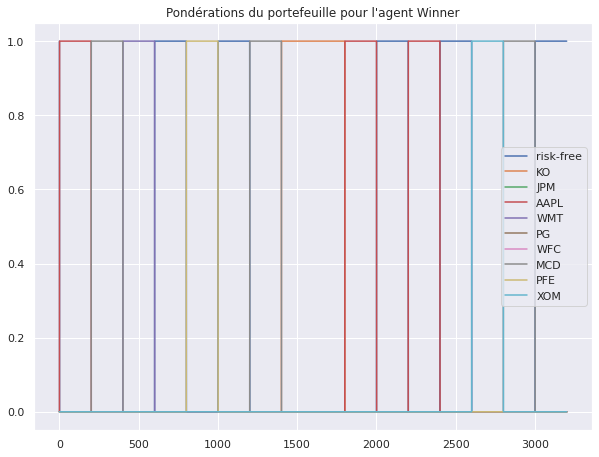

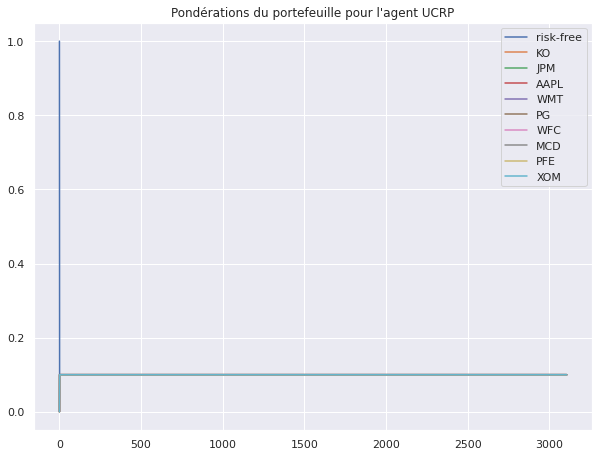

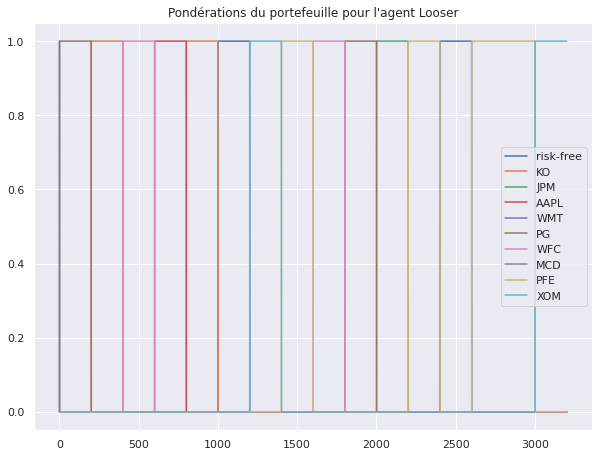

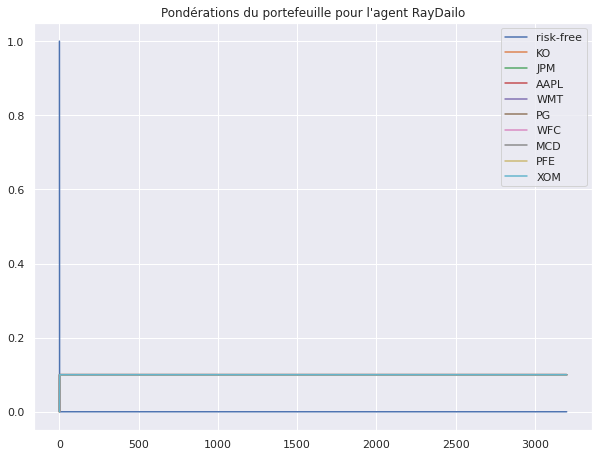

In [33]:
for agent in labels:
    w = np.stack(w_result[labels.index(agent)]).squeeze(1)
    w = pd.DataFrame(w, columns=['risk-free']+codes)
    for stock in ['risk-free']+codes :
        plt.plot(w[stock], label=stock)
    plt.legend()
    plt.title(f"Pondérations du portefeuille pour l'agent {agent}")
    plt.show()

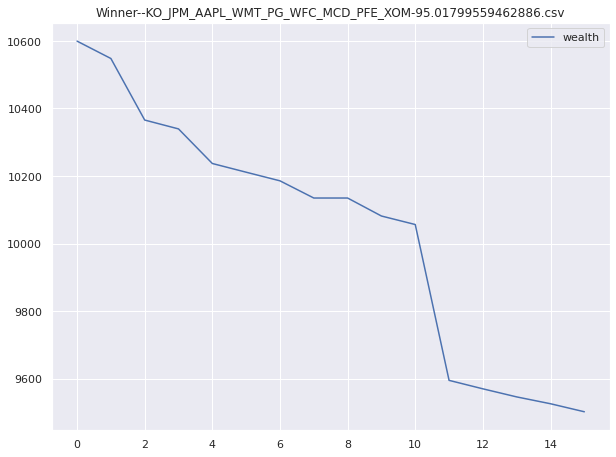

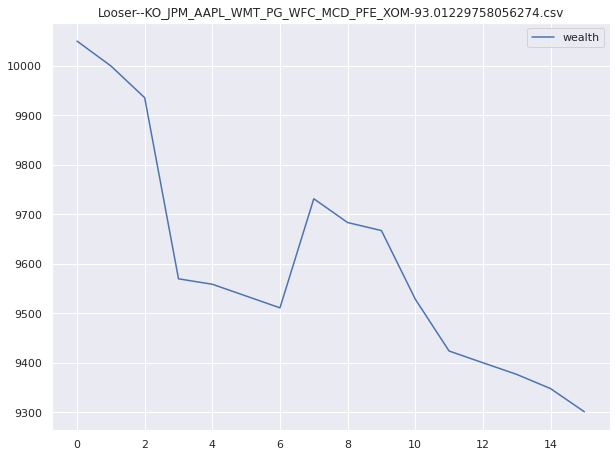

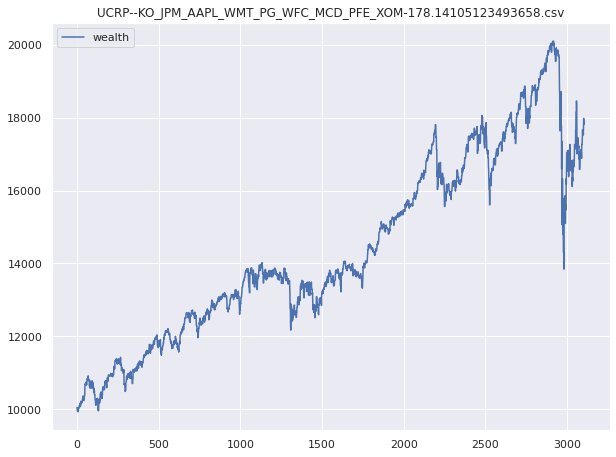

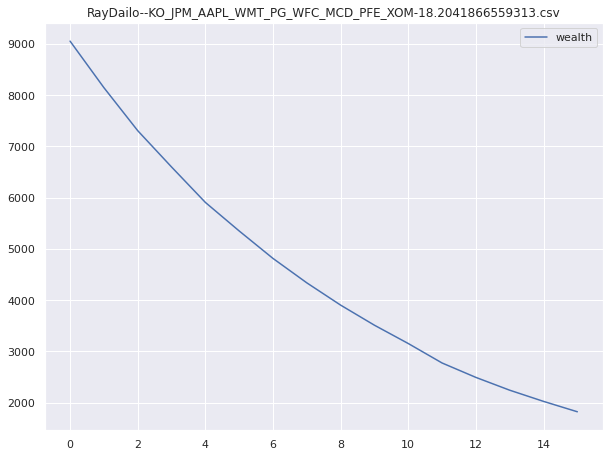

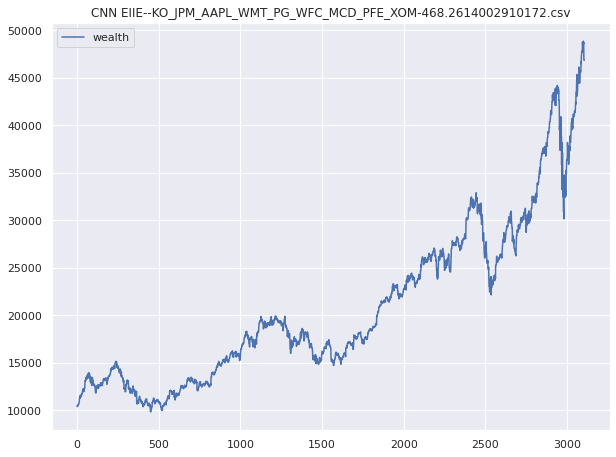

In [34]:

result_dir = f'{output_dir}/{runtime_version}/PG/test'
result_file_list = os.listdir(result_dir)
result_file_list = filter(lambda file: file.endswith('.csv'), result_file_list)

df_dict = {file: pd.read_csv(f'{result_dir}/{file}') for file in result_file_list}

keys = df_dict.keys()

for key in df_dict:
    df = df_dict[key]
    df = df[['wealth']]
    df.plot(title=key)

Nous constatons que notre algorithme et la stratégie UCRP ont de très belles performances et que les autres sont bien plus médiocres. Lorsque nous nous penchons sur les deux performances positives, nous pouvons expliquer l'excellente performance de notre réseaux de neurones par la composition de notre portefeuille. Ce choix a été fait et améliore par l'apprentissage.

Nous obtenons de très bons résultats de notre implémentation, ce qui prouve encore une fois que les méthodes de Machine Learning ont tout à fait leur place en finance quantitative. Toutefois, nous notons que notre application de papier de recherche pourrait être amélioré et complété par d'autres réseaux de neurones mais aussi par une expérience de gestion de portefeuille dynamique comme les auteurs ont pu le réaliser sur l'échange de cryptomonnaies Poliniex.com.

Export en HTML 

In [ ]:
#%%shell
#jupyter nbconvert --to html /content/projet_machine_learning_s2_ensae.ipynb